# Road Infrastructure Climate Risk Assessment Framework
## RICRAF Climate Risk Formula Development
---

## Overview

This notebook develops a Climate Risk Formula and compute Climate Risk Scores as described in the article **XGBoost–SHAP Framework for Multi-Stressor Road Network Risk Assessment**. It:

- Filters road network data to remove low-quality links
- Trains three XGBoost models (roughness, rutting, cracking)
- Uses SHAP to compute unified driver contributions
- Derives the **Climate Risk Formula (CRF)**:
  $$ \text{CRiskS} = \text{Hazard} \times \text{Exposure} \times \text{Vulnerability} $$
- Outputs **Climate Risk Scores (CRiskS)** at current GWL (1.2°C) and future scenarios
- Generates static figures and interactive Kepler.gl maps


### Key Features

- **Input**:
  - Fused dataset from data fusion stage (`gdf_road_clim_cln_final_withfuture.geojson`)
  → [Zenodo DOI: 10.5281/zenodo.17379391](https://doi.org/10.5281/zenodo.17379391)

- **Output**:
  - Processed CRiskS GeoJSON
  - SHAP summary plots
  - Static maps (PNG)
  - Interactive HTML map (`Kepler.gl`)

- **Reproducibility**: All paths relative, seeds set, dependencies pinned. All steps are scripted with modular functions from `src/`.

- **Transferability**: Modular for other regions (change CRS, predictors).

- **Dependencies**: Listed in `requirements.txt` (e.g. geopandas==1.0.1).


### Usage Instructions
1. Install dependencies: `pip install -r requirements.txt`.
2. Run cells sequentially.
3. Outputs are saved to `data/interim/` and `data/processed/`.

For full documentation, see the [RICRAF Development Paper](link-to-paper) (submitted to *TO BE DETERMINED*).


**Notes:**
- All spatial operations use EPSG:3111 (GDA94 / Vicgrid) for Victoria, Australia. Adapt CRS for other regions.
- This notebook emphasises reproducibility: Use virtual environments and document all steps.
- For large datasets, ensure sufficient memory (e.g. 16GB+ RAM).
- Final model uses **7,419 links** (after filtering + ML prep).
- Future GWLs (1.5°C, 2.0°C, 3.0°C) included for scalability
- Citation: If using this code or data, cite the associated papers and this repository (DOI via Zenodo).


**Dependencies:**
- Python 3.12+
- geopandas==1.0.1
- pandas==2.2.3
- numpy==2.1.3
- shapely==2.0.6
- pip contextily == 1.6.2
- loguru==0.7.3

Install via `requirements.txt` or uncomment the installation cells below.


In [ ]:
# # === ENVIRONMENT SETUP ===
# import os
# import warnings
# warnings.filterwarnings("ignore")
#
# import numpy as np
# import pandas as pd
# import geopandas as gpd
# import xgboost as xgb
# import shap
# import matplotlib.pyplot as plt
# import seaborn as sns
# from loguru import logger
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, r2_score
#
# # Local imports
# from src.ricraf_dev import filter_road_network, offset_line
#
# # Set random seed
# np.random.seed(42)


# Data Preparation for RICRAF Development: Outliers Filtering

In [1]:
import geopandas as gpd
import logging
import os
from src.ricraf_dev import filter_road_network  

# Set run ID and output directory
run_id = "model_dev"
output_dir = f"../data/processed/{run_id}"
os.makedirs(output_dir, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'../data/processed/{run_id}/filter_road_network.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# File paths
input_file = os.path.join(output_dir, "../gdf_road_clim_cln_final_withfuture.geojson")
filtered_output = os.path.join(output_dir, "gdf_road_clim_cln_final_withfuture_filtered.geojson")
removed_output = os.path.join(output_dir, "gdf_road_clim_cln_final_withfuture_outliers_removed.geojson")

# Ensure input file exists
if not os.path.exists(input_file):
    logger.error(f"Input file {input_file} does not exist")
    raise FileNotFoundError(f"Input file {input_file} does not exist")

# Run filtering
filter_road_network(input_file, filtered_output, removed_output)


2025-10-31 09:14:15.656 | INFO     | src.ricraf_dev:filter_road_network:31 - Initial number of features: 7579
2025-10-31 09:14:15.665 | INFO     | src.ricraf_dev:filter_road_network:45 - Number of features after filtering (non-outliers): 7454
2025-10-31 09:14:15.665 | INFO     | src.ricraf_dev:filter_road_network:46 - Number of features removed (outliers): 125
2025-10-31 09:14:18,011 - INFO - Created 7,454 records
2025-10-31 09:14:18.011 | INFO     | src.ricraf_dev:filter_road_network:50 - Filtered dataset saved to: ../data/processed/model_dev\gdf_road_clim_cln_final_withfuture_filtered.geojson
2025-10-31 09:14:18,362 - INFO - Created 125 records
2025-10-31 09:14:18.364 | INFO     | src.ricraf_dev:filter_road_network:54 - Removed dataset saved to: ../data/processed/model_dev\gdf_road_clim_cln_final_withfuture_outliers_removed.geojson


# Data Preparation for RICRAF Development: ML Data Preparation

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
from datetime import datetime
import json

# Set run ID and output directory
run_id = "model_dev"
output_dir = f"../data/processed/{run_id}"
# os.makedirs(output_dir, exist_ok=True)

print(f"[{datetime.now()}] ---- Data Preparation Outputs for Run_ID: {run_id} ----")

# Load preprocessed dataset
gdf_final = gpd.read_file(os.path.join(output_dir, "gdf_road_clim_cln_final_withfuture_filtered.geojson"))
gdf = gdf_final.copy()

# Distress mappings
roughness_map = {
    "Good (for <3.4IRI)": 0,
    "Fair (for 3.4IRI to < 4.2IRI)": 1,
    "Poor (for 4.2IRI to < 5.3IRI)": 2,
    "Very Poor (for >= 5.3IRI)": 3
}
rutting_map = {
    "Good (for <10mm)": 0,
    "Fair (for 10mm to < 15mm)": 1,
    "Poor (for 15mm to < 20mm)": 2,
    "Very Poor (for >= 20mm)": 3
}
cracking_map = {
    "Good (for <10%)": 0,
    "Poor (for >= 10%)": 1
}
gdf["Roughness_Code"] = gdf["Roughness_"].map(roughness_map)
gdf["Rutting_Code"] = gdf["Rutting_Ca"].map(rutting_map)
gdf["Cracking_Code"] = gdf["Cracking_C"].map(cracking_map)

# Check for road_link_id
if "road_link_id" not in gdf.columns:
    raise ValueError("Column 'road_link_id' not found in gdf_final.")

# Exclude rare Surface_Ty categories
exclude_categories = ["Concrete", "High Friction Surface Treatment", "Gravel", "Other"]
gdf = gdf[~gdf["Surface_Ty"].isin(exclude_categories)]
print(f"[{datetime.now()}] Excluded {len(gdf_final) - len(gdf)} segments with Surface_Ty in {exclude_categories}")
print(f"[{datetime.now()}] Remaining segments: {len(gdf)}")

# Compute Thermal_Diff
gdf["Thermal_Diff-current"] = gdf["tgm_max_gwl-current"] - gdf["tgm_min_gwl-current"]

# Define Predictors (excluding link_length, replacing tx35 with tx40)
predictors = [
    "ALLVEHS_AA", "TRUCKS_AAD", "SEAL_WIDTH",
    "HATI_Categ_Code", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code",
    "Thermal_Diff-current", "tx40_gwl-current", "tn02_gwl-current", "rx5d_gwl-current", "spi3_gwl-current",
]

# Define targets
targets = ["Roughness_Code", "Rutting_Code", "Cracking_Code"]

# Manual categorical mappings
surface_ty_map = {
    "Stone Seal": 0, "Asphalt": 1, "Ultra Thin Asphalt": 2
}
rma_clsfcn_map = {
    "FW": 0, "AH": 1, "AO": 2
}
hati_categ_map = {
    "Good (for <2.2 HATI)": 0, "Poor (for >= 2.2 HATI)": 1
}
texture_l_map = {
    "Good (for >= 1.3mm)": 0, "Poor (for <1.3mm)": 1
}

# Apply mappings
gdf["Surface_Ty_Code"] = gdf["Surface_Ty"].map(surface_ty_map)
gdf["RMA_CLSFCN_Code"] = gdf["RMA_CLSFCN"].map(rma_clsfcn_map)
gdf["HATI_Categ_Code"] = gdf["HATI_Categ"].map(hati_categ_map)
gdf["Texture__L_Code"] = gdf["Texture__L"].map(texture_l_map)

# Validate mappings
for col, mapping in [
    ("Surface_Ty_Code", surface_ty_map),
    ("RMA_CLSFCN_Code", rma_clsfcn_map),
    ("HATI_Categ_Code", hati_categ_map),
    ("Texture__L_Code", texture_l_map)
]:
    if gdf[col].isna().any():
        missing = gdf[gdf[col].isna()][col.replace("_Code", "")].unique()
        raise ValueError(f"Missing mappings for {col}: {missing}. Please update {mapping}.")
    print(f"[{datetime.now()}] Applied {col} mapping: {mapping}")

# Define numerical predictors (excluding link_length)
numerical_predictors = [col for col in predictors if col not in ["HATI_Categ_Code", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"]]

# Normalise numerical predictors using MinMaxScaler
scaler = MinMaxScaler()
gdf[numerical_predictors] = scaler.fit_transform(gdf[numerical_predictors])
print(f"[{datetime.now()}] Normalised numerical predictors using MinMaxScaler")

# Save normalisation parameters
normalisation_params = {
    col: {"min": float(gdf[col].min()), "max": float(gdf[col].max())} for col in numerical_predictors
}
norm_params_path = os.path.join(output_dir, f"ml_normalisation_params_{run_id}.json")
with open(norm_params_path, "w") as f:
    json.dump(normalisation_params, f, indent=2)
print(f"[{datetime.now()}] Saved ML normalisation parameters to {norm_params_path}")

# Convert categorical columns to 'category' type for XGBoost
for col in ["HATI_Categ_Code", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"]:
    if col in gdf.columns:
        gdf[col] = gdf[col].astype("category")

# Select columns to keep (include link_length for risk calculation)
col_retain = ["geometry", "road_link_id", "link_length"]
columns_to_keep = predictors + targets + col_retain
gdf = gdf[columns_to_keep].dropna()

# Save Pre-Processed Dataset
path_preproc = os.path.join(output_dir, f"gdf_road_clim_cln_final_{run_id}.geojson")
gdf.to_file(path_preproc, driver="GeoJSON")

# Summary
print(f"[{datetime.now()}] Dataset for {run_id} prepared:")
print(f"Number of segments: {len(gdf)}")
print(f"Predictors: {predictors}")
print(f"Additional columns retained: {col_retain}")

[2025-10-31 09:14:27.127794] ---- Data Preparation Outputs for Run_ID: model_dev ----
[2025-10-31 09:14:28.323605] Excluded 35 segments with Surface_Ty in ['Concrete', 'High Friction Surface Treatment', 'Gravel', 'Other']
[2025-10-31 09:14:28.323605] Remaining segments: 7419
[2025-10-31 09:14:28.328264] Applied Surface_Ty_Code mapping: {'Stone Seal': 0, 'Asphalt': 1, 'Ultra Thin Asphalt': 2}
[2025-10-31 09:14:28.328264] Applied RMA_CLSFCN_Code mapping: {'FW': 0, 'AH': 1, 'AO': 2}
[2025-10-31 09:14:28.328264] Applied HATI_Categ_Code mapping: {'Good (for <2.2 HATI)': 0, 'Poor (for >= 2.2 HATI)': 1}
[2025-10-31 09:14:28.328264] Applied Texture__L_Code mapping: {'Good (for >= 1.3mm)': 0, 'Poor (for <1.3mm)': 1}
[2025-10-31 09:14:28.328264] Normalised numerical predictors using MinMaxScaler
[2025-10-31 09:14:28.328264] Saved ML normalisation parameters to ../data/processed/model_dev\ml_normalisation_params_model_dev.json


2025-10-31 09:14:30,136 - INFO - Created 7,419 records


[2025-10-31 09:14:30.136422] Dataset for model_dev prepared:
Number of segments: 7419
Predictors: ['ALLVEHS_AA', 'TRUCKS_AAD', 'SEAL_WIDTH', 'HATI_Categ_Code', 'Surface_Ty_Code', 'Texture__L_Code', 'RMA_CLSFCN_Code', 'Thermal_Diff-current', 'tx40_gwl-current', 'tn02_gwl-current', 'rx5d_gwl-current', 'spi3_gwl-current']
Additional columns retained: ['geometry', 'road_link_id', 'link_length']


## VIF Multicollinearity Check

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
import logging
from tabulate import tabulate

# Set run ID and output directory
run_id = "model_dev"
output_dir = f"../data/processed/{run_id}/out_vif"
os.makedirs(output_dir, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(output_dir,'vif_multicollinearity.log')),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Load pre-processed dataset
path_preproc = os.path.join(output_dir, f"../gdf_road_clim_cln_final_{run_id}.geojson")
if not os.path.exists(path_preproc):
    logger.error(f"Input file {path_preproc} does not exist")
    raise FileNotFoundError(f"Input file {path_preproc} does not exist")
gdf = gpd.read_file(path_preproc)
logger.info(f"Loaded dataset with {len(gdf)} segments")

# Define predictors
predictors = [
    "Thermal_Diff-current", "tx40_gwl-current", "rx5d_gwl-current", "spi3_gwl-current", "tn02_gwl-current",
    "ALLVEHS_AA", "TRUCKS_AAD", "HATI_Categ_Code",
    "SEAL_WIDTH", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"
]

# Group predictors by AR5 elements
hazard_predictors = ["Thermal_Diff-current", "tx40_gwl-current", "rx5d_gwl-current", "spi3_gwl-current", "tn02_gwl-current"]
exposure_predictors = ["ALLVEHS_AA", "TRUCKS_AAD", "HATI_Categ_Code"]
vulnerability_predictors = ["SEAL_WIDTH", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"]

# Validate predictors
missing_cols = [col for col in predictors if col not in gdf.columns]
if missing_cols:
    logger.error(f"Missing predictors in dataset: {missing_cols}")
    raise ValueError(f"Missing predictors in dataset: {missing_cols}")
if gdf[predictors].isna().any().any():
    logger.error("Missing values detected in predictors")
    raise ValueError("Missing values detected in predictors")

# Prepare data for VIF
gdf_vif = gdf[predictors].copy()

# One-hot encode categorical variables
categorical_cols = ["HATI_Categ_Code", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"]
gdf_vif = pd.get_dummies(gdf_vif, columns=categorical_cols, drop_first=True, dtype=int)

# Update predictor lists with one-hot encoded columns
numerical_cols = [col for col in predictors if col not in categorical_cols]
encoded_cols = [col for col in gdf_vif.columns if col not in numerical_cols]
updated_hazard_predictors = hazard_predictors
updated_exposure_predictors = ["ALLVEHS_AA", "TRUCKS_AAD"] + [col for col in encoded_cols if col.startswith("HATI_Categ_Code")]
updated_vulnerability_predictors = ["SEAL_WIDTH"] + [col for col in encoded_cols if col.startswith(("Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"))]
updated_predictors = updated_hazard_predictors + updated_exposure_predictors + updated_vulnerability_predictors

# Validate data types
non_numeric_cols = [col for col in gdf_vif.columns if not np.issubdtype(gdf_vif[col].dtype, np.number)]
if non_numeric_cols:
    logger.error(f"Non-numeric columns detected in gdf_vif: {non_numeric_cols}")
    raise ValueError(f"Non-numeric columns detected in gdf_vif: {non_numeric_cols}")
logger.info(f"Data types after encoding:\n{gdf_vif.dtypes}")

# Standardise numerical predictors
scaler = StandardScaler()
gdf_vif[numerical_cols] = scaler.fit_transform(gdf_vif[numerical_cols])
logger.info("Standardised numerical predictors for VIF calculation")

# Function to compute VIF
def compute_vif(df, features):
    X = df[features].dropna()
    if X.empty:
        logger.error(f"No data available for VIF calculation with features: {features}")
        raise ValueError(f"No data available for VIF calculation with features: {features}")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Compute VIF
print(f"[{datetime.now()}] ---- Multicollinearity Check Outputs for Run_ID: {run_id} ----")
logger.info(f"Starting VIF analysis for Run_ID: {run_id}")

# Hazard
vif_hazard = compute_vif(gdf_vif, updated_hazard_predictors)
print(f"[{datetime.now()}] VIF Results for Hazard ({run_id}):")
print(tabulate(vif_hazard, headers="keys", tablefmt="psql", showindex=False))
logger.info(f"VIF Results for Hazard:\n{tabulate(vif_hazard, headers='keys', tablefmt='psql', showindex=False)}")

# Exposure
vif_exposure = compute_vif(gdf_vif, updated_exposure_predictors)
print(f"[{datetime.now()}] VIF Results for Exposure ({run_id}):")
print(tabulate(vif_exposure, headers="keys", tablefmt="psql", showindex=False))
logger.info(f"VIF Results for Exposure:\n{tabulate(vif_exposure, headers='keys', tablefmt='psql', showindex=False)}")

# Vulnerability
vif_vulnerability = compute_vif(gdf_vif, updated_vulnerability_predictors)
print(f"[{datetime.now()}] VIF Results for Vulnerability ({run_id}):")
print(tabulate(vif_vulnerability, headers="keys", tablefmt="psql", showindex=False))
logger.info(f"VIF Results for Vulnerability:\n{tabulate(vif_vulnerability, headers='keys', tablefmt='psql', showindex=False)}")

# Summary of high VIF predictors (within-group)
high_vif_within = pd.concat([
    vif_hazard[vif_hazard["VIF"] > 10],
    vif_exposure[vif_exposure["VIF"] > 10],
    vif_vulnerability[vif_vulnerability["VIF"] > 10]
])
print(f"[{datetime.now()}] Predictors with High VIF (>10) in {run_id} (Within-Group):")
if not high_vif_within.empty:
    print(tabulate(high_vif_within, headers="keys", tablefmt="psql", showindex=False))
    logger.warning(f"Predictors with High VIF (>10) (Within-Group):\n{tabulate(high_vif_within, headers='keys', tablefmt='psql', showindex=False)}")
else:
    print("No predictors with VIF > 10.")
    logger.info("No predictors with VIF > 10 (Within-Group).")

# Cross-element VIF
vif_cross = compute_vif(gdf_vif, updated_predictors)
print(f"[{datetime.now()}] VIF Results for Cross-Element ({run_id}):")
print(tabulate(vif_cross, headers="keys", tablefmt="psql", showindex=False))
logger.info(f"VIF Results for Cross-Element:\n{tabulate(vif_cross, headers='keys', tablefmt='psql', showindex=False)}")

# Summary of high VIF predictors (cross-element)
high_vif_cross = vif_cross[vif_cross["VIF"] > 10]
print(f"[{datetime.now()}] Predictors with High VIF (>10) in {run_id} (Cross-Element):")
if not high_vif_cross.empty:
    print(tabulate(high_vif_cross, headers="keys", tablefmt="psql", showindex=False))
    logger.warning(f"Predictors with High VIF (>10) (Cross-Element):\n{tabulate(high_vif_cross, headers='keys', tablefmt='psql', showindex=False)}")
else:
    print("No predictors with VIF > 10.")
    logger.info("No predictors with VIF > 10 (Cross-Element).")


2025-10-31 09:15:11,206 - INFO - Loaded dataset with 7419 segments
2025-10-31 09:15:11,213 - INFO - Data types after encoding:
Thermal_Diff-current    float64
tx40_gwl-current        float64
rx5d_gwl-current        float64
spi3_gwl-current        float64
tn02_gwl-current        float64
ALLVEHS_AA              float64
TRUCKS_AAD              float64
SEAL_WIDTH              float64
HATI_Categ_Code_1         int64
Surface_Ty_Code_1         int64
Surface_Ty_Code_2         int64
Texture__L_Code_1         int64
RMA_CLSFCN_Code_1         int64
RMA_CLSFCN_Code_2         int64
dtype: object
2025-10-31 09:15:11,217 - INFO - Standardised numerical predictors for VIF calculation
2025-10-31 09:15:11,218 - INFO - Starting VIF analysis for Run_ID: model_dev
2025-10-31 09:15:11,231 - INFO - VIF Results for Hazard:
+----------------------+---------+
| Variable             |     VIF |
|----------------------+---------|
| Thermal_Diff-current | 1.82987 |
| tx40_gwl-current     | 1.8493  |
| rx5d_gwl-curr

[2025-10-31 09:15:11.218630] ---- Multicollinearity Check Outputs for Run_ID: model_dev ----
[2025-10-31 09:15:11.230429] VIF Results for Hazard (model_dev):
+----------------------+---------+
| Variable             |     VIF |
|----------------------+---------|
| Thermal_Diff-current | 1.82987 |
| tx40_gwl-current     | 1.8493  |
| rx5d_gwl-current     | 1.44534 |
| spi3_gwl-current     | 1.14519 |
| tn02_gwl-current     | 1.66235 |
+----------------------+---------+
[2025-10-31 09:15:11.235428] VIF Results for Exposure (model_dev):
+-------------------+---------+
| Variable          |     VIF |
|-------------------+---------|
| ALLVEHS_AA        | 4.4217  |
| TRUCKS_AAD        | 4.46181 |
| HATI_Categ_Code_1 | 1.02056 |
+-------------------+---------+
[2025-10-31 09:15:11.242426] VIF Results for Vulnerability (model_dev):
+-------------------+---------+
| Variable          |     VIF |
|-------------------+---------|
| SEAL_WIDTH        | 1.17862 |
| Surface_Ty_Code_1 | 2.47447 |
| Su

2025-10-31 09:15:17,306 - INFO - Saved VIF results to ../data/processed/model_dev/out_vif


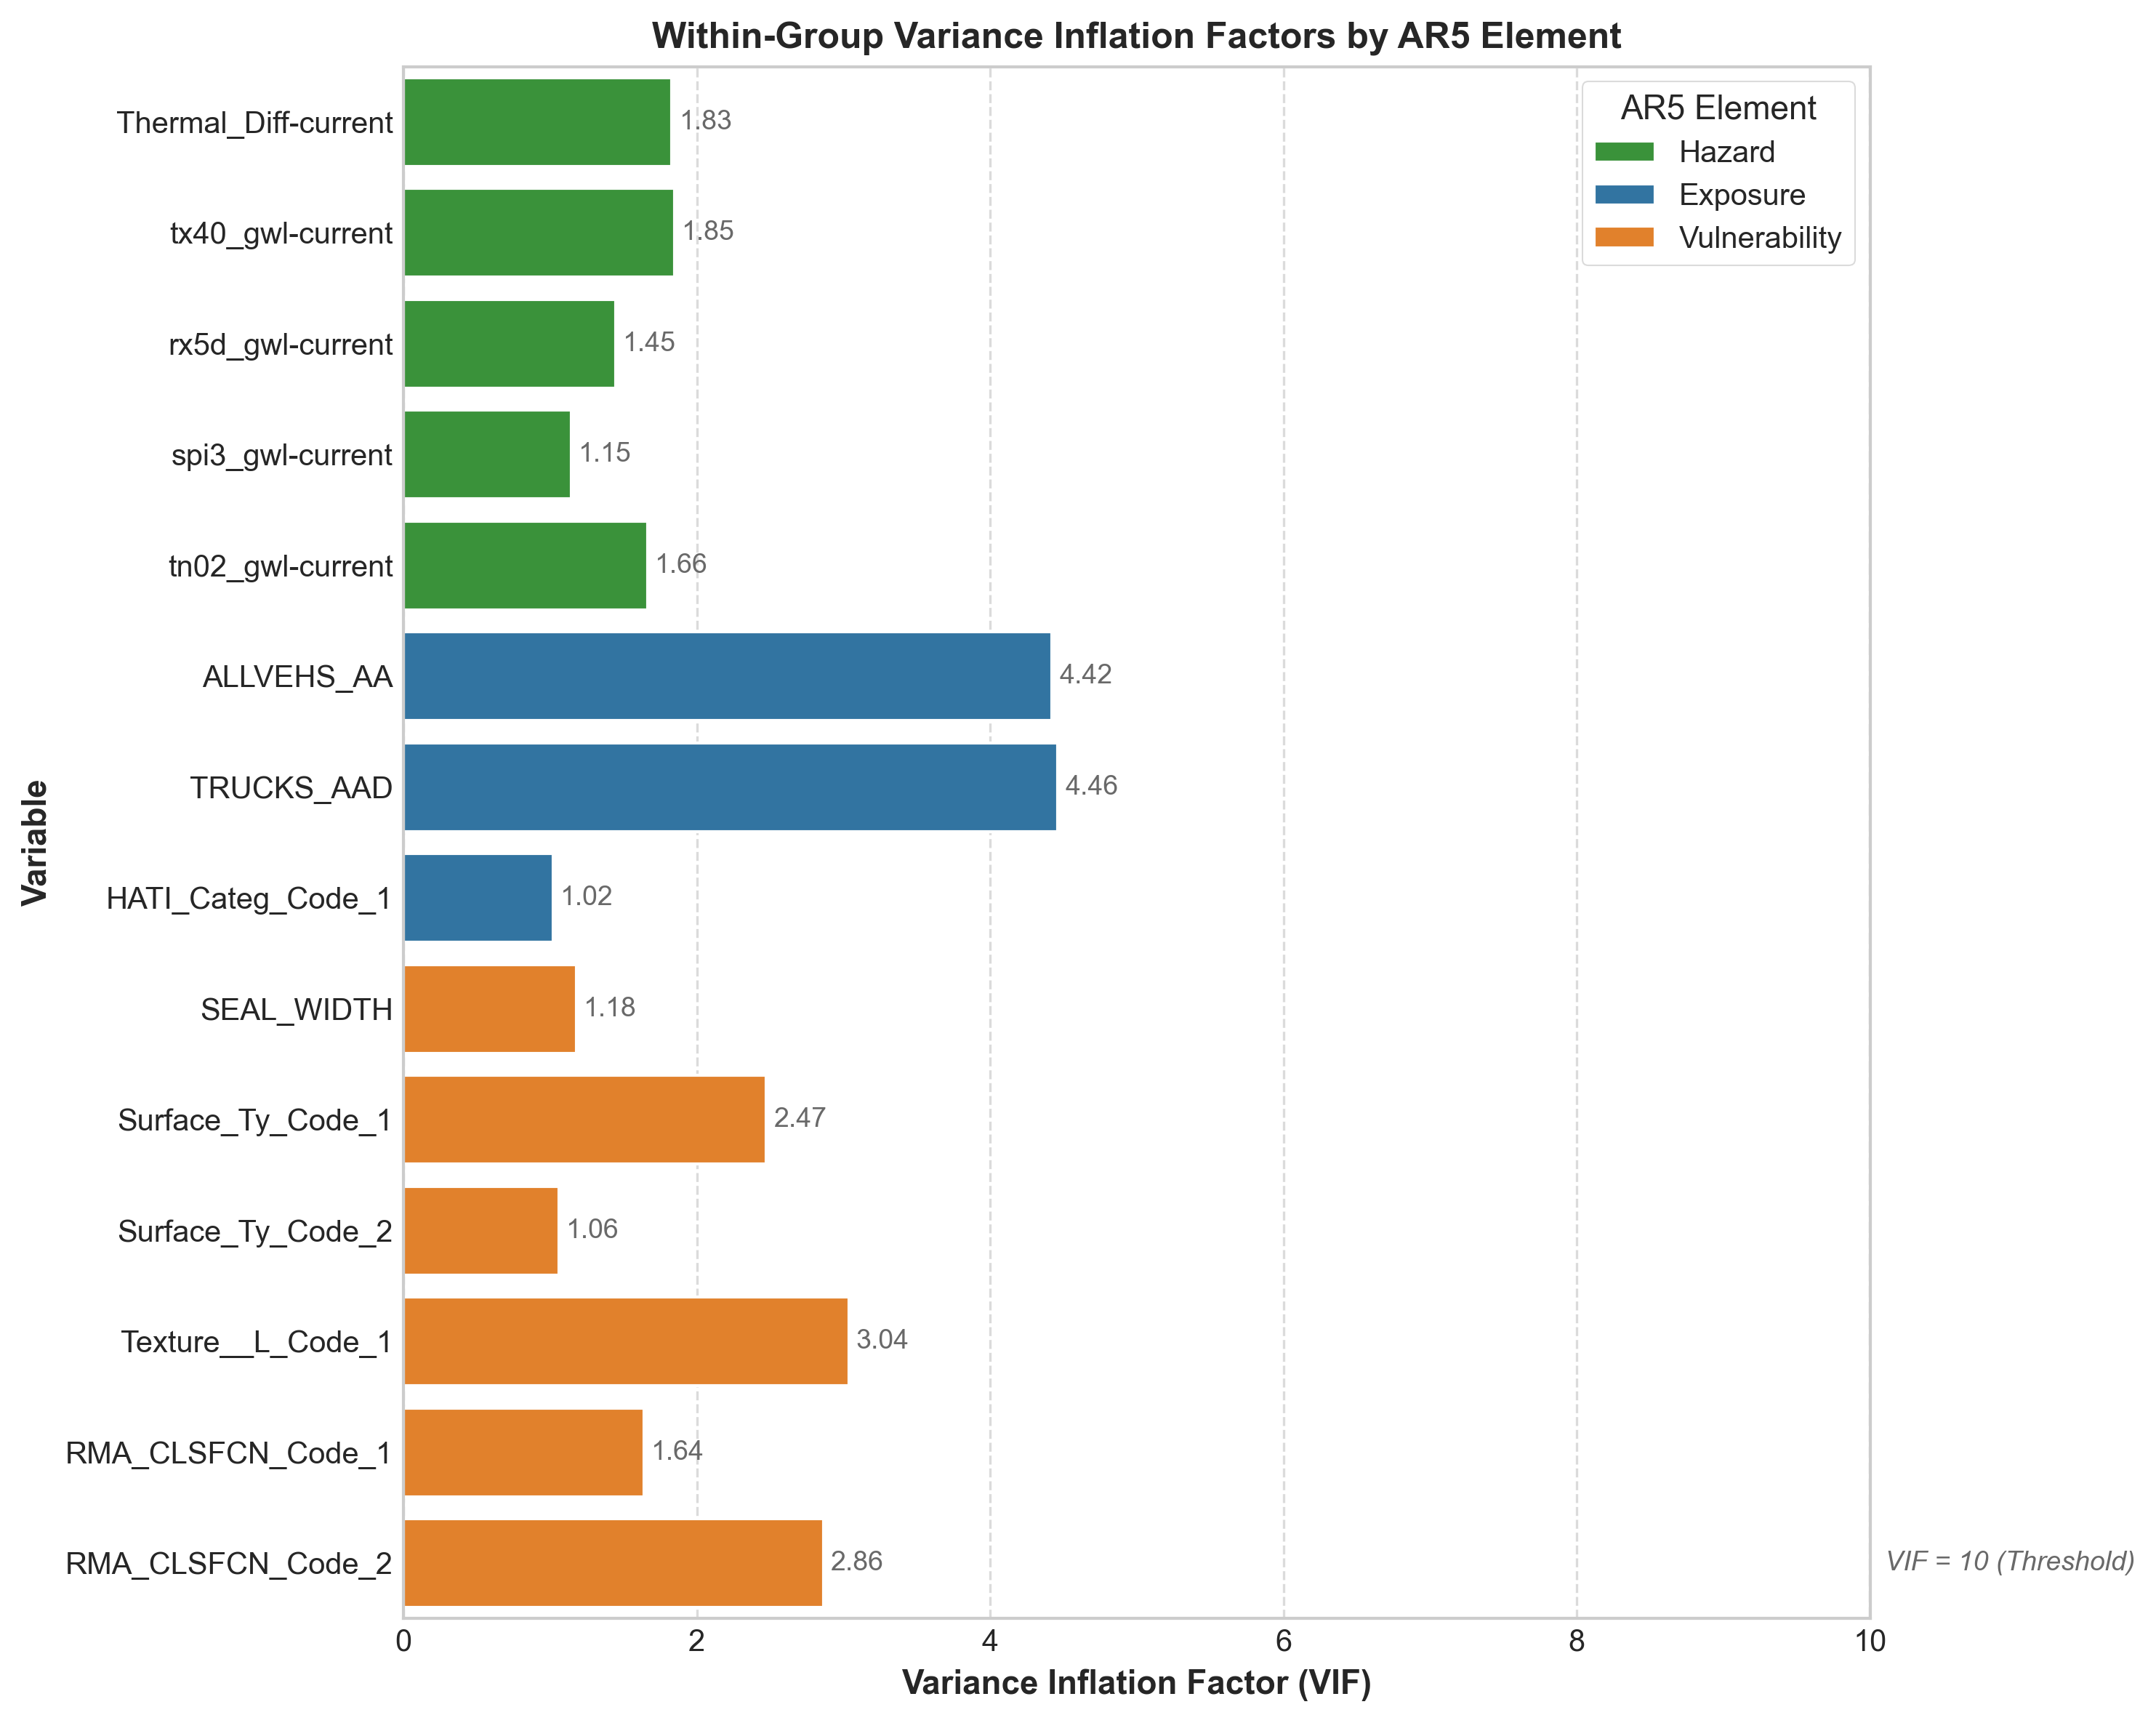

2025-10-31 09:15:18,134 - INFO - Saved Within-Group VIF plot to ../data/processed/model_dev/out_vif/vif_within_group_model_dev.png


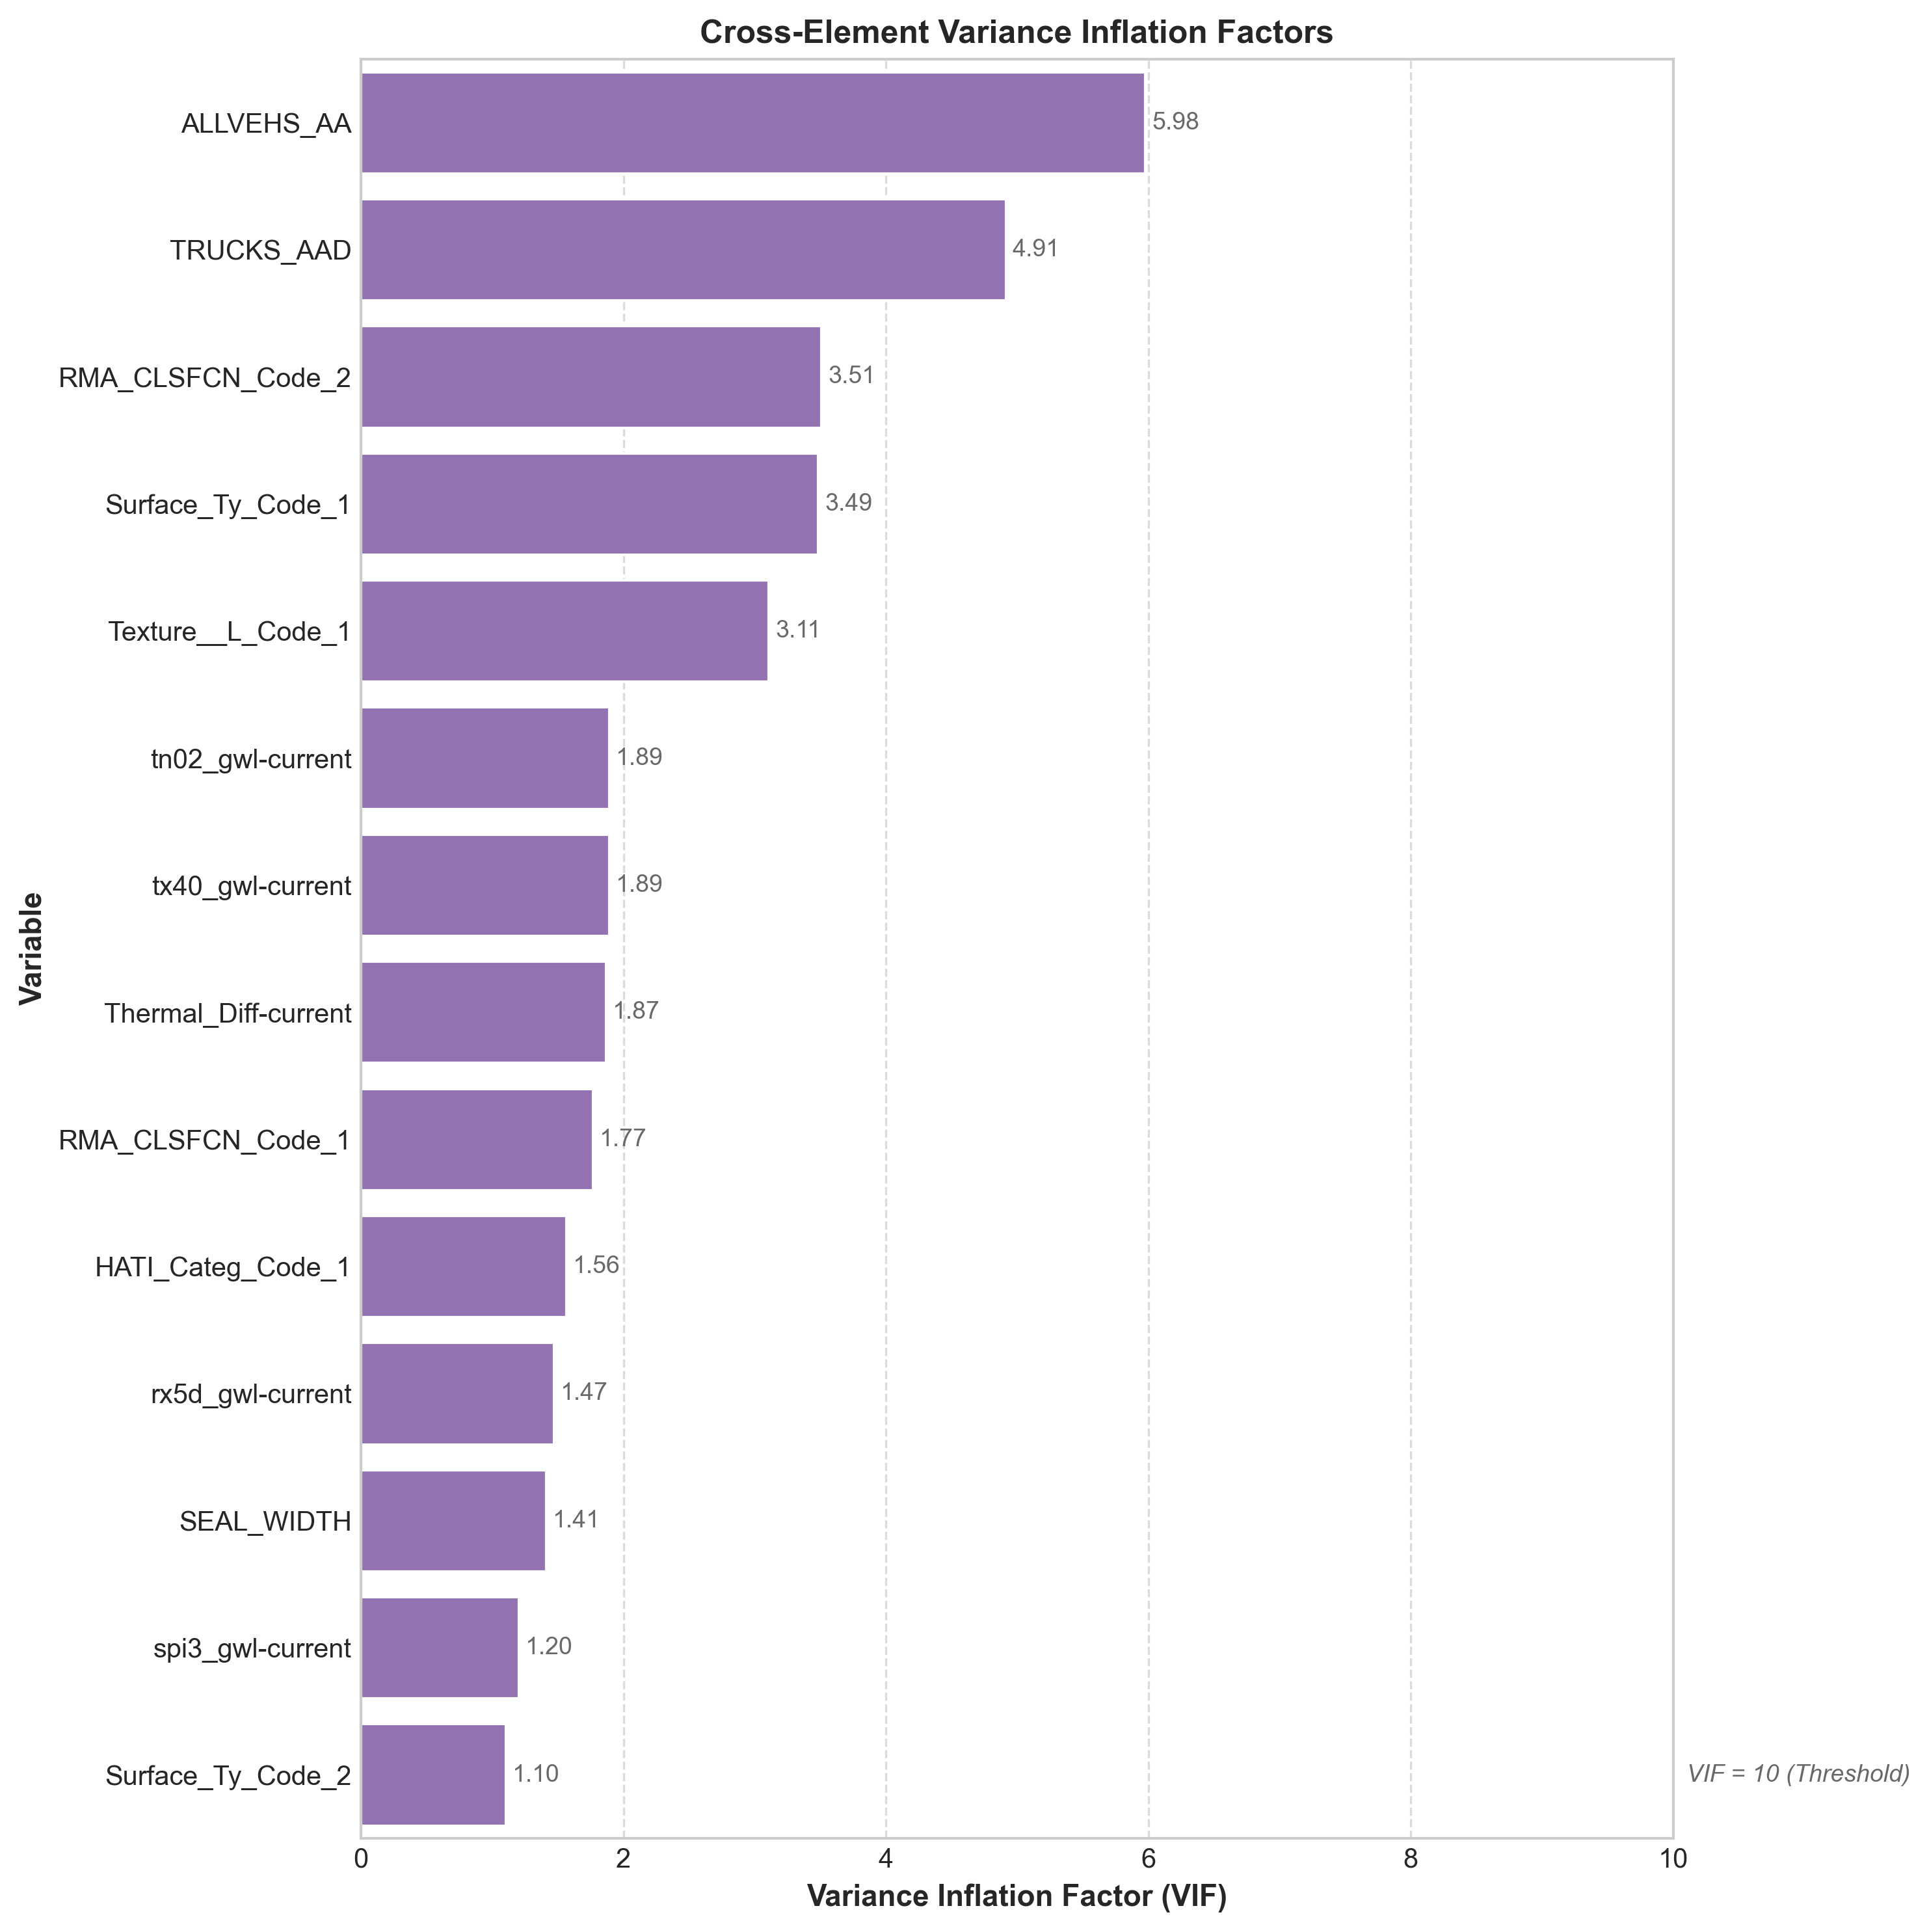

2025-10-31 09:15:19,014 - INFO - VIF visualisations saved in PNG to ../data/processed/model_dev/out_vif/


In [4]:
# VIF for Reporting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
from datetime import datetime
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'../data/processed/{run_id}/out_vif/vif_visualization.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set run ID and output directory
run_id = "model_dev"
output_dir = f"../data/processed/{run_id}/out_vif"
os.makedirs(output_dir, exist_ok=True)

# Save VIF DataFrames to CSV for traceability (assuming they are available from VIF script)
vif_hazard.to_csv(os.path.join(output_dir, f"vif_hazard_{run_id}.csv"), index=False)
vif_exposure.to_csv(os.path.join(output_dir, f"vif_exposure_{run_id}.csv"), index=False)
vif_vulnerability.to_csv(os.path.join(output_dir, f"vif_vulnerability_{run_id}.csv"), index=False)
vif_cross.to_csv(os.path.join(output_dir, f"vif_cross_{run_id}.csv"), index=False)
logger.info(f"Saved VIF results to {output_dir}")

# Load VIF results from CSV (or use in-memory DataFrames if available)
vif_hazard = pd.read_csv(os.path.join(output_dir, f"vif_hazard_{run_id}.csv"))
vif_exposure = pd.read_csv(os.path.join(output_dir, f"vif_exposure_{run_id}.csv"))
vif_vulnerability = pd.read_csv(os.path.join(output_dir, f"vif_vulnerability_{run_id}.csv"))
vif_cross = pd.read_csv(os.path.join(output_dir, f"vif_cross_{run_id}.csv"))

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['figure.dpi'] = 300

# Professional color palette for categorical variables
# Hazard, Exposure, Vulnerability
colors = ['#2ca02c', '#1f77b4',  '#ff7f0e']  # Orange, Blue, Green

# Combine Within-Group VIF data into one DataFrame for plotting
vif_hazard = vif_hazard.assign(Group="Hazard")
vif_exposure = vif_exposure.assign(Group="Exposure")
vif_vulnerability = vif_vulnerability.assign(Group="Vulnerability")
vif_within = pd.concat([vif_hazard, vif_exposure, vif_vulnerability], ignore_index=True)

# Plot 1: Within-Group VIF
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="VIF", y="Variable", hue="Group", data=vif_within, palette=colors, ax=ax)

# Configure the plot
ax.set_xlim(0, max(vif_within['VIF'].max() * 1.1, 10))
ax.set_title("Within-Group Variance Inflation Factors by AR5 Element", fontweight='bold')
ax.set_xlabel("Variance Inflation Factor (VIF)", fontweight='bold')
ax.set_ylabel("Variable", fontweight='bold')

# Format the legend
legend = ax.legend(title="AR5 Element", frameon=True)
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('lightgray')

# Add VIF threshold line
ax.axvline(x=10, linestyle='--', color='gray', alpha=0.7, linewidth=1)
ax.text(10.1, len(vif_within) - 1, "VIF = 10 (Threshold)", va='center', fontsize=9, color='dimgray', style='italic')

# Add value labels to each bar
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(x=width + 0.05, y=p.get_y() + p.get_height() / 2,
                s=f"{width:.2f}", ha="left", va="center",
                fontsize=9, fontweight='normal', color='dimgray')

# Add grid for easier reading
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"vif_within_group_{run_id}.png"), dpi=300, bbox_inches='tight')
plt.show()
logger.info(f"Saved Within-Group VIF plot to {output_dir}/vif_within_group_{run_id}.png")

# Plot 2: Cross-Element VIF
fig, ax = plt.subplots(figsize=(10, 10))  # Increased height for more variables
vif_cross_sorted = vif_cross.sort_values('VIF', ascending=False)
sns.barplot(x="VIF", y="Variable", data=vif_cross_sorted, color='#9467bd', ax=ax)

# Configure the plot
ax.set_xlim(0, max(vif_cross['VIF'].max() * 1.1, 10))
ax.set_title("Cross-Element Variance Inflation Factors", fontweight='bold')
ax.set_xlabel("Variance Inflation Factor (VIF)", fontweight='bold')
ax.set_ylabel("Variable", fontweight='bold')

# Add VIF threshold line
ax.axvline(x=10, linestyle='--', color='gray', alpha=0.7, linewidth=1)
ax.text(10.1, len(vif_cross) - 1, "VIF = 10 (Threshold)", va='center', fontsize=9, color='dimgray', style='italic')

# Add value labels to each bar
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(x=width + 0.05, y=p.get_y() + p.get_height() / 2,
                s=f"{width:.2f}", ha="left", va="center",
                fontsize=9, fontweight='normal', color='dimgray')

# Add grid for easier reading
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"vif_cross_element_{run_id}.png"), dpi=300, bbox_inches='tight')
plt.show()
logger.info(f"VIF visualisations saved in PNG to {output_dir}/")


# Exploratory Data Analysis

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import spearmanr, pearsonr, f_oneway
import os
from datetime import datetime
import logging

run_id = "model_dev"
output_dir = f"../data/processed/{run_id}"
figure_dir = os.path.join(output_dir, "out_eda")
os.makedirs(figure_dir, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'../data/processed/{run_id}/out_eda/eda_main.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set publication-quality styling
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['figure.dpi'] = 300

# Load pre-processed dataset
path_preproc = os.path.join(output_dir, f"gdf_road_clim_cln_final_{run_id}.geojson")
if not os.path.exists(path_preproc):
    logger.error(f"Input file {path_preproc} does not exist")
    raise FileNotFoundError(f"Input file {path_preproc} does not exist")
gdf = gpd.read_file(path_preproc)
logger.info(f"Loaded dataset with {len(gdf)} segments")

# Define predictors and targets
predictors = [
    "Thermal_Diff-current", "tx40_gwl-current", "rx5d_gwl-current", "spi3_gwl-current", "tn02_gwl-current",
    "ALLVEHS_AA", "TRUCKS_AAD", "HATI_Categ_Code",
    "SEAL_WIDTH", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code"
]
targets = ["Roughness_Code", "Rutting_Code", "Cracking_Code"]

print(f"[{datetime.now()}] ---- Exploratory Data Analysis Outputs for Run_ID: {run_id} ----")
logger.info(f"Starting EDA for Run_ID: {run_id}")

# Descriptive Statistics
print(f"[{datetime.now()}] Descriptive Statistics for Predictors:")
desc_stats = gdf[predictors].describe()
print(desc_stats.to_string())
logger.info(f"Descriptive Statistics for Predictors:\n{desc_stats.to_string()}")

# Distress Distributions
print(f"[{datetime.now()}] Distribution of Distress Metrics:")
logger.info("Distribution of Distress Metrics:")
for target in targets:
    print(f"\n{target} Distribution:")
    dist = gdf[target].value_counts(normalize=True).sort_index()
    print(dist.to_string())
    logger.info(f"{target} Distribution:\n{dist.to_string()}")

# Correlation Analysis (Spearman)
print(f"[{datetime.now()}] Correlation Analysis (Spearman’s Rank):")
spearman_corrs = pd.DataFrame(index=predictors, columns=targets)
for predictor in predictors:
    for target in targets:
        corr, pval = spearmanr(gdf[predictor], gdf[target])
        spearman_corrs.loc[predictor, target] = f"{corr:.3f} (p={pval:.3f})"
print(spearman_corrs.to_string())
logger.info(f"Correlation Analysis (Spearman’s Rank):\n{spearman_corrs.to_string()}")

# Correlation Analysis (Pearson)
print(f"[{datetime.now()}] Correlation Analysis (Pearson):")
pearson_corrs = pd.DataFrame(index=predictors, columns=targets)
for predictor in predictors:
    for target in targets:
        corr, pval = pearsonr(gdf[predictor], gdf[target])
        pearson_corrs.loc[predictor, target] = f"{corr:.3f} (p={pval:.3f})"
print(pearson_corrs.to_string())
logger.info(f"Correlation Analysis (Pearson):\n{pearson_corrs.to_string()}")

# ANOVA for Categorical Predictors
print(f"[{datetime.now()}] ANOVA Results for Categorical Predictors:")
categorical_predictors = ["Surface_Ty_Code", "RMA_CLSFCN_Code", "HATI_Categ_Code", "Texture__L_Code"]
logger.info("ANOVA Results for Categorical Predictors:")
for predictor in categorical_predictors:
    print(f"\n{predictor} vs. Distress Metrics:")
    logger.info(f"{predictor} vs. Distress Metrics:")
    for target in targets:
        groups = [gdf[target][gdf[predictor] == cat] for cat in gdf[predictor].unique()]
        f_stat, pval = f_oneway(*groups)
        print(f"{target}: F={f_stat:.2f}, p={pval:.3f}")
        logger.info(f"{target}: F={f_stat:.2f}, p={pval:.3f}")

# Visualisations
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Count Plots
for target in targets:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target, data=gdf, palette=colors)
    plt.title(f"Count of {target} Classes", fontweight='bold')
    plt.xlabel(target, fontweight='bold')
    plt.ylabel("Count", fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, f"countplot_{target}_{run_id}.png"), dpi=300, bbox_inches='tight')
    # plt.savefig(os.path.join(figure_dir, f"countplot_{target}_{run_id}.pdf"), format='pdf', bbox_inches='tight')
    plt.close()
    logger.info(f"Saved count plot for {target} to {figure_dir}/countplot_{target}_{run_id}.png")

# Violin Plots
for predictor in ["Thermal_Diff-current", "SEAL_WIDTH"]:
    for target in targets:
        plt.figure(figsize=(8, 6))
        sns.violinplot(x=target, y=predictor, data=gdf, palette=colors)
        plt.title(f"{predictor} vs. {target}", fontweight='bold')
        plt.xlabel(target, fontweight='bold')
        plt.ylabel(predictor, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(figure_dir, f"violinplot_{predictor}_vs_{target}_{run_id}.png"), dpi=300, bbox_inches='tight')
        # plt.savefig(os.path.join(figure_dir, f"violinplot_{predictor}_vs_{target}_{run_id}.pdf"), format='pdf', bbox_inches='tight')
        plt.close()
        logger.info(f"Saved violin plot for {predictor} vs. {target} to {figure_dir}/violinplot_{predictor}_vs_{target}_{run_id}.png")

# Heatmaps
for predictor in ["HATI_Categ_Code", "Surface_Ty_Code"]:
    for target in targets:
        cross_tab = pd.crosstab(gdf[predictor], gdf[target], normalize="index")
        plt.figure(figsize=(8, 6))
        sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt=".2f")
        plt.title(f"Proportion of {target} by {predictor}", fontweight='bold')
        plt.xlabel(target, fontweight='bold')
        plt.ylabel(predictor, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(figure_dir, f"heatmap_{predictor}_vs_{target}_{run_id}.png"), dpi=300, bbox_inches='tight')
        # plt.savefig(os.path.join(figure_dir, f"heatmap_{predictor}_vs_{target}_{run_id}.pdf"), format='pdf', bbox_inches='tight')
        plt.close()
        logger.info(f"Saved heatmap for {predictor} vs. {target} to {figure_dir}/heatmap_{predictor}_vs_{target}_{run_id}.png")

print(f"[{datetime.now()}] EDA visualisations saved to {figure_dir}")
logger.info(f"EDA visualisations saved to {figure_dir}")


2025-10-31 09:15:26,633 - INFO - Loaded dataset with 7419 segments
2025-10-31 09:15:26,633 - INFO - Starting EDA for Run_ID: model_dev
2025-10-31 09:15:26,656 - INFO - Descriptive Statistics for Predictors:
       Thermal_Diff-current  tx40_gwl-current  rx5d_gwl-current  spi3_gwl-current  tn02_gwl-current   ALLVEHS_AA   TRUCKS_AAD  HATI_Categ_Code   SEAL_WIDTH  Surface_Ty_Code  Texture__L_Code  RMA_CLSFCN_Code
count           7419.000000       7419.000000       7419.000000       7419.000000       7419.000000  7419.000000  7419.000000      7419.000000  7419.000000      7419.000000      7419.000000      7419.000000
mean               0.155887          0.134376          0.208016          0.338248          0.091570     0.096924     0.071140         0.290875     0.209810         0.567732         0.614638         1.457609
std                0.122833          0.137210          0.087961          0.161330          0.113260     0.119493     0.106658         0.454196     0.100250         0.543685

[2025-10-31 09:15:26.633993] ---- Exploratory Data Analysis Outputs for Run_ID: model_dev ----
[2025-10-31 09:15:26.638484] Descriptive Statistics for Predictors:
       Thermal_Diff-current  tx40_gwl-current  rx5d_gwl-current  spi3_gwl-current  tn02_gwl-current   ALLVEHS_AA   TRUCKS_AAD  HATI_Categ_Code   SEAL_WIDTH  Surface_Ty_Code  Texture__L_Code  RMA_CLSFCN_Code
count           7419.000000       7419.000000       7419.000000       7419.000000       7419.000000  7419.000000  7419.000000      7419.000000  7419.000000      7419.000000      7419.000000      7419.000000
mean               0.155887          0.134376          0.208016          0.338248          0.091570     0.096924     0.071140         0.290875     0.209810         0.567732         0.614638         1.457609
std                0.122833          0.137210          0.087961          0.161330          0.113260     0.119493     0.106658         0.454196     0.100250         0.543685         0.486714         0.705429
min      

2025-10-31 09:15:27,019 - INFO - Saved count plot for Roughness_Code to ../data/processed/model_dev\out_eda/countplot_Roughness_Code_model_dev.png
2025-10-31 09:15:27,040 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\OneMetis\AppData\Local\Temp\ipykernel_36052\358329734.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, data=gdf, palette=colors)
C:\Users\OneMetis\AppData\Local\Temp\ipykernel_36052\358329734.py:112: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=target, data=gdf, palette=colors)
2025-10-31 09:15:27,046 - INFO - Using categorical units to plot a list of

[2025-10-31 09:15:31.539178] EDA visualisations saved to ../data/processed/model_dev\out_eda


2025-10-31 09:15:36,369 - INFO - Loaded dataset with 7419 segments
2025-10-31 09:15:36,387 - INFO - Descriptive Statistics for Predictors:
        ALLVEHS_AA   TRUCKS_AAD  HATI_Categ_Code   SEAL_WIDTH  Surface_Ty_Code  Texture__L_Code  RMA_CLSFCN_Code  Thermal_Diff-current  tx40_gwl-current  tn02_gwl-current  rx5d_gwl-current  spi3_gwl-current
count  7419.000000  7419.000000      7419.000000  7419.000000      7419.000000      7419.000000      7419.000000           7419.000000       7419.000000       7419.000000       7419.000000       7419.000000
mean      0.096924     0.071140         0.290875     0.209810         0.567732         0.614638         1.457609              0.155887          0.134376          0.091570          0.208016          0.338248
std       0.119493     0.106658         0.454196     0.100250         0.543685         0.486714         0.705429              0.122833          0.137210          0.113260          0.087961          0.161330
min       0.000000     0.000000  

[2025-10-31 09:15:36.369692] ---- Outputs from Exploratory Data Analysis (model_dev) ----
[2025-10-31 09:15:36.369692] Descriptive Statistics for Predictors:
        ALLVEHS_AA   TRUCKS_AAD  HATI_Categ_Code   SEAL_WIDTH  Surface_Ty_Code  Texture__L_Code  RMA_CLSFCN_Code  Thermal_Diff-current  tx40_gwl-current  tn02_gwl-current  rx5d_gwl-current  spi3_gwl-current
count  7419.000000  7419.000000      7419.000000  7419.000000      7419.000000      7419.000000      7419.000000           7419.000000       7419.000000       7419.000000       7419.000000       7419.000000
mean      0.096924     0.071140         0.290875     0.209810         0.567732         0.614638         1.457609              0.155887          0.134376          0.091570          0.208016          0.338248
std       0.119493     0.106658         0.454196     0.100250         0.543685         0.486714         0.705429              0.122833          0.137210          0.113260          0.087961          0.161330
min       0.00

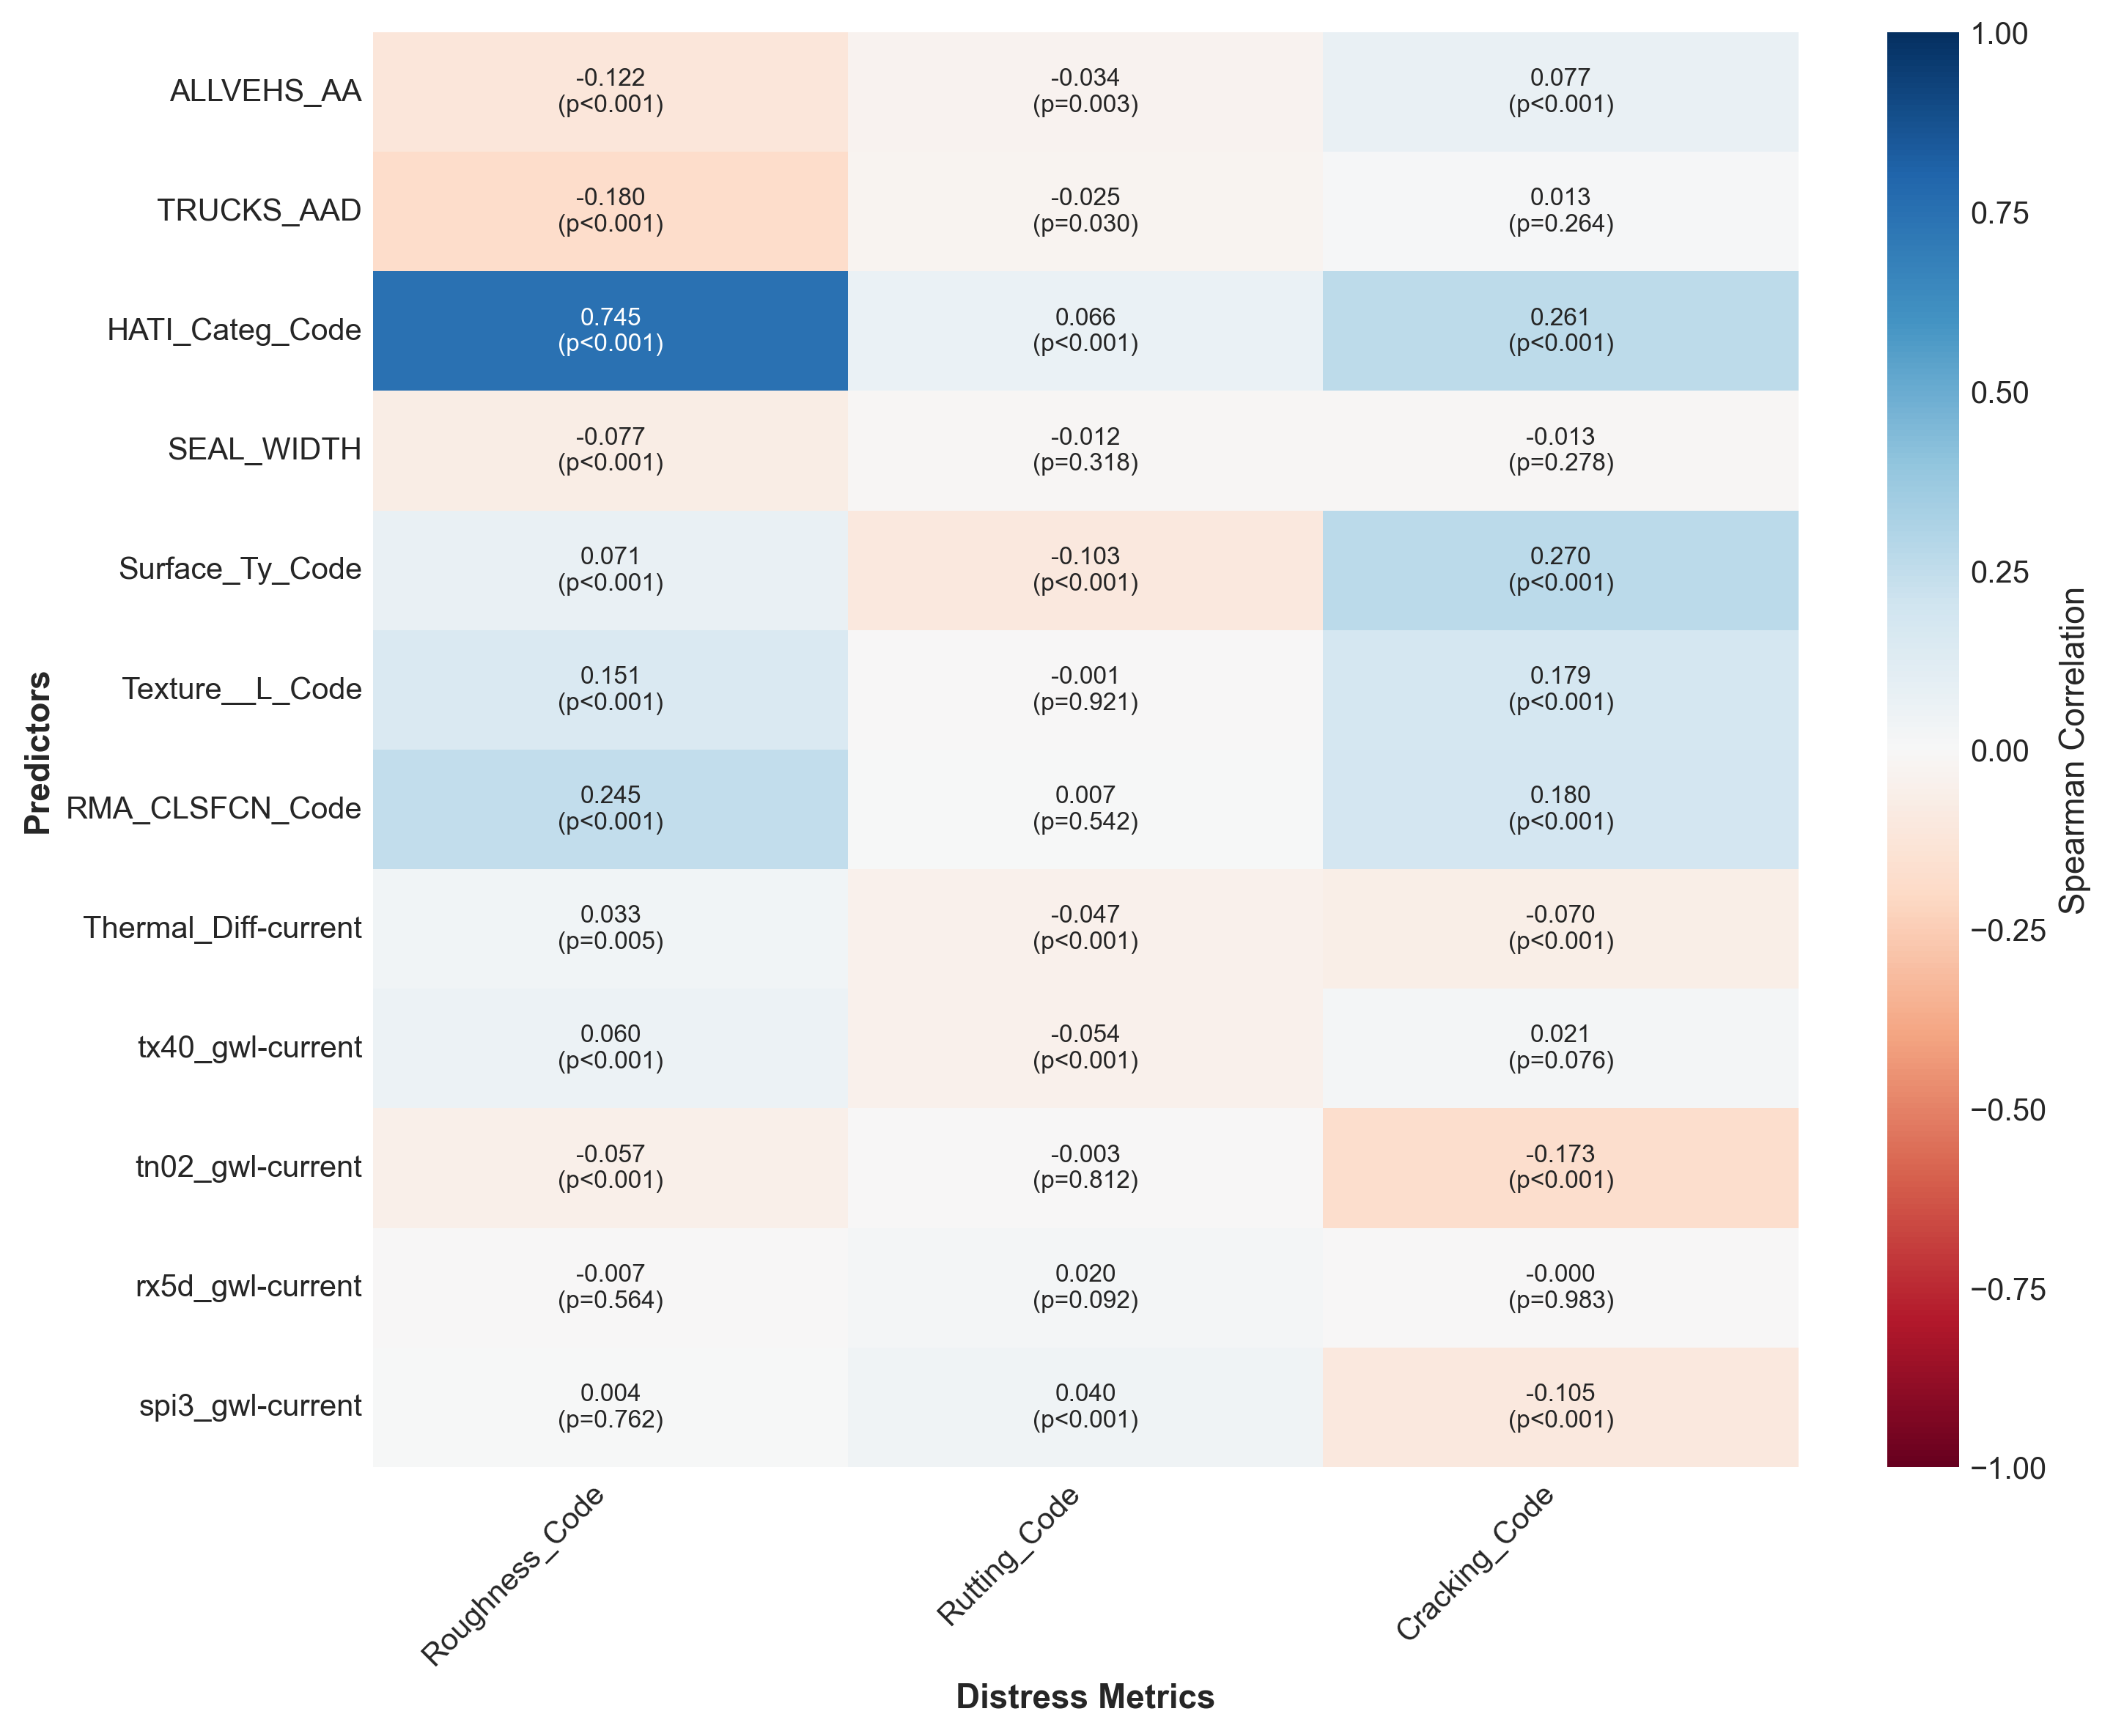

2025-10-31 09:15:37,208 - INFO - Saved Spearman correlation heatmap to ../data/processed/model_dev\out_eda/correlation_heatmap_spearman_model_dev.png


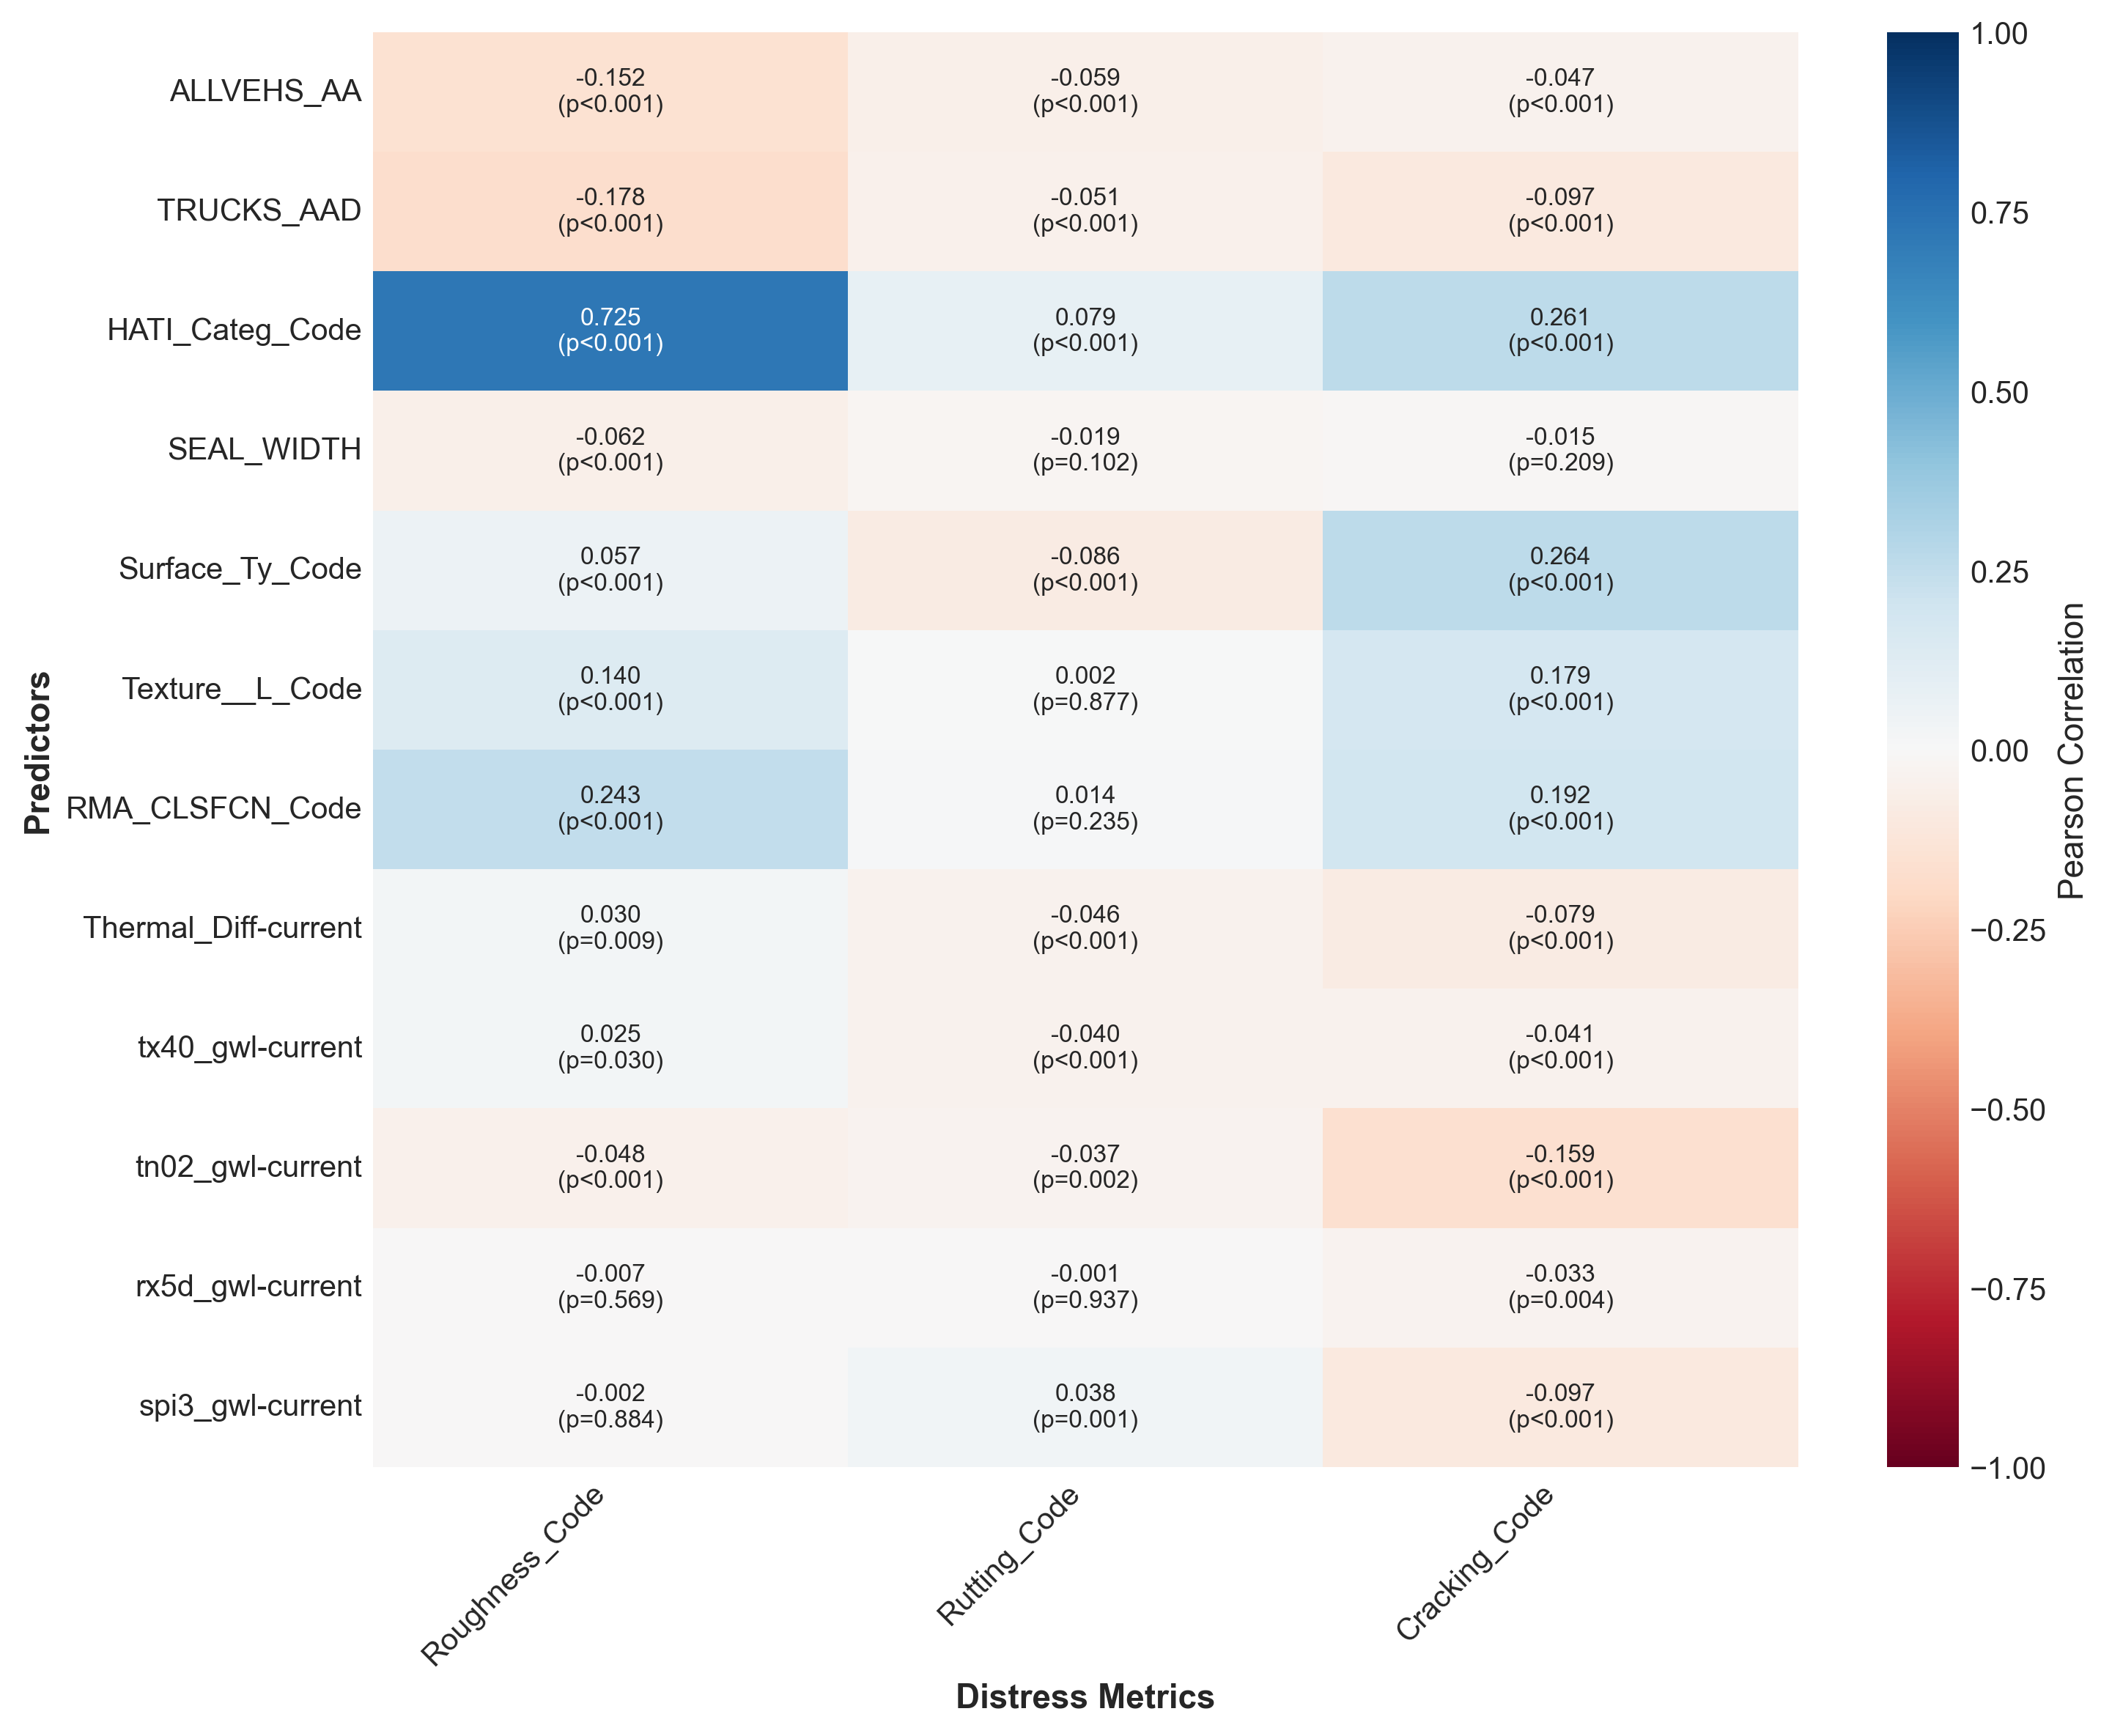

2025-10-31 09:15:38,171 - INFO - Saved Pearson correlation heatmap to ../data/processed/model_dev\out_eda/correlation_heatmap_pearson_model_dev.png
2025-10-31 09:15:38,171 - INFO - Figures generated and saved to ../data/processed/model_dev\out_eda


[2025-10-31 09:15:38.171668] Figures generated and saved to ../data/processed/model_dev\out_eda


In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.stats import spearmanr, pearsonr
import numpy as np
import os
from datetime import datetime
import logging

run_id = "model_dev"
output_dir = f"../data/processed/{run_id}"
figure_dir = os.path.join(output_dir, "out_eda")
os.makedirs(figure_dir, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'../data/processed/{run_id}/out_eda/eda_visualisation.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set publication-quality styling
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['figure.dpi'] = 300

# Load pre-processed dataset
path_preproc = os.path.join(output_dir, f"gdf_road_clim_cln_final_{run_id}.geojson")
if not os.path.exists(path_preproc):
    logger.error(f"Input file {path_preproc} does not exist")
    raise FileNotFoundError(f"Input file {path_preproc} does not exist")
gdf = gpd.read_file(path_preproc)
logger.info(f"Loaded dataset with {len(gdf)} segments")

print(f"[{datetime.now()}] ---- Outputs from Exploratory Data Analysis ({run_id}) ----")

# Define distress metrics and predictors
distress_metrics = ["Roughness_Code", "Rutting_Code", "Cracking_Code"]
predictors = [
    "ALLVEHS_AA", "TRUCKS_AAD", "HATI_Categ_Code",
    "SEAL_WIDTH", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code",
    "Thermal_Diff-current", "tx40_gwl-current", "tn02_gwl-current",
    "rx5d_gwl-current", "spi3_gwl-current"
]

# Descriptive Statistics
print(f"[{datetime.now()}] Descriptive Statistics for Predictors:")
desc_stats = gdf[predictors].describe()
print(desc_stats.to_string())
logger.info(f"Descriptive Statistics for Predictors:\n{desc_stats.to_string()}")

# Distribution of Distress Metrics
print(f"[{datetime.now()}] Distribution of Distress Metrics:")
logger.info("Distribution of Distress Metrics:")
for metric in distress_metrics:
    print(f"\n{metric} Distribution:")
    dist = gdf[metric].value_counts(normalize=True).sort_index()
    print(dist.to_string())
    logger.info(f"{metric} Distribution:\n{dist.to_string()}")

# Compute Spearman and Pearson Correlations
spearman_r = pd.DataFrame(index=predictors, columns=distress_metrics)
spearman_p = pd.DataFrame(index=predictors, columns=distress_metrics)
pearson_r = pd.DataFrame(index=predictors, columns=distress_metrics)
pearson_p = pd.DataFrame(index=predictors, columns=distress_metrics)

for predictor in predictors:
    for distress in distress_metrics:
        r_s, p_s = spearmanr(gdf[predictor], gdf[distress])
        r_p, p_p = pearsonr(gdf[predictor], gdf[distress])
        spearman_r.loc[predictor, distress] = r_s
        spearman_p.loc[predictor, distress] = p_s
        pearson_r.loc[predictor, distress] = r_p
        pearson_p.loc[predictor, distress] = p_p

spearman_r = spearman_r.astype(float)
spearman_p = spearman_p.astype(float)
pearson_r = pearson_r.astype(float)
pearson_p = pearson_p.astype(float)

# Format Correlation Outputs
spearman_annot = pd.DataFrame(index=predictors, columns=distress_metrics, dtype=str)
pearson_annot = pd.DataFrame(index=predictors, columns=distress_metrics, dtype=str)

for predictor in predictors:
    for distress in distress_metrics:
        r_s = spearman_r.loc[predictor, distress]
        p_s = spearman_p.loc[predictor, distress]
        r_p = pearson_r.loc[predictor, distress]
        p_p = pearson_p.loc[predictor, distress]
        p_s_str = "p<0.001" if p_s < 0.001 else f"p={p_s:.3f}"
        p_p_str = "p<0.001" if p_p < 0.001 else f"p={p_p:.3f}"
        spearman_annot.loc[predictor, distress] = f"{r_s:.3f}\n({p_s_str})"
        pearson_annot.loc[predictor, distress] = f"{r_p:.3f}\n({p_p_str})"

print(f"[{datetime.now()}] Correlation Analysis (Spearman’s Rank):")
print(spearman_annot.to_string())
logger.info(f"Correlation Analysis (Spearman’s Rank):\n{spearman_annot.to_string()}")

print(f"[{datetime.now()}] Correlation Analysis (Pearson’s):")
print(pearson_annot.to_string())
logger.info(f"Correlation Analysis (Pearson’s):\n{pearson_annot.to_string()}")

# Spearman Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_r, annot=spearman_annot, fmt="", cmap="RdBu", center=0, vmin=-1, vmax=1,
            cbar_kws={"label": "Spearman Correlation"}, annot_kws={"size": 8})
# plt.title("Spearman Correlation Heatmap\n(Predictors vs. Distress Metrics)", fontsize=12, fontweight='bold', pad=20)
plt.xlabel("Distress Metrics", fontweight='bold')
plt.ylabel("Predictors", fontweight='bold')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f"correlation_heatmap_spearman_{run_id}.png"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(figure_dir, f"correlation_heatmap_spearman_{run_id}.pdf"), format='pdf', bbox_inches="tight")
plt.show()
logger.info(f"Saved Spearman correlation heatmap to {figure_dir}/correlation_heatmap_spearman_{run_id}.png")

# Pearson Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_r, annot=pearson_annot, fmt="", cmap="RdBu", center=0, vmin=-1, vmax=1,
            cbar_kws={"label": "Pearson Correlation"}, annot_kws={"size": 8})
# plt.title("Pearson Correlation Heatmap\n(Predictors vs. Distress Metrics)", fontsize=12, fontweight='bold', pad=20)
plt.xlabel("Distress Metrics", fontweight='bold')
plt.ylabel("Predictors", fontweight='bold')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f"correlation_heatmap_pearson_{run_id}.png"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(figure_dir, f"correlation_heatmap_pearson_{run_id}.pdf"), format='pdf', bbox_inches="tight")
plt.show()
logger.info(f"Saved Pearson correlation heatmap to {figure_dir}/correlation_heatmap_pearson_{run_id}.png")

print(f"[{datetime.now()}] Figures generated and saved to {figure_dir}")
logger.info(f"Figures generated and saved to {figure_dir}")


2025-10-31 09:15:43,649 - INFO - Loaded dataset with 7419 segments


[2025-10-31 09:15:43.649742] ---- Generating Figures for EDA (Section 4.4) ----


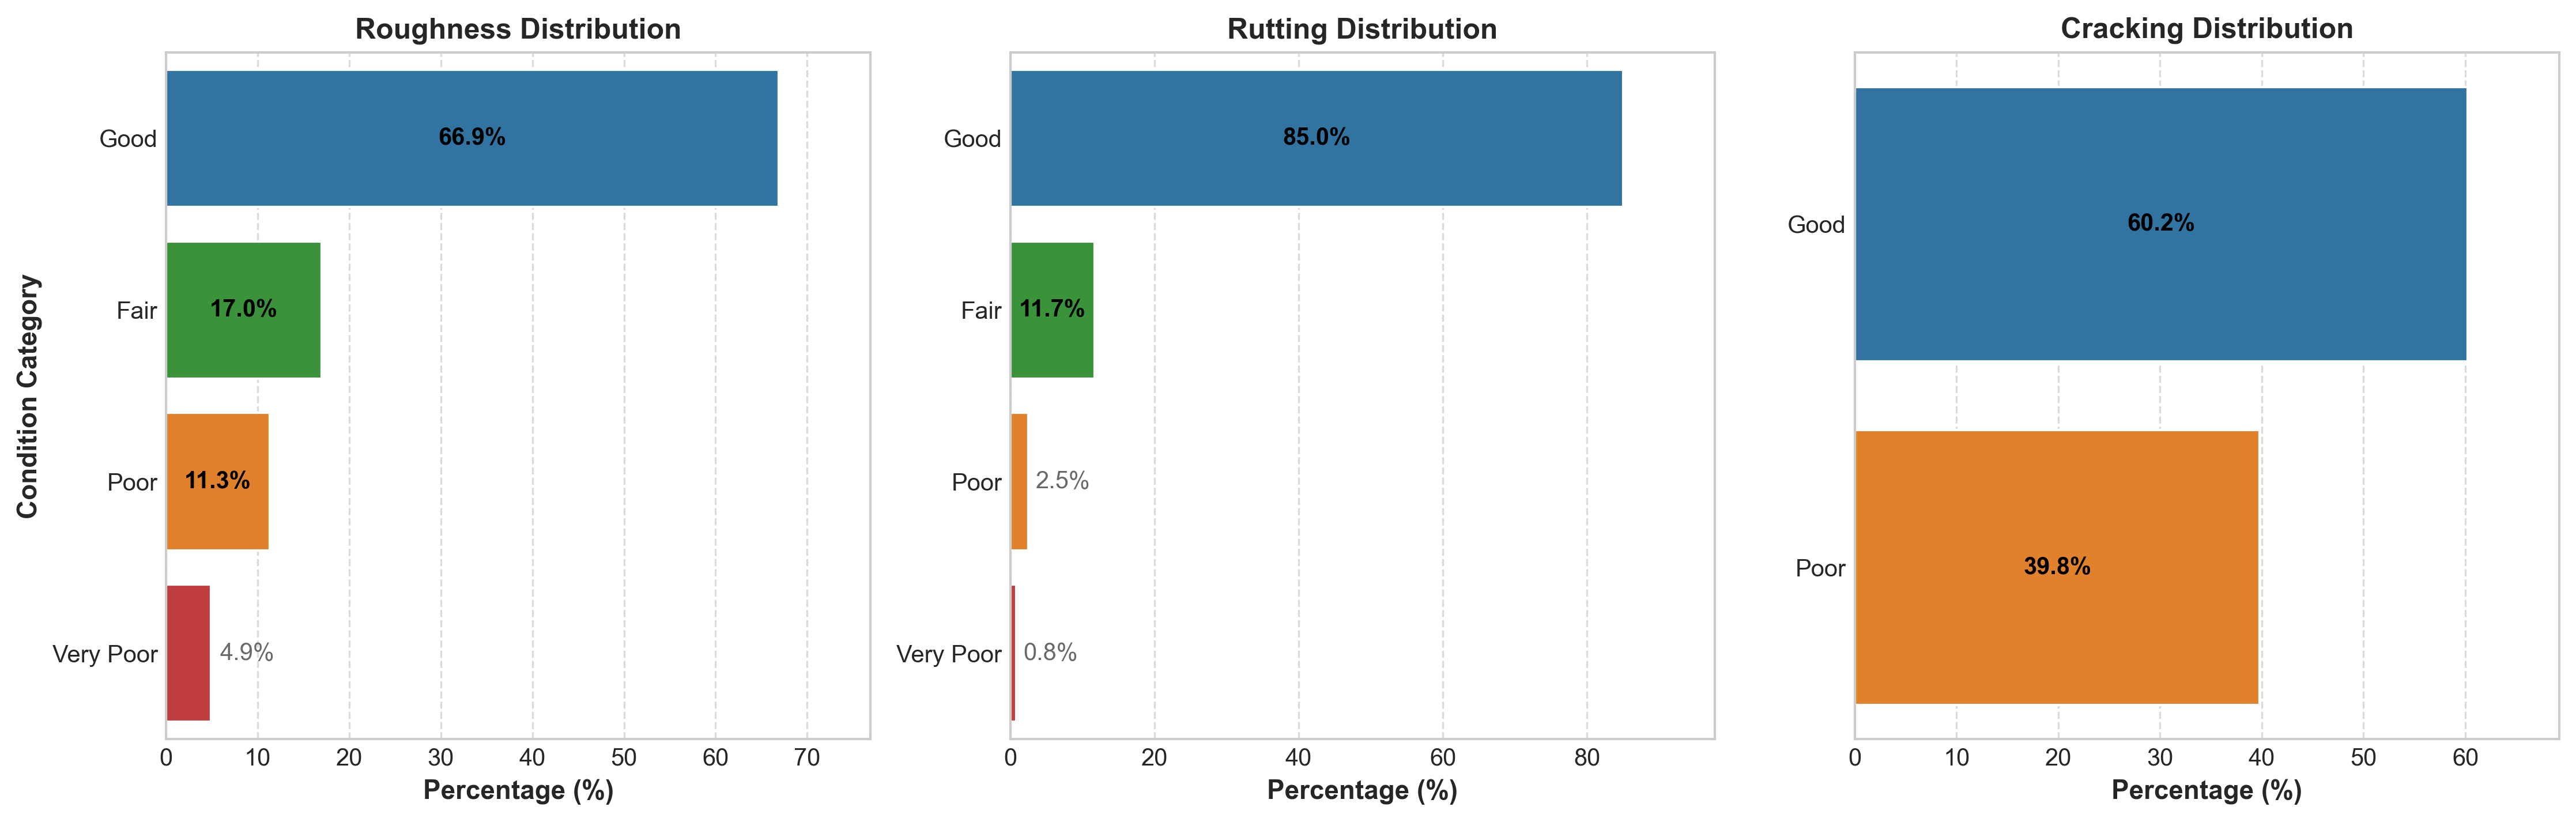

2025-10-31 09:15:44,542 - INFO - Saved distress distribution plot to ../data/processed/model_dev\out_eda/distress_distributions_model_dev.png


[2025-10-31 09:15:44.543454] Figure saved to ../data/processed/model_dev\out_eda/distress_distributions_model_dev.png


In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
from datetime import datetime
import logging

run_id = "model_dev"
output_dir = f"../data/processed/{run_id}"
figure_dir = os.path.join(output_dir, "out_eda")
os.makedirs(figure_dir, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'../data/processed/{run_id}/out_eda/eda_distributions.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set publication-quality styling
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['figure.dpi'] = 300

# Color palette for condition categories
colors = {
    'Good': '#1f77b4',      # Blue
    'Fair': '#2ca02c',      # Green
    'Poor': '#ff7f0e',      # Orange
    'Very Poor': '#d62728'  # Red
}

# Load pre-processed dataset
path_preproc = os.path.join(output_dir, f"gdf_road_clim_cln_final_{run_id}.geojson")
if not os.path.exists(path_preproc):
    logger.error(f"Input file {path_preproc} does not exist")
    raise FileNotFoundError(f"Input file {path_preproc} does not exist")
gdf = gpd.read_file(path_preproc)
logger.info(f"Loaded dataset with {len(gdf)} segments")

print(f"[{datetime.now()}] ---- Generating Figures for EDA (Section 4.4) ----")

# Define distress metrics and their labels
distress_metrics = ["Roughness_Code", "Rutting_Code", "Cracking_Code"]
distress_labels = {
    "Roughness_Code": {0: "Good", 1: "Fair", 2: "Poor", 3: "Very Poor"},
    "Rutting_Code": {0: "Good", 1: "Fair", 2: "Poor", 3: "Very Poor"},
    "Cracking_Code": {0: "Good", 1: "Poor"}
}
metric_titles = {
    "Roughness_Code": "Roughness Distribution",
    "Rutting_Code": "Rutting Distribution",
    "Cracking_Code": "Cracking Distribution"
}

# Distribution Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for idx, metric in enumerate(distress_metrics):
    counts = gdf[metric].value_counts().sort_index()
    percentages = (counts / counts.sum() * 100).round(1)
    labels = [distress_labels[metric][i] for i in counts.index]
    plot_colors = [colors[label] for label in labels]

    # Use barplot with hue to fix deprecation warning
    sns.barplot(x=percentages, y=labels, hue=labels, palette=colors, ax=axes[idx], legend=False)

    # Add percentage labels
    for i, p in enumerate(percentages):
        text_color = 'black'
        if p > 10:
            axes[idx].text(p/2, i, f"{p:.1f}%", ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)
        else:
            axes[idx].text(p + 1, i, f"{p:.1f}%", ha='left', va='center', fontsize=10, color='dimgray')

    axes[idx].set_title(metric_titles[metric], fontweight='bold')
    axes[idx].set_xlabel("Percentage (%)", fontweight='bold')
    if idx == 0:
        axes[idx].set_ylabel("Condition Category", fontweight='bold')
    else:
        axes[idx].set_ylabel("")
    max_percentage = percentages.max()
    axes[idx].set_xlim(0, max_percentage * 1.15)
    axes[idx].grid(axis='x', linestyle='--', alpha=0.7)
    axes[idx].set_axisbelow(True)

# fig.suptitle("Distribution of Road Surface Distress Metrics", fontsize=12, fontweight='bold', y=1.02)
# plt.figtext(0.5, -0.05, "Distribution of condition categories for the three distress metrics in the dataset.", ha='center', fontsize=10, style='italic')
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig(os.path.join(figure_dir, f"distress_distributions_{run_id}.png"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(figure_dir, f"distress_distributions_{run_id}.pdf"), format='pdf', bbox_inches="tight")
plt.show()
logger.info(f"Saved distress distribution plot to {figure_dir}/distress_distributions_{run_id}.png")
print(f"[{datetime.now()}] Figure saved to {figure_dir}/distress_distributions_{run_id}.png")

# Machine Learning (XGBoost and SHAP)

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import shap
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger
import imblearn
import sklearn
import warnings
from src.ricraf_dev import custom_weighted_smote

# Suppress FutureWarning for NumPy RNG and SHAP
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="shap")

# Create a NumPy random number generator
rng = np.random.default_rng(seed=42)


run_id = "model_dev"

# Configure loguru
log_file = f'../data/processed/{run_id}/ml_{run_id}.log'

logger.remove()
logger.add(log_file, format="{time:YYYY-MM-DD HH:mm:ss,SSS} - {level} - {message}", level="INFO")
logger.add(lambda msg: print(msg, end=""), format="{time:YYYY-MM-DD HH:mm:ss,SSS} - {level} - {message}", level="INFO")

# Set publication-quality styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 11
plt.rcParams['figure.dpi'] = 300

# Configuration
output_dir = os.path.join("..", "data", "processed", run_id)
os.makedirs(output_dir, exist_ok=True)
figure_dir = os.path.join(output_dir, "out_ml")
os.makedirs(figure_dir, exist_ok=True)
path_preproc = os.path.join(output_dir, f"gdf_road_clim_cln_final_{run_id}.geojson")
path_output_gdf = os.path.join(output_dir, f"gdf_road_clim_cln_final_with_distress_{run_id}.json")

logger.info("---- Machine Learning (XGBoost) Outputs for Run_ID: {} ----", run_id)
logger.info("Using imblearn version: {}", imblearn.__version__)
logger.info("Using scikit-learn version: {}", sklearn.__version__)

# Load data
logger.info("Loading data...")
gdf = gpd.read_file(path_preproc)
gdf['link_length_km'] = gdf['link_length'] / 1000

# Define predictors and CRA components
predictors_common = [
    "ALLVEHS_AA", "HATI_Categ_Code", "SEAL_WIDTH",
    "RMA_CLSFCN_Code", "Thermal_Diff-current", "tx40_gwl-current",
    "spi3_gwl-current"
]
predictors_roughness = predictors_common + ["tn02_gwl-current", "Texture__L_Code"]
predictors_rutting = predictors_common + ["rx5d_gwl-current", "Surface_Ty_Code", "TRUCKS_AAD"]
predictors_cracking = predictors_common + ["rx5d_gwl-current", "Surface_Ty_Code", "TRUCKS_AAD", "tn02_gwl-current", "Texture__L_Code"]
predictor_sets = {
    "Cracking_Code": predictors_cracking,
    "Roughness_Code": predictors_roughness,
    "Rutting_Code": predictors_rutting
}
categorical_cols = ["HATI_Categ_Code", "Surface_Ty_Code", "RMA_CLSFCN_Code", "Texture__L_Code"]
features_hazard = ['Thermal_Diff-current', 'tx40_gwl-current', 'spi3_gwl-current', 'tn02_gwl-current', 'rx5d_gwl-current']
features_exposure = ['ALLVEHS_AA', 'TRUCKS_AAD', 'HATI_Categ_Code']
features_vuln = ['SEAL_WIDTH', 'Surface_Ty_Code', "RMA_CLSFCN_Code", "Texture__L_Code"]

# Ensure categorical columns are typed correctly
for col in categorical_cols:
    if col in gdf.columns:
        gdf[col] = gdf[col].astype('category')

# Check missing values
logger.info("Missing values in gdf: {}", gdf[predictors_cracking + ['road_link_id', 'link_length']].isna().sum())

# Define bins for stratification
bins = [0, 1, 10, float('inf')]
labels = ['<1km', '1-10km', '>10km']
gdf['length_category'] = pd.cut(gdf['link_length_km'], bins=bins, labels=labels, include_lowest=True)
logger.info("Link length category distribution: {}", gdf['length_category'].value_counts())

# Prepare datasets
gdf['road_link_id'] = gdf['road_link_id'] if 'road_link_id' in gdf.columns else gdf.index
X_cracking = gdf[['road_link_id', 'link_length', 'length_category'] + predictors_cracking].copy()
X_roughness = gdf[['road_link_id', 'link_length', 'length_category'] + predictors_roughness].copy()
X_rutting = gdf[['road_link_id', 'link_length', 'length_category'] + predictors_rutting].copy()

for df in [X_cracking, X_roughness, X_rutting]:
    for col in categorical_cols + ['length_category']:
        if col in df.columns:
            df[col] = df[col].astype('category')

# Extract target variables
logger.info("Extracting target variables...")
y_cracking = gdf['Cracking_Code']
y_roughness = gdf['Roughness_Code']
y_rutting = gdf['Rutting_Code']

# Debug: Target distributions
logger.info("Cracking_Code distribution: {}", y_cracking.value_counts())
logger.info("Roughness_Code distribution: {}", y_roughness.value_counts())
logger.info("Rutting_Code distribution: {}", y_rutting.value_counts())

# Save dataset with distress columns
logger.info("Saving dataset with distress columns...")
gdf_with_distress = gdf.copy()
gdf_with_distress['y_cracking'] = y_cracking
gdf_with_distress['y_roughness'] = y_roughness
gdf_with_distress['y_rutting'] = y_rutting
logger.info("Created {} records", len(gdf_with_distress))
gdf_with_distress.to_file(path_output_gdf)
logger.info("Saved dataset to {}", path_output_gdf)

# Compute distress prevalence
logger.info("Computing distress prevalence...")
for distress in ['y_cracking', 'y_roughness', 'y_rutting']:
    for feature in ['Surface_Ty_Code', 'RMA_CLSFCN_Code']:
        prevalence = gdf_with_distress.groupby(feature, observed=True)[distress].mean()
        prevalence.to_csv(os.path.join(output_dir, f"{distress}_prevalence_{feature.lower()}_{run_id}.csv"))
        logger.info("{} prevalence by {}: {}", distress, feature, prevalence)

# Simplified stratification
logger.info("Splitting data with simplified stratification by length_category and RMA_CLSFCN_Code...")
stratify_cols = ['length_category', 'RMA_CLSFCN_Code']
gdf['stratify_key'] = gdf[stratify_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)
strat_counts = gdf['stratify_key'].value_counts()
valid_strata = strat_counts[strat_counts >= 2].index
gdf_valid = gdf[gdf['stratify_key'].isin(valid_strata)]
logger.info("Stratification key distribution after filtering: {}", gdf_valid['stratify_key'].value_counts())

try:
    X_train_cracking, X_test_cracking, y_train_cracking, y_test_cracking = train_test_split(
        X_cracking.loc[gdf_valid.index], y_cracking.loc[gdf_valid.index], test_size=0.2, random_state=42, stratify=gdf_valid['stratify_key'])
    X_train_roughness, X_test_roughness, y_train_roughness, y_test_roughness = train_test_split(
        X_roughness.loc[gdf_valid.index], y_roughness.loc[gdf_valid.index], test_size=0.2, random_state=42, stratify=gdf_valid['stratify_key'])
    X_train_rutting, X_test_rutting, y_train_rutting, y_test_rutting = train_test_split(
        X_rutting.loc[gdf_valid.index], y_rutting.loc[gdf_valid.index], test_size=0.2, random_state=42, stratify=gdf_valid['stratify_key'])
except ValueError as e:
    logger.warning("Stratification failed: {}. Falling back to length_category stratification.", str(e))
    X_train_cracking, X_test_cracking, y_train_cracking, y_test_cracking = train_test_split(
        X_cracking, y_cracking, test_size=0.2, random_state=42, stratify=gdf['length_category'])
    X_train_roughness, X_test_roughness, y_train_roughness, y_test_roughness = train_test_split(
        X_roughness, y_roughness, test_size=0.2, random_state=42, stratify=gdf['length_category'])
    X_train_rutting, X_test_rutting, y_train_rutting, y_test_rutting = train_test_split(
        X_rutting, y_rutting, test_size=0.2, random_state=42, stratify=gdf['length_category'])

# Debug: Check distributions
for col in categorical_cols:
    if col in X_train_cracking.columns:
        logger.info("Training set {} distribution by length_category:\n{}", col, pd.crosstab(X_train_cracking[col], X_train_cracking['length_category'], dropna=False))
        logger.info("Test set {} distribution by length_category:\n{}", col, pd.crosstab(X_test_cracking[col], X_test_cracking['length_category'], dropna=False))

# Compute prevalence-based weights with smoothing
def compute_categorical_weights(gdf, y, categorical_col, length_category_col='length_category', epsilon=5.0, max_weight=10.0):
    total_samples = len(gdf)
    num_categories = len(gdf[categorical_col].cat.categories)
    num_length_cats = len(gdf[length_category_col].cat.categories)
    prevalence = gdf.groupby([length_category_col, categorical_col], observed=True)[y.name].mean()
    weights = {}
    for cat_val in gdf[categorical_col].cat.categories:
        cat_weights = {}
        for length_cat in gdf[length_category_col].cat.categories:
            try:
                count = gdf[(gdf[length_category_col] == length_cat) & (gdf[categorical_col] == cat_val)].shape[0]
                weight = total_samples / (count * num_categories * num_length_cats + epsilon)
                cat_weights[length_cat] = min(weight, max_weight)
            except KeyError:
                cat_weights[length_cat] = 1.0
        weights[cat_val] = cat_weights
    return weights

# Compute link length weights
def compute_link_length_weights(gdf, length_col='link_length', epsilon=5.0):
    link_length_km = gdf[length_col] / 1000
    weights = 1.0 / (link_length_km + epsilon)
    weights = np.clip(weights, 0.1, 5.0)
    weights *= 0.5
    weights = weights / weights.mean()
    return weights

# Compute class-based sample weights
def compute_class_weights(y):
    class_counts = Counter(y)
    total_samples = len(y)
    n_classes = len(class_counts)
    weights = np.array([total_samples / (n_classes * class_counts[c]) for c in y])
    weights = weights / weights.mean()
    return weights

logger.info("Computing categorical weights for Roughness...")
weights_roughness_stage1 = {}
for col in ['HATI_Categ_Code', 'RMA_CLSFCN_Code']:
    weights_roughness_stage1[col] = compute_categorical_weights(gdf_with_distress, (y_roughness > 0).astype(int), col)
    logger.info("Categorical weights for {}: {}", col, weights_roughness_stage1[col])

logger.info("Computing categorical weights for Roughness Stage 2...")
weights_roughness_stage2 = {}
for col in ['HATI_Categ_Code', 'RMA_CLSFCN_Code']:
    weights_roughness_stage2[col] = compute_categorical_weights(gdf_with_distress[y_roughness > 0], y_roughness[y_roughness > 0] - 1, col)
    logger.info("Categorical weights for {}: {}", col, weights_roughness_stage2[col])

logger.info("Computing categorical weights for Rutting...")
weights_rutting_stage1 = {}
for col in ['HATI_Categ_Code', 'RMA_CLSFCN_Code', 'Surface_Ty_Code']:
    weights_rutting_stage1[col] = compute_categorical_weights(gdf_with_distress, (y_rutting > 0).astype(int), col)
    logger.info("Categorical weights for {}: {}", col, weights_rutting_stage1[col])

logger.info("Computing categorical weights for Rutting Stage 2...")
weights_rutting_stage2 = {}
for col in ['HATI_Categ_Code', 'RMA_CLSFCN_Code', 'Surface_Ty_Code']:
    weights_rutting_stage2[col] = compute_categorical_weights(gdf_with_distress[y_rutting > 0], y_rutting[y_rutting > 0] - 1, col)
    logger.info("Categorical weights for {}: {}", col, weights_rutting_stage2[col])

# Apply weights
def apply_categorical_weights(X, y, weights, categorical_cols, length_category_col='length_category'):
    sample_weights = np.ones(len(X))
    for col in categorical_cols:
        if col in X.columns:
            for idx, (cat_val, length_cat) in enumerate(zip(X[col], X[length_category_col])):
                weight = weights[col].get(cat_val, {}).get(length_cat, 1.0)
                sample_weights[idx] *= weight if not np.isnan(weight) else 1.0
    return sample_weights

# Compute sample weights for training sets
link_length_weights_train_cracking = compute_link_length_weights(X_train_cracking)
class_weights_train_cracking = compute_class_weights(y_train_cracking)
sample_weights_cracking = link_length_weights_train_cracking * class_weights_train_cracking
logger.info("Cracking sample weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
            np.min(sample_weights_cracking), np.max(sample_weights_cracking), np.mean(sample_weights_cracking))

link_length_weights_train_roughness = compute_link_length_weights(X_train_roughness)
sample_weights_roughness = apply_categorical_weights(X_train_roughness, y_train_roughness, weights_roughness_stage1, ['HATI_Categ_Code', 'RMA_CLSFCN_Code'])
sample_weights_roughness *= link_length_weights_train_roughness
logger.info("Roughness Stage 1 sample weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
            np.min(sample_weights_roughness), np.max(sample_weights_roughness), np.mean(sample_weights_roughness))

link_length_weights_train_rutting = compute_link_length_weights(X_train_rutting)
sample_weights_rutting = apply_categorical_weights(X_train_rutting, y_train_rutting, weights_rutting_stage1, ['HATI_Categ_Code', 'RMA_CLSFCN_Code', 'Surface_Ty_Code'])
sample_weights_rutting *= link_length_weights_train_rutting
logger.info("Rutting Stage 1 sample weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
            np.min(sample_weights_rutting), np.max(sample_weights_rutting), np.mean(sample_weights_rutting))

# Hyperparameter grid
param_grid = {
    'max_depth': [7],
    'n_estimators': [400],
    'learning_rate': [0.05],
    'colsample_bytree': [1.0],
    'subsample': [1.0]
}
param_grid_roughness = {
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'subsample': [0.5, 0.6, 0.8, 1.0]
}
param_grid_rutting_stage2 = {
    'max_depth': [5, 7, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# Train models
logger.info("Training models...")

# Cracking (Binary)
logger.info("Processing Cracking (Binary)...")
logger.info("Unique values in y_test_cracking: {}", np.unique(y_test_cracking))
X_train_cracking_features = X_train_cracking.drop(columns=['road_link_id', 'link_length', 'length_category'])
X_train_cracking_features_resampled, y_train_cracking_resampled, sample_weights_cracking_resampled = custom_weighted_smote(
    X_train_cracking_features, y_train_cracking, sample_weights_cracking, random_state=42, k_neighbors=5, sampling_strategy='auto'
)
logger.info("Cracking class distribution before custom SMOTE: {}", pd.Series(y_train_cracking).value_counts().to_dict())
logger.info("Cracking class distribution after custom SMOTE: {}", pd.Series(y_train_cracking_resampled).value_counts().to_dict())
logger.info("Cracking resampled weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
            np.min(sample_weights_cracking_resampled), np.max(sample_weights_cracking_resampled),
            np.mean(sample_weights_cracking_resampled))

grid_search_cracking = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=42, enable_categorical=True),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_search_cracking.fit(X_train_cracking_features_resampled, y_train_cracking_resampled,
                         sample_weight=sample_weights_cracking_resampled)
model_cracking = grid_search_cracking.best_estimator_
logger.info("Best parameters for Cracking: {}", grid_search_cracking.best_params_)
y_pred_cracking = model_cracking.predict(X_test_cracking.drop(columns=['road_link_id', 'link_length', 'length_category']))
model_cracking.save_model(os.path.join(output_dir, "model_cracking.json"))
logger.info("Saved cracking model to {}", os.path.join(output_dir, "model_cracking.json"))
logger.info("Cracking accuracy: {:.4f}", accuracy_score(y_test_cracking, y_pred_cracking))
logger.info("Cracking F1-Weighted: {:.4f}", f1_score(y_test_cracking, y_pred_cracking, average='weighted'))
logger.info("Cracking F1-Macro: {:.4f}", f1_score(y_test_cracking, y_pred_cracking, average='macro'))

# Roughness (Two-Stage)
logger.info("Processing Roughness (Two-Stage)...")
y_train_roughness_stage1 = (y_train_roughness > 0).astype(int)
y_test_roughness_stage1 = (y_test_roughness > 0).astype(int)
X_train_roughness_features = X_train_roughness.drop(columns=['road_link_id', 'link_length', 'length_category'])
X_test_roughness_features = X_test_roughness.drop(columns=['road_link_id', 'link_length', 'length_category'])
X_roughness_features = X_roughness.drop(columns=['road_link_id', 'link_length', 'length_category'])
grid_search_roughness_stage1 = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=42, enable_categorical=True),
    param_grid_roughness, cv=5, scoring='f1_macro', n_jobs=-1
)
grid_search_roughness_stage1.fit(X_train_roughness_features, y_train_roughness_stage1,
                                 sample_weight=sample_weights_roughness)
model_roughness_stage1 = grid_search_roughness_stage1.best_estimator_
logger.info("Best parameters for Roughness Stage 1: {}", grid_search_roughness_stage1.best_params_)
y_pred_proba_roughness_stage1 = model_roughness_stage1.predict_proba(X_test_roughness_features)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_roughness_stage1, y_pred_proba_roughness_stage1)
optimal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-9))]
adjusted_threshold = min(0.5, optimal_threshold * 1.0)  # Adjusted multiplier
y_pred_roughness_stage1 = (y_pred_proba_roughness_stage1 >= adjusted_threshold).astype(int)
model_roughness_stage1.save_model(os.path.join(output_dir, "model_roughness_stage1.json"))
logger.info("Saved roughness stage 1 model to {}", os.path.join(output_dir, "model_roughness_stage1.json"))
logger.info("Roughness Stage 1 accuracy: {:.4f}", accuracy_score(y_test_roughness_stage1, y_pred_roughness_stage1))
logger.info("Roughness Stage 1 F1-Weighted: {:.4f}", f1_score(y_test_roughness_stage1, y_pred_roughness_stage1, average='weighted'))
logger.info("Roughness Stage 1 F1-Macro: {:.4f}", f1_score(y_test_roughness_stage1, y_pred_roughness_stage1, average='macro'))

distress_train_idx_roughness = y_train_roughness > 0
distress_test_idx_roughness = y_pred_roughness_stage1 > 0
X_train_roughness_stage2 = X_train_roughness_features[distress_train_idx_roughness]
y_train_roughness_stage2 = y_train_roughness[distress_train_idx_roughness] - 1
X_test_roughness_stage2 = X_test_roughness_features[distress_test_idx_roughness]
y_test_roughness_stage2 = y_test_roughness[distress_test_idx_roughness] - 1
valid_mask = (y_test_roughness_stage2 >= 0)
X_test_roughness_stage2 = X_test_roughness_stage2[valid_mask]
y_test_roughness_stage2 = y_test_roughness[distress_test_idx_roughness][valid_mask]
X_test_roughness_stage2_link_ids = X_test_roughness['road_link_id'][distress_test_idx_roughness][valid_mask]
sample_weights_roughness_stage2 = apply_categorical_weights(
    X_train_roughness[distress_train_idx_roughness], y_train_roughness[distress_train_idx_roughness],
    weights_roughness_stage2, ['HATI_Categ_Code', 'RMA_CLSFCN_Code'])
sample_weights_roughness_stage2 *= link_length_weights_train_roughness[distress_train_idx_roughness]
class_weights_roughness_stage2 = compute_class_weights(y_train_roughness_stage2)
sample_weights_roughness_stage2 *= class_weights_roughness_stage2
logger.info("Roughness Stage 2 sample weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
            np.min(sample_weights_roughness_stage2), np.max(sample_weights_roughness_stage2), np.mean(sample_weights_roughness_stage2))
logger.info("Unique values in y_train_roughness_stage2: {}", np.unique(y_train_roughness_stage2))
logger.info("Unique values in y_test_roughness_stage2: {}", np.unique(y_test_roughness_stage2))

if len(X_test_roughness_stage2) == 0:
    logger.warning("No samples for Roughness Stage 2 test set. Setting y_pred_roughness to zeros.")
    y_pred_roughness = np.zeros(len(y_test_roughness), dtype=int)
else:
    X_train_roughness_stage2_resampled, y_train_roughness_stage2_resampled, sample_weights_roughness_stage2_resampled = custom_weighted_smote(
        X_train_roughness_stage2, y_train_roughness_stage2, sample_weights_roughness_stage2, random_state=42, k_neighbors=5, sampling_strategy=0.3)  # Adjusted
    logger.info("Roughness Stage 2 class distribution before custom SMOTE: {}",
                pd.Series(y_train_roughness[distress_train_idx_roughness] - 1).value_counts().to_dict())
    logger.info("Roughness Stage 2 class distribution after custom SMOTE: {}",
                pd.Series(y_train_roughness_stage2_resampled).value_counts().to_dict())
    logger.info("Roughness Stage 2 resampled weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
                np.min(sample_weights_roughness_stage2_resampled), np.max(sample_weights_roughness_stage2_resampled),
                np.mean(sample_weights_roughness_stage2_resampled))
    grid_search_roughness_stage2 = GridSearchCV(
        xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, enable_categorical=True),
        param_grid_roughness, cv=5, scoring='f1_macro', n_jobs=-1
    )
    grid_search_roughness_stage2.fit(X_train_roughness_stage2_resampled, y_train_roughness_stage2_resampled,
                                     sample_weight=sample_weights_roughness_stage2_resampled)
    model_roughness_stage2 = grid_search_roughness_stage2.best_estimator_
    logger.info("Best parameters for Roughness Stage 2: {}", grid_search_roughness_stage2.best_params_)
    y_pred_roughness_stage2 = model_roughness_stage2.predict(X_test_roughness_stage2)
    y_pred_roughness_stage2 = y_pred_roughness_stage2 + 1
    model_roughness_stage2.save_model(os.path.join(output_dir, "model_roughness_stage2.json"))
    logger.info("Saved roughness stage 2 model to {}", os.path.join(output_dir, "model_roughness_stage2.json"))
    logger.info("Roughness Stage 2 accuracy: {:.4f}", accuracy_score(y_test_roughness_stage2, y_pred_roughness_stage2))
    logger.info("Roughness Stage 2 F1-Weighted: {:.4f}", f1_score(y_test_roughness_stage2, y_pred_roughness_stage2, average='weighted'))
    logger.info("Roughness Stage 2 F1-Macro: {:.4f}", f1_score(y_test_roughness_stage2, y_pred_roughness_stage2, average='macro'))
    y_pred_roughness = np.zeros(len(y_test_roughness), dtype=int)
    distress_test_indices_roughness = np.where(distress_test_idx_roughness)[0][valid_mask]
    y_pred_roughness[distress_test_indices_roughness] = y_pred_roughness_stage2

# Rutting (Two-Stage)
logger.info("Processing Rutting (Two-Stage)...")
y_train_rutting_stage1 = (y_train_rutting > 0).astype(int)
y_test_rutting_stage1 = (y_test_rutting > 0).astype(int)
X_train_rutting_features = X_train_rutting.drop(columns=['road_link_id', 'link_length', 'length_category'])
X_test_rutting_features = X_test_rutting.drop(columns=['road_link_id', 'link_length', 'length_category'])
X_rutting_features = X_rutting.drop(columns=['road_link_id', 'link_length', 'length_category'])
grid_search_rutting_stage1 = GridSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=42, enable_categorical=True),
    param_grid_roughness, cv=5, scoring='f1_macro', n_jobs=-1
)
grid_search_rutting_stage1.fit(X_train_rutting_features, y_train_rutting_stage1,
                               sample_weight=sample_weights_rutting)
model_rutting_stage1 = grid_search_rutting_stage1.best_estimator_
logger.info("Best parameters for Rutting Stage 1: {}", grid_search_rutting_stage1.best_params_)
y_pred_proba_rutting_stage1 = model_rutting_stage1.predict_proba(X_test_rutting_features)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_rutting_stage1, y_pred_proba_rutting_stage1)
optimal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-9))]
adjusted_threshold = min(0.5, optimal_threshold * 1.1)
y_pred_rutting_stage1 = (y_pred_proba_rutting_stage1 >= adjusted_threshold).astype(int)
model_rutting_stage1.save_model(os.path.join(output_dir, "model_rutting_stage1.json"))
logger.info("Saved rutting stage 1 model to {}", os.path.join(output_dir, "model_rutting_stage1.json"))
logger.info("Rutting Stage 1 accuracy: {:.4f}", accuracy_score(y_test_rutting_stage1, y_pred_rutting_stage1))
logger.info("Rutting Stage 1 F1-Weighted: {:.4f}", f1_score(y_test_rutting_stage1, y_pred_rutting_stage1, average='weighted'))
logger.info("Rutting Stage 1 F1-Macro: {:.4f}", f1_score(y_test_rutting_stage1, y_pred_rutting_stage1, average='macro'))

distress_train_idx_rutting = y_train_rutting > 0
distress_test_idx_rutting = y_pred_rutting_stage1 > 0
X_train_rutting_stage2 = X_train_rutting_features[distress_train_idx_rutting]
y_train_rutting_stage2 = y_train_rutting[distress_train_idx_rutting] - 1
X_test_rutting_stage2 = X_test_rutting_features[distress_test_idx_rutting]
y_test_rutting_stage2 = y_test_rutting[distress_test_idx_rutting] - 1
valid_mask = (y_test_rutting_stage2 >= 0)
X_test_rutting_stage2 = X_test_rutting_stage2[valid_mask]
y_test_rutting_stage2 = y_test_rutting[distress_test_idx_rutting][valid_mask]
X_test_rutting_stage2_link_ids = X_test_rutting['road_link_id'][distress_test_idx_rutting][valid_mask]
sample_weights_rutting_stage2 = apply_categorical_weights(
    X_train_rutting[distress_train_idx_rutting], y_train_rutting[distress_train_idx_rutting],
    weights_rutting_stage2, ['HATI_Categ_Code', 'RMA_CLSFCN_Code', 'Surface_Ty_Code'])
sample_weights_rutting_stage2 *= link_length_weights_train_rutting[distress_train_idx_rutting]
class_weights_rutting_stage2 = compute_class_weights(y_train_rutting_stage2)
sample_weights_rutting_stage2 *= class_weights_rutting_stage2
logger.info("Rutting Stage 2 sample weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
            np.min(sample_weights_rutting_stage2), np.max(sample_weights_rutting_stage2), np.mean(sample_weights_rutting_stage2))
logger.info("Unique values in y_train_rutting_stage2: {}", np.unique(y_train_rutting_stage2))
logger.info("Unique values in y_test_rutting_stage2: {}", np.unique(y_test_rutting_stage2))

if len(X_test_rutting_stage2) == 0:
    logger.warning("No samples for Rutting Stage 2 test set. Setting y_pred_rutting to zeros.")
    y_pred_rutting = np.zeros(len(y_test_rutting), dtype=int)
else:
    X_train_rutting_stage2_resampled, y_train_rutting_stage2_resampled, sample_weights_rutting_stage2_resampled = custom_weighted_smote(
        X_train_rutting_stage2, y_train_rutting_stage2, sample_weights_rutting_stage2, random_state=42, k_neighbors=3, sampling_strategy=0.7)  # Adjusted
    logger.info("Rutting Stage 2 class distribution before custom SMOTE: {}",
                pd.Series(y_train_rutting[distress_train_idx_rutting] - 1).value_counts().to_dict())
    logger.info("Rutting Stage 2 class distribution after custom SMOTE: {}",
                pd.Series(y_train_rutting_stage2_resampled).value_counts().to_dict())
    logger.info("Rutting Stage 2 resampled weights statistics: min={:.4f}, max={:.4f}, mean={:.4f}",
                np.min(sample_weights_rutting_stage2_resampled), np.max(sample_weights_rutting_stage2_resampled),
                np.mean(sample_weights_rutting_stage2_resampled))
    grid_search_rutting_stage2 = GridSearchCV(
        xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, enable_categorical=True),
        param_grid_rutting_stage2, cv=5, scoring='f1_macro', n_jobs=-1
    )
    grid_search_rutting_stage2.fit(X_train_rutting_stage2_resampled, y_train_rutting_stage2_resampled,
                                   sample_weight=sample_weights_rutting_stage2_resampled)
    model_rutting_stage2 = grid_search_rutting_stage2.best_estimator_
    logger.info("Best parameters for Rutting Stage 2: {}", grid_search_rutting_stage2.best_params_)
    y_pred_rutting_stage2 = model_rutting_stage2.predict(X_test_rutting_stage2)
    y_pred_rutting_stage2 = y_pred_rutting_stage2 + 1
    model_rutting_stage2.save_model(os.path.join(output_dir, "model_rutting_stage2.json"))
    logger.info("Saved rutting stage 2 model to {}", os.path.join(output_dir, "model_rutting_stage2.json"))
    logger.info("Rutting Stage 2 accuracy: {:.4f}", accuracy_score(y_test_rutting_stage2, y_pred_rutting_stage2))
    logger.info("Rutting Stage 2 F1-Weighted: {:.4f}", f1_score(y_test_rutting_stage2, y_pred_rutting_stage2, average='weighted'))
    logger.info("Rutting Stage 2 F1-Macro: {:.4f}", f1_score(y_test_rutting_stage2, y_pred_rutting_stage2, average='macro'))
    y_pred_rutting = np.zeros(len(y_test_rutting), dtype=int)
    distress_test_indices_rutting = np.where(distress_test_idx_rutting)[0][valid_mask]
    y_pred_rutting[distress_test_indices_rutting] = y_pred_rutting_stage2

# Evaluation metrics
logger.info("Evaluation Metrics:")
metrics = {}
for distress, y_test, y_pred in [
    ("Cracking", y_test_cracking, y_pred_cracking),
    ("Roughness", y_test_roughness, y_pred_roughness),
    ("Rutting", y_test_rutting, y_pred_rutting)
]:
    metrics[distress] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'Confusion_Matrix': confusion_matrix(y_test, y_pred).tolist(),
        'Classification_Report': classification_report(y_test, y_pred, output_dict=True)
    }
    logger.info("\n{}:", distress)
    logger.info("Accuracy: {:.4f}", metrics[distress]['Accuracy'])
    logger.info("F1-Score (Weighted): {:.4f}", metrics[distress]['F1_Weighted'])
    logger.info("F1-Score (Macro): {:.4f}", metrics[distress]['F1_Macro'])
    logger.info("Confusion Matrix: {}", metrics[distress]['Confusion_Matrix'])
    logger.info("Classification Report: {}", metrics[distress]['Classification_Report'])

with open(os.path.join(output_dir, f"model_metrics_{run_id}.json"), 'w') as f:
    json.dump(metrics, f, indent=2)
logger.info("Saved model metrics to {}", os.path.join(output_dir, f"model_metrics_{run_id}.json"))

# Compute SHAP values
logger.info("Computing SHAP values...")
explainer_cracking = shap.TreeExplainer(model_cracking)
explainer_roughness_stage1 = shap.TreeExplainer(model_roughness_stage1)
explainer_roughness_stage2 = shap.TreeExplainer(model_roughness_stage2)
explainer_rutting_stage1 = shap.TreeExplainer(model_rutting_stage1)
explainer_rutting_stage2 = shap.TreeExplainer(model_rutting_stage2)

# Test set SHAP values
X_test_cracking_features = X_test_cracking.drop(columns=['road_link_id', 'link_length', 'length_category'])
shap_values_cracking_test = explainer_cracking.shap_values(X_test_cracking_features)
X_test_roughness_features = X_test_roughness.drop(columns=['road_link_id', 'link_length', 'length_category'])
shap_values_roughness_stage1_test = explainer_roughness_stage1.shap_values(X_test_roughness_features)
shap_values_roughness_stage2_test = explainer_roughness_stage2.shap_values(X_test_roughness_stage2)
if len(X_test_roughness_stage2) > 0:
    shap_values_roughness_stage2_test = np.array(shap_values_roughness_stage2_test)[:, :, 1]
else:
    shap_values_roughness_stage2_test = np.zeros((0, X_test_roughness_stage2.shape[1]))
X_test_rutting_features = X_test_rutting.drop(columns=['road_link_id', 'link_length', 'length_category'])
shap_values_rutting_stage1_test = explainer_rutting_stage1.shap_values(X_test_rutting_features)
shap_values_rutting_stage2_test = explainer_rutting_stage2.shap_values(X_test_rutting_stage2)
if len(X_test_rutting_stage2) > 0:
    shap_values_rutting_stage2_test = np.array(shap_values_rutting_stage2_test)[:, :, 1]
else:
    shap_values_rutting_stage2_test = np.zeros((0, X_test_rutting_stage2.shape[1]))

# Full dataset SHAP values
X_cracking_features = X_cracking.drop(columns=['road_link_id', 'link_length', 'length_category'])
shap_values_cracking_full = explainer_cracking.shap_values(X_cracking_features)
X_roughness_features = X_roughness.drop(columns=['road_link_id', 'link_length', 'length_category'])
shap_values_roughness_stage1_full = explainer_roughness_stage1.shap_values(X_roughness_features)
distress_full_idx_roughness = y_roughness > 0
X_roughness_stage2_full = X_roughness_features[distress_full_idx_roughness]
shap_values_roughness_stage2_full = explainer_roughness_stage2.shap_values(X_roughness_stage2_full)
if len(X_roughness_stage2_full) > 0:
    shap_values_roughness_stage2_full = np.array(shap_values_roughness_stage2_full)[:, :, 1]
else:
    shap_values_roughness_stage2_full = np.zeros((0, X_roughness_stage2_full.shape[1]))
X_rutting_features = X_rutting.drop(columns=['road_link_id', 'link_length', 'length_category'])
shap_values_rutting_stage1_full = explainer_rutting_stage1.shap_values(X_rutting_features)
distress_full_idx_rutting = y_rutting > 0
X_rutting_stage2_full = X_rutting_features[distress_full_idx_rutting]
shap_values_rutting_stage2_full = explainer_rutting_stage2.shap_values(X_rutting_stage2_full)
if len(X_rutting_stage2_full) > 0:
    shap_values_rutting_stage2_full = np.array(shap_values_rutting_stage2_full)[:, :, 1]
else:
    shap_values_rutting_stage2_full = np.zeros((0, X_rutting_stage2_full.shape[1]))

logger.info("Shape of shap_values_cracking_test: {}", np.shape(shap_values_cracking_test))
logger.info("Shape of shap_values_roughness_stage1_test: {}", np.shape(shap_values_roughness_stage1_test))
logger.info("Shape of shap_values_roughness_stage2_test: {}", np.shape(shap_values_roughness_stage2_test))
logger.info("Shape of shap_values_rutting_stage1_test: {}", np.shape(shap_values_rutting_stage1_test))
logger.info("Shape of shap_values_rutting_stage2_test: {}", np.shape(shap_values_rutting_stage2_test))
logger.info("Shape of shap_values_cracking_full: {}", np.shape(shap_values_cracking_full))
logger.info("Shape of shap_values_roughness_stage1_full: {}", np.shape(shap_values_roughness_stage1_full))
logger.info("Shape of shap_values_roughness_stage2_full: {}", np.shape(shap_values_roughness_stage2_full))
logger.info("Shape of shap_values_rutting_stage1_full: {}", np.shape(shap_values_rutting_stage1_full))
logger.info("Shape of shap_values_rutting_stage2_full: {}", np.shape(shap_values_rutting_stage2_full))

# Log feature sets
logger.info("Cracking features: {}", X_test_cracking_features.columns.tolist())
logger.info("Roughness features: {}", X_test_roughness_features.columns.tolist())
logger.info("Rutting features: {}", X_test_rutting_features.columns.tolist())

# Save SHAP values
logger.info("Preparing SHAP DataFrames for test set...")
shap_dfs_test = {
    "Cracking": pd.DataFrame(shap_values_cracking_test, columns=[f"SHAP_{col}" for col in X_test_cracking_features.columns], index=X_test_cracking.index).assign(
        road_link_id=X_test_cracking['road_link_id'], y_cracking=y_test_cracking
    ),
    "Roughness_Stage1": pd.DataFrame(shap_values_roughness_stage1_test, columns=[f"SHAP_{col}" for col in X_test_roughness_features.columns], index=X_test_roughness.index).assign(
        road_link_id=X_test_roughness['road_link_id'], y_roughness=y_test_roughness
    ),
    "Roughness_Stage2": pd.DataFrame(
        shap_values_roughness_stage2_test, columns=[f"SHAP_{col}" for col in X_test_roughness_stage2.columns], index=X_test_roughness_stage2_link_ids.index
    ).assign(
        road_link_id=X_test_roughness_stage2_link_ids.values, y_roughness=y_test_roughness.iloc[distress_test_indices_roughness]
    ),
    "Rutting_Stage1": pd.DataFrame(shap_values_rutting_stage1_test, columns=[f"SHAP_{col}" for col in X_test_rutting_features.columns], index=X_test_rutting.index).assign(
        road_link_id=X_test_rutting['road_link_id'], y_rutting=y_test_rutting
    ),
    "Rutting_Stage2": pd.DataFrame(
        shap_values_rutting_stage2_test, columns=[f"SHAP_{col}" for col in X_test_rutting_stage2.columns], index=X_test_rutting_stage2_link_ids.index
    ).assign(
        road_link_id=X_test_rutting_stage2_link_ids.values, y_rutting=y_test_rutting.iloc[distress_test_indices_rutting]
    )
}

logger.info("Saving test set SHAP values...")
for distress, df in shap_dfs_test.items():
    path_shap = os.path.join(output_dir, f"shap_values_{distress.lower()}_test.csv")
    df.to_csv(path_shap, index=False)
    logger.info("Saved test set SHAP values to {}", path_shap)

logger.info("Saving full dataset SHAP values...")
shap_dfs_full = {
    "Cracking": pd.DataFrame(shap_values_cracking_full, columns=[f"SHAP_{col}" for col in X_cracking_features.columns], index=X_cracking.index).assign(
        road_link_id=X_cracking['road_link_id'], y_cracking=y_cracking
    ),
    "Roughness_Stage1": pd.DataFrame(shap_values_roughness_stage1_full, columns=[f"SHAP_{col}" for col in X_roughness_features.columns], index=X_roughness.index).assign(
        road_link_id=X_roughness['road_link_id'], y_roughness=y_roughness
    ),
    "Roughness_Stage2": pd.DataFrame(
        shap_values_roughness_stage2_full, columns=[f"SHAP_{col}" for col in X_roughness_stage2_full.columns], index=X_roughness[distress_full_idx_roughness].index
    ).assign(
        road_link_id=X_roughness['road_link_id'][distress_full_idx_roughness], y_roughness=y_roughness[distress_full_idx_roughness]
    ),
    "Rutting_Stage1": pd.DataFrame(shap_values_rutting_stage1_full, columns=[f"SHAP_{col}" for col in X_rutting_features.columns], index=X_rutting.index).assign(
        road_link_id=X_rutting['road_link_id'], y_rutting=y_rutting
    ),
    "Rutting_Stage2": pd.DataFrame(
        shap_values_rutting_stage2_full, columns=[f"SHAP_{col}" for col in X_rutting_stage2_full.columns], index=X_rutting[distress_full_idx_rutting].index
    ).assign(
        road_link_id=X_rutting['road_link_id'][distress_full_idx_rutting], y_rutting=y_rutting[distress_full_idx_rutting]
    )
}

for distress, df in shap_dfs_full.items():
    path_shap = os.path.join(output_dir, f"shap_values_{distress.lower()}_full.csv")
    df.to_csv(path_shap, index=False)
    logger.info("Saved full dataset SHAP values to {}", path_shap)

# SHAP sensitivity for >10km links
logger.info("Computing SHAP sensitivity for >10km links...")
long_links_mask = X_test_cracking['length_category'] == '>10km'
shap_values_cracking_long_links = explainer_cracking.shap_values(X_test_cracking_features[long_links_mask])
shap_values_roughness_stage1_long_links = explainer_roughness_stage1.shap_values(X_test_roughness_features[long_links_mask])
shap_values_rutting_stage1_long_links = explainer_rutting_stage1.shap_values(X_test_rutting_features[long_links_mask])

# Unified feature index
all_features = sorted(list(set(predictors_cracking + predictors_roughness + predictors_rutting)))
shap_cracking = np.zeros(len(all_features))
shap_roughness = np.zeros(len(all_features))
shap_rutting = np.zeros(len(all_features))

if len(shap_values_cracking_long_links) > 0:
    for i, feature in enumerate(X_test_cracking_features.columns):
        idx = all_features.index(feature)
        shap_cracking[idx] = np.abs(shap_values_cracking_long_links).mean(axis=0)[i]

if len(shap_values_roughness_stage1_long_links) > 0:
    for i, feature in enumerate(X_test_roughness_features.columns):
        idx = all_features.index(feature)
        shap_roughness[idx] = np.abs(shap_values_roughness_stage1_long_links).mean(axis=0)[i]

if len(shap_values_rutting_stage1_long_links) > 0:
    for i, feature in enumerate(X_test_rutting_features.columns):
        idx = all_features.index(feature)
        shap_rutting[idx] = np.abs(shap_values_rutting_stage1_long_links).mean(axis=0)[i]

shap_comparison_long_links = pd.DataFrame({
    'Cracking': shap_cracking,
    'Roughness_Stage1': shap_roughness,
    'Rutting_Stage1': shap_rutting
}, index=all_features)
shap_comparison_long_links.to_csv(os.path.join(output_dir, f"shap_comparison_long_links_{run_id}.csv"))
logger.info("Saved SHAP comparison for >10km links to {}", os.path.join(output_dir, f"shap_comparison_long_links_{run_id}.csv"))

# Compute unified SHAP weights
logger.info("Computing unified SHAP weights...")
unified_shap = pd.DataFrame(0.0, index=all_features, columns=['Mean_Abs_SHAP', 'Normalized_SHAP'])
for feature, value in zip(X_test_cracking_features.columns, np.abs(shap_values_cracking_test).mean(axis=0)):
    unified_shap.loc[feature, 'Mean_Abs_SHAP'] += value / 3
for feature, value in zip(X_test_roughness_features.columns, np.abs(shap_values_roughness_stage1_test).mean(axis=0) * (1 - (y_test_roughness > 0).mean()) +
                                                             np.abs(shap_values_roughness_stage2_test).mean(axis=0) * (y_test_roughness > 0).mean()):
    unified_shap.loc[feature, 'Mean_Abs_SHAP'] += value / 3
for feature, value in zip(X_test_rutting_features.columns, np.abs(shap_values_rutting_stage1_test).mean(axis=0) * (1 - (y_test_rutting > 0).mean()) +
                                                           np.abs(shap_values_rutting_stage2_test).mean(axis=0) * (y_test_rutting > 0).mean()):
    unified_shap.loc[feature, 'Mean_Abs_SHAP'] += value / 3

unified_shap['Normalized_SHAP'] = unified_shap['Mean_Abs_SHAP'] / unified_shap['Mean_Abs_SHAP'].sum()

# Save SHAP weights
shap_weights = unified_shap.to_dict()
path_shap_weights = os.path.join(output_dir, f"shap_weights_{run_id}.json")
with open(path_shap_weights, 'w') as f:
    json.dump(shap_weights, f, indent=2)
logger.info("Saved SHAP weights to {}", path_shap_weights)

# SHAP summary plots
logger.info("Generating SHAP summary plots...")
for distress, shap_values, X_features in [
    ("Cracking", shap_values_cracking_test, X_test_cracking_features),
    ("Roughness_Stage1", shap_values_roughness_stage1_test, X_test_roughness_features),
    ("Roughness_Stage2", shap_values_roughness_stage2_test, X_test_roughness_stage2),
    ("Rutting_Stage1", shap_values_rutting_stage1_test, X_test_rutting_features),
    ("Rutting_Stage2", shap_values_rutting_stage2_test, X_test_rutting_stage2)
]:
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_features, show=False, rng=rng)  # Pass explicit RNG
    plt.title(f"SHAP Summary Plot for {distress}", fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, f"shap_summary_{distress.lower()}_{run_id}.png"), dpi=300, bbox_inches='tight')
    plt.close()
    logger.info("Saved SHAP summary plot to {}/shap_summary_{}_{}.png", figure_dir, distress.lower(), run_id)

# SHAP dependence data
logger.info("Generating SHAP dependence data...")
for distress, df in shap_dfs_full.items():
    for feature in ['Surface_Ty_Code', 'RMA_CLSFCN_Code'] if distress not in ['Roughness_Stage1', 'Roughness_Stage2'] else ['RMA_CLSFCN_Code']:
        if f"SHAP_{feature}" in df.columns:
            dependence_data = pd.DataFrame({
                "feature_value": gdf[feature],
                "shap_value": df[f"SHAP_{feature}"],
                "road_link_id": df["road_link_id"]
            })
            path_dependence = os.path.join(output_dir, f"shap_dependence_{feature}_{distress.lower()}_{run_id}.csv")
            dependence_data.to_csv(path_dependence, index=False)
            logger.info("Saved SHAP dependence data to {}", path_dependence)

logger.info("Training and SHAP computation completed.")


2025-10-31 09:15:53,340 - INFO - ---- Machine Learning (XGBoost) Outputs for Run_ID: model_dev ----
2025-10-31 09:15:53,340 - INFO - Using imblearn version: 0.14.0
2025-10-31 09:15:53,340 - INFO - Using scikit-learn version: 1.6.1
2025-10-31 09:15:53,340 - INFO - Loading data...
2025-10-31 09:15:54,296 - INFO - Missing values in gdf: ALLVEHS_AA              0
HATI_Categ_Code         0
SEAL_WIDTH              0
RMA_CLSFCN_Code         0
Thermal_Diff-current    0
tx40_gwl-current        0
spi3_gwl-current        0
rx5d_gwl-current        0
Surface_Ty_Code         0
TRUCKS_AAD              0
tn02_gwl-current        0
Texture__L_Code         0
road_link_id            0
link_length             0
dtype: int64
2025-10-31 09:15:54,298 - INFO - Link length category distribution: length_category
<1km      4020
1-10km    2774
>10km      625
Name: count, dtype: int64
2025-10-31 09:15:54,300 - INFO - Extracting target variables...
2025-10-31 09:15:54,300 - INFO - Cracking_Code distribution: Crackin

2025-10-31 09:15:56,166 - INFO - Created 7,419 records


2025-10-31 09:15:56,166 - INFO - Saved dataset to ..\data\processed\model_dev\gdf_road_clim_cln_final_with_distress_model_dev.json
2025-10-31 09:15:56,166 - INFO - Computing distress prevalence...
2025-10-31 09:15:56,166 - INFO - y_cracking prevalence by Surface_Ty_Code: Surface_Ty_Code
0    0.252579
1    0.518490
2    0.553763
Name: y_cracking, dtype: float64
2025-10-31 09:15:56,166 - INFO - y_cracking prevalence by RMA_CLSFCN_Code: RMA_CLSFCN_Code
0    0.167568
1    0.367985
2    0.462037
Name: y_cracking, dtype: float64
2025-10-31 09:15:56,166 - INFO - y_roughness prevalence by Surface_Ty_Code: Surface_Ty_Code
0    0.465075
1    0.624219
2    0.225806
Name: y_roughness, dtype: float64
2025-10-31 09:15:56,166 - INFO - y_roughness prevalence by RMA_CLSFCN_Code: RMA_CLSFCN_Code
0    0.059459
1    0.440202
2    0.695602
Name: y_roughness, dtype: float64
2025-10-31 09:15:56,180 - INFO - y_rutting prevalence by Surface_Ty_Code: Surface_Ty_Code
0    0.237548
1    0.158333
2    0.075269
Nam

In [9]:
# Compare (TO BE REMOVED)
import json
import pandas as pd

# Load metrics
with open(r"C:\OneMetis Dropbox\@One.Personal\1001_Teck\edu_Monash\41_CRACBAF_Testing\cracbaf_tool\data\processed\_superseded\craf250822_p7\model_metrics_craf250822_p7.json") as f:
    metrics_1 = json.load(f)
# with open(r"C:\OneMetis Dropbox\@One.Personal\1001_Teck\edu_Monash\41_CRACBAF_Testing\cracbaf_tool\data\processed\craf250902\model_metrics_craf250902.json") as f:
#     metrics_1 = json.load(f)
with open(r"../data/processed/model_dev/model_metrics_model_dev.json") as f:
    metrics_2 = json.load(f)

# Compare metrics
for distress in ["Cracking", "Roughness", "Rutting"]:
    print(f"\n{distress}:")
    for metric in ["Accuracy", "F1_Weighted", "F1_Macro"]:

        p1 = metrics_1[distress][metric]
        p2 = metrics_2[distress][metric]
        print(f"{metric}:")
        print(f"  P1 = {p1:.4f}")
        print(f"  P2 = {p2:.4f}")



Cracking:
Accuracy:
  P1 = 0.6530
  P2 = 0.6530
F1_Weighted:
  P1 = 0.6564
  P2 = 0.6564
F1_Macro:
  P1 = 0.6502
  P2 = 0.6502

Roughness:
Accuracy:
  P1 = 0.7743
  P2 = 0.7743
F1_Weighted:
  P1 = 0.7499
  P2 = 0.7499
F1_Macro:
  P1 = 0.5027
  P2 = 0.5027

Rutting:
Accuracy:
  P1 = 0.8908
  P2 = 0.8908
F1_Weighted:
  P1 = 0.8767
  P2 = 0.8767
F1_Macro:
  P1 = 0.4279
  P2 = 0.4279


In [10]:
# Calculate SHAP by Component
import json
import os
import pandas as pd

# Define file path for SHAP weights (adjust path as needed)
run_id = "model_dev"
shap_weights_path = os.path.join("..", "data", "processed", run_id, f"shap_weights_{run_id}.json")

# Define feature sets based on P7 code
features_hazard = ['Thermal_Diff-current', 'tx40_gwl-current', 'spi3_gwl-current', 'tn02_gwl-current', 'rx5d_gwl-current']
features_exposure = ['ALLVEHS_AA', 'TRUCKS_AAD', 'HATI_Categ_Code']
features_vulnerability = ['SEAL_WIDTH', 'Surface_Ty_Code', 'RMA_CLSFCN_Code', 'Texture__L_Code']

# Load SHAP weights from JSON
with open(shap_weights_path, 'r') as f:
    shap_weights = json.load(f)

# Convert SHAP weights to DataFrame
shap_df = pd.DataFrame({
    'Mean_Abs_SHAP': shap_weights['Mean_Abs_SHAP'],
    'Normalized_SHAP': shap_weights['Normalized_SHAP']
})
# print(shap_df)
# print("")

# Calculate summary statistics
hazard_shap = shap_df.loc[features_hazard, 'Mean_Abs_SHAP'].sum()
exposure_shap = shap_df.loc[features_exposure, 'Mean_Abs_SHAP'].sum()
vulnerability_shap = shap_df.loc[features_vulnerability, 'Mean_Abs_SHAP'].sum()
all_components_shap = shap_df['Mean_Abs_SHAP'].sum()

# Print summary
group_map = {f: 'Hazard' for f in features_hazard}
group_map.update({f: 'Exposure' for f in features_exposure})
group_map.update({f: 'Vulnerability' for f in features_vulnerability})

# Add 'Group' column
shap_df['Group'] = shap_df.index.map(group_map)

# Display values by group
for name, group in shap_df.groupby('Group'):
    print(name)
    print(group[['Mean_Abs_SHAP', 'Normalized_SHAP']])
    print('\n')

print(f"hazard = {hazard_shap:.16f}; {(hazard_shap/all_components_shap*100):.2f}%")
print(f"exposure = {exposure_shap:.16f}; {(exposure_shap/all_components_shap*100):.2f}%")
print(f"vulnerability = {vulnerability_shap:.16f}; {(vulnerability_shap/all_components_shap*100):.2f}%")
print(f"all components = {all_components_shap:.16f}")

Exposure
                 Mean_Abs_SHAP  Normalized_SHAP
ALLVEHS_AA            0.331724         0.103037
HATI_Categ_Code       0.591900         0.183850
TRUCKS_AAD            0.275137         0.085460


Hazard
                      Mean_Abs_SHAP  Normalized_SHAP
Thermal_Diff-current       0.253203         0.078647
rx5d_gwl-current           0.277502         0.086195
spi3_gwl-current           0.213349         0.066268
tn02_gwl-current           0.089373         0.027760
tx40_gwl-current           0.242989         0.075475


Vulnerability
                 Mean_Abs_SHAP  Normalized_SHAP
RMA_CLSFCN_Code       0.173523         0.053898
SEAL_WIDTH            0.312346         0.097018
Surface_Ty_Code       0.393489         0.122221
Texture__L_Code       0.064940         0.020171


hazard = 1.0764165574915685; 33.43%
exposure = 1.1987601465596638; 37.23%
vulnerability = 0.9442968149740594; 29.33%
all components = 3.2194735190252919


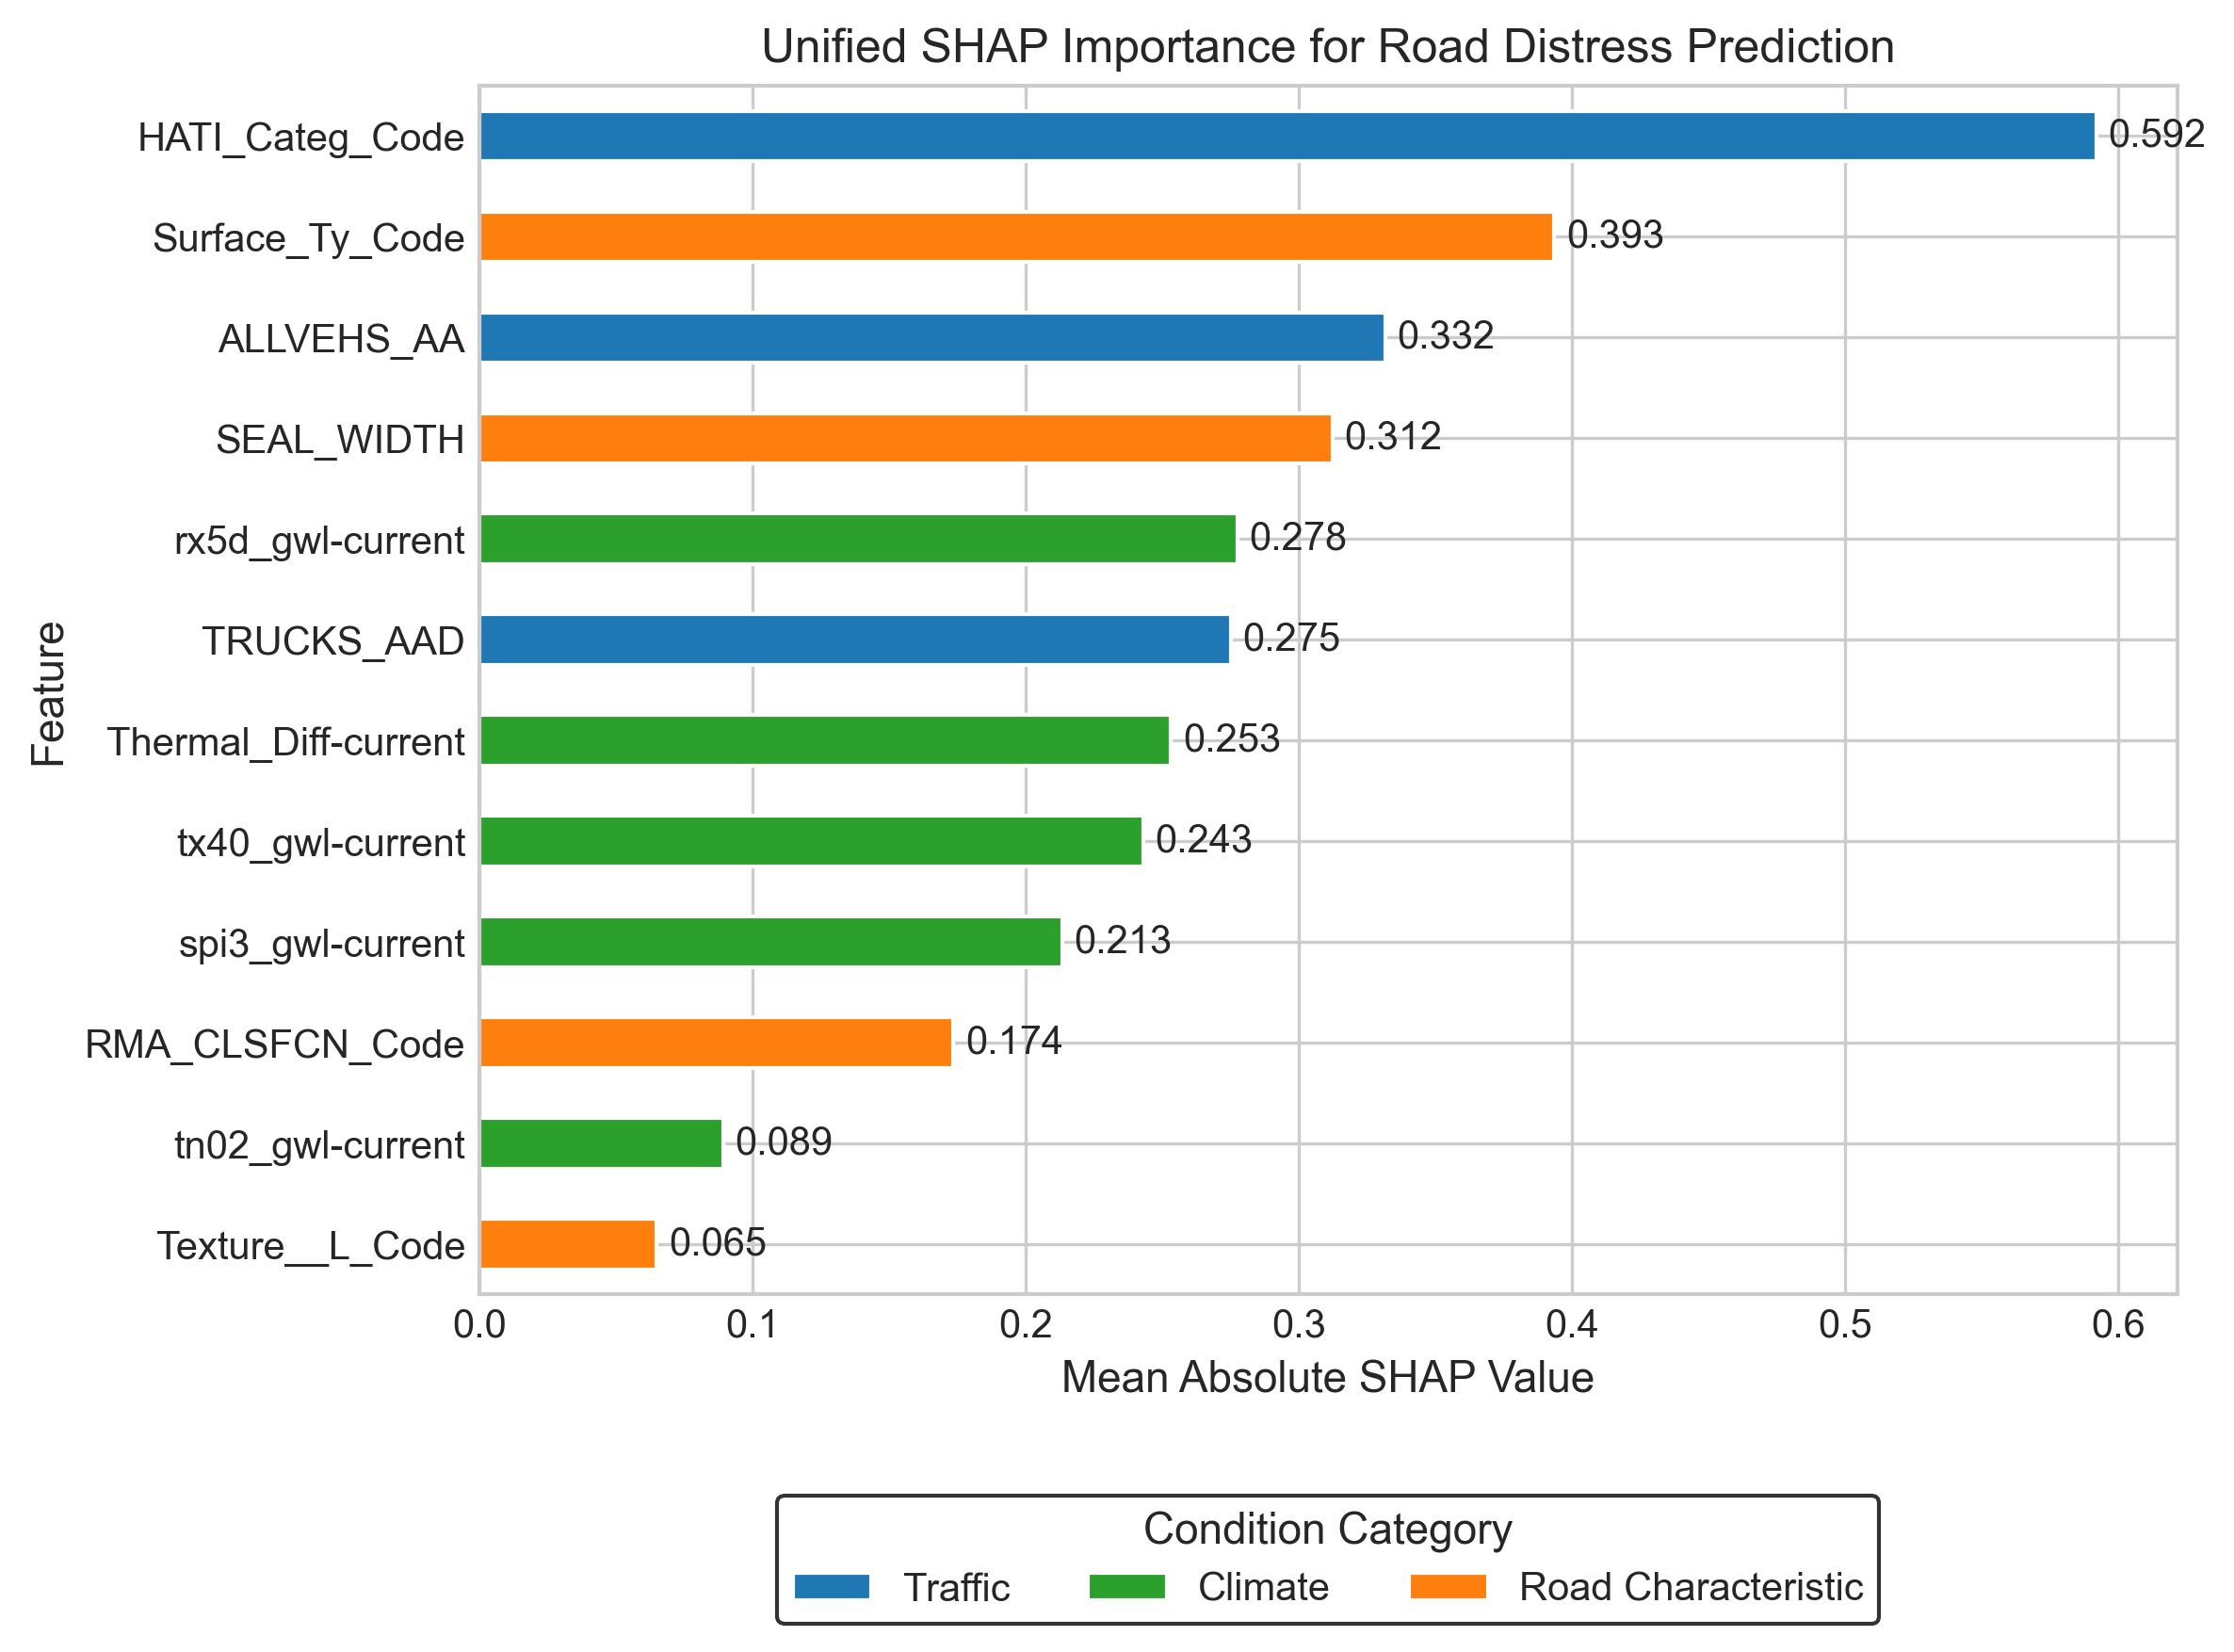

All figures have been generated and saved.


In [11]:
# Bar plot of unified SHAP values, colored by group
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import json

# Set consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['figure.dpi'] = 300

# Load unified SHAP weights from ML code output
run_id = "model_dev"
output_dir = os.path.join("..", "data", "processed", run_id)
path_shap_weights = os.path.join(output_dir, f"shap_weights_{run_id}.json")
with open(path_shap_weights, 'r') as f:
    shap_weights = json.load(f)
unified_shap = pd.DataFrame({
    'Mean_Abs_SHAP': list(shap_weights['Mean_Abs_SHAP'].values()),
    'Normalized_SHAP': list(shap_weights['Normalized_SHAP'].values())
}, index=shap_weights['Mean_Abs_SHAP'].keys())

# Sort by Mean_Abs_SHAP descending for better visualization
unified_shap = unified_shap.sort_values('Mean_Abs_SHAP', ascending=False)

# Define categories consistent with ML code
categories = {
    'Thermal_Diff-current': 'Climate',
    'tx40_gwl-current': 'Climate',
    'tn02_gwl-current': 'Climate',
    'rx5d_gwl-current': 'Climate',
    'spi3_gwl-current': 'Climate',
    'ALLVEHS_AA': 'Traffic',
    'TRUCKS_AAD': 'Traffic',
    'HATI_Categ_Code': 'Traffic',
    'Surface_Ty_Code': 'Road Characteristic',
    'SEAL_WIDTH': 'Road Characteristic',
    'Texture__L_Code': 'Road Characteristic',
    'RMA_CLSFCN_Code': 'Road Characteristic',
}

# Assign colors based on categories
colors = {'Traffic': '#1f77b4', 'Climate': '#2ca02c', 'Road Characteristic': '#ff7f0e'}
bar_colors = [colors[categories.get(feature, 'Road Characteristic')] for feature in unified_shap.index]

# Generate bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = unified_shap['Mean_Abs_SHAP'].plot(kind='barh', ax=ax, color=bar_colors)
ax.invert_yaxis()
ax.set_title('Unified SHAP Importance for Road Distress Prediction')
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_ylabel('Feature')

# Add value labels to each bar
for container in bars.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in ['Traffic', 'Climate', 'Road Characteristic']]
ax.legend(handles=legend_elements, title='Condition Category', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3,
          frameon=True, edgecolor='black')

# Save plot to ML code's figure directory
figure_dir = os.path.join(output_dir, "out_ml")
os.makedirs(figure_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f"shap_importance_{run_id}.png"), bbox_inches='tight')
plt.show()

print("All figures have been generated and saved.")

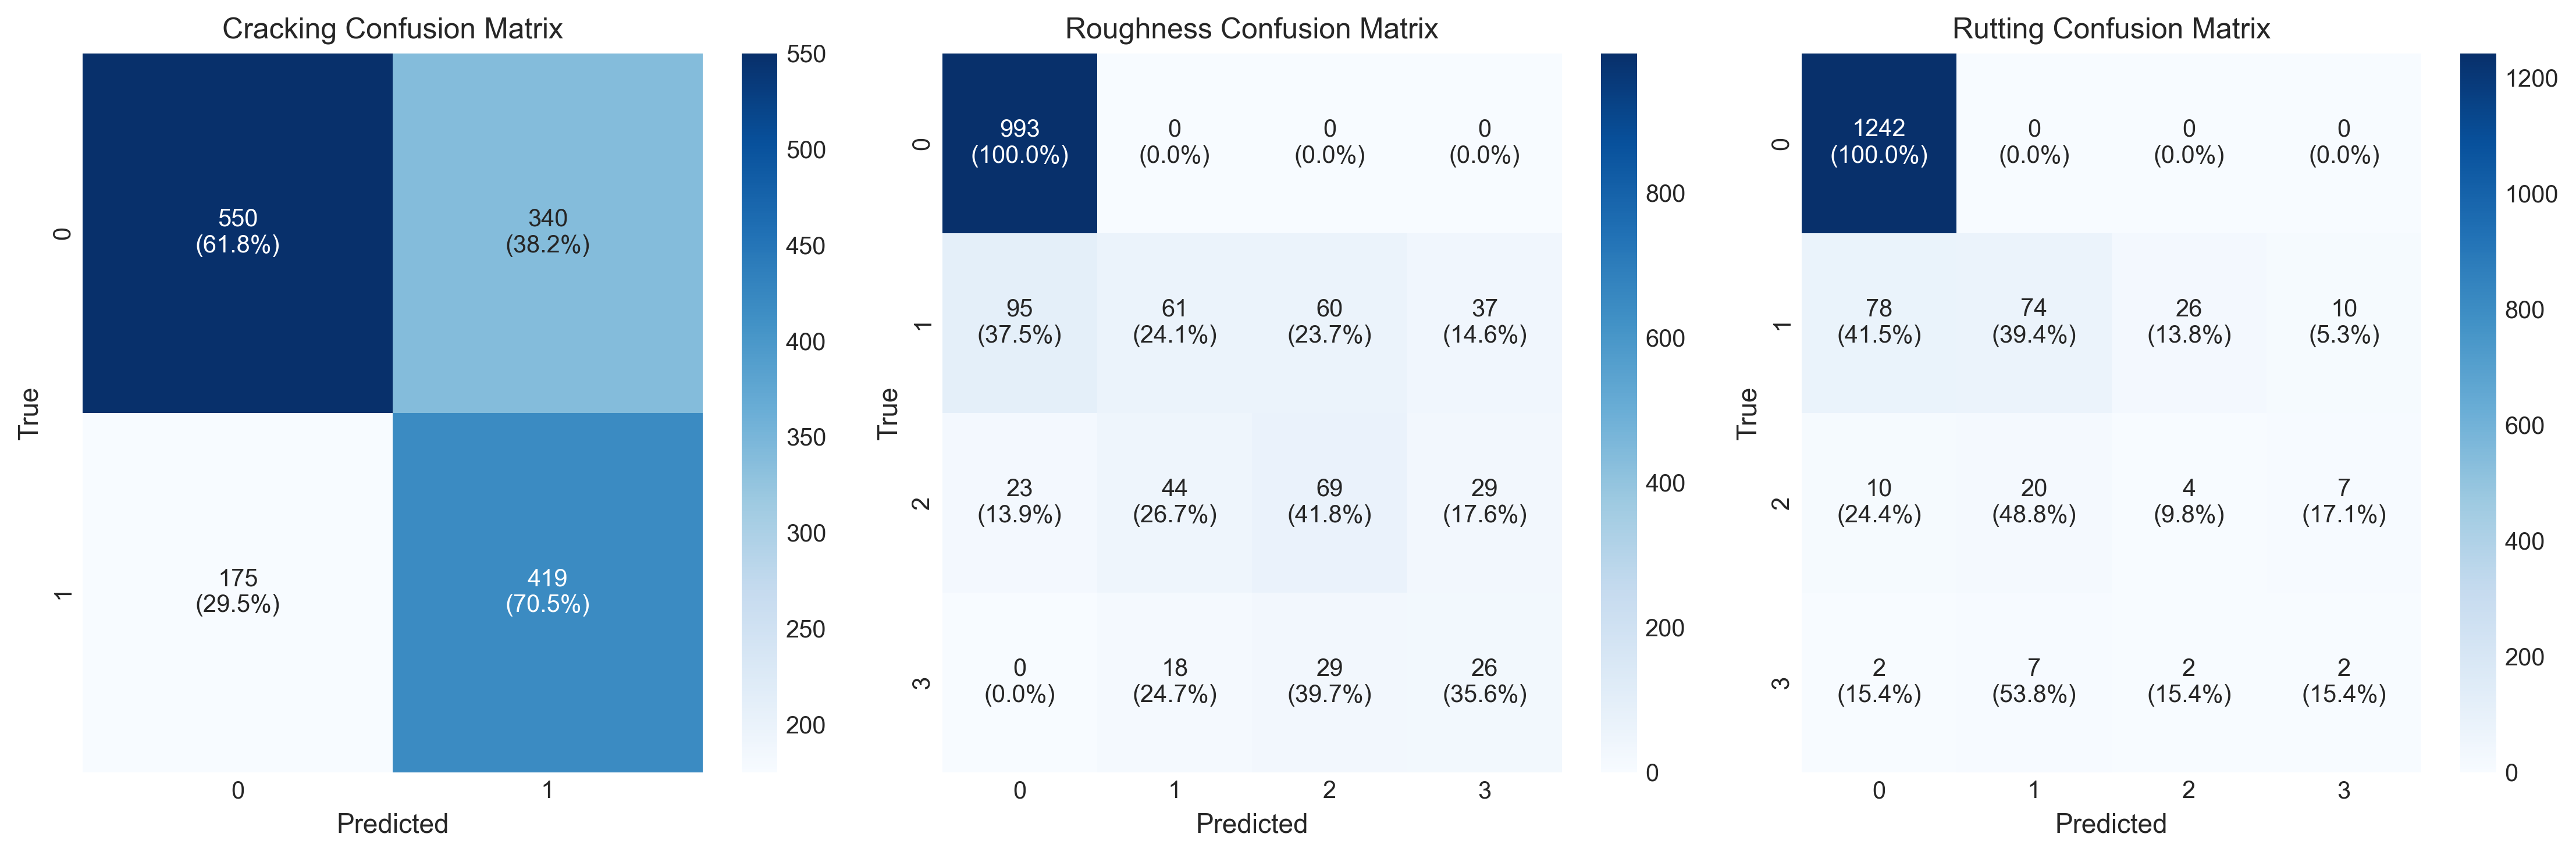

In [12]:
# Heatmaps of confusion matrices for Roughness, Rutting, and Cracking
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set publication-quality styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 11
plt.rcParams['figure.dpi'] = 300

# Configuration
run_id = "model_dev"
output_dir = os.path.join("..", "data", "processed", run_id)
metrics_path = os.path.join(output_dir, f"model_metrics_{run_id}.json")

# Load metrics
with open(metrics_path, 'r') as f:
    metrics = json.load(f)

# Extract confusion matrices
cm_cracking = np.array(metrics['Cracking']['Confusion_Matrix'])
cm_roughness = np.array(metrics['Roughness']['Confusion_Matrix'])
cm_rutting = np.array(metrics['Rutting']['Confusion_Matrix'])

# Compute percentage matrices
cm_cracking_percent = cm_cracking / cm_cracking.sum(axis=1, keepdims=True) * 100
cm_roughness_percent = cm_roughness / cm_roughness.sum(axis=1, keepdims=True) * 100
cm_rutting_percent = cm_rutting / cm_rutting.sum(axis=1, keepdims=True) * 100

# Create annotated matrices
annot_cracking = np.array([[f'{int(val)}\n({percent:.1f}%)' for val, percent in zip(row, row_percent)]
                           for row, row_percent in zip(cm_cracking, cm_cracking_percent)])
annot_roughness = np.array([[f'{int(val)}\n({percent:.1f}%)' for val, percent in zip(row, row_percent)]
                            for row, row_percent in zip(cm_roughness, cm_roughness_percent)])
annot_rutting = np.array([[f'{int(val)}\n({percent:.1f}%)' for val, percent in zip(row, row_percent)]
                          for row, row_percent in zip(cm_rutting, cm_rutting_percent)])

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(cm_cracking, annot=annot_cracking, fmt='', cmap='Blues', ax=axes[0],
            xticklabels=['0', '1'], yticklabels=['0', '1'])
axes[0].set_title('Cracking Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
sns.heatmap(cm_roughness, annot=annot_roughness, fmt='', cmap='Blues', ax=axes[1],
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
axes[1].set_title('Roughness Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
sns.heatmap(cm_rutting, annot=annot_rutting, fmt='', cmap='Blues', ax=axes[2],
            xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
axes[2].set_title('Rutting Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
figure_dir = os.path.join(output_dir, "out_ml")
os.makedirs(figure_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f'confusion_matrices_{run_id}.png'), bbox_inches='tight')
plt.show()


# Data Preparation for CRiskS Computation

In [13]:
# Data Preparation for Climate Risk Score Computation
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
from datetime import datetime

run_id = "model_dev"
output_dir = f"../data/processed/{run_id}"
# os.makedirs(output_dir, exist_ok=True)

print(f"[{datetime.now()}] ---- Pre-Processing Outputs for {run_id} ----")

# Load preprocessed dataset
gdf_final = gpd.read_file(rf"../data/processed/{run_id}/gdf_road_clim_cln_final_withfuture_filtered.geojson")
gdf = gdf_final.copy()

# Check if road_link_id exists in the dataset
if "road_link_id" not in gdf.columns:
    raise ValueError("Column 'road_link_id' not found in gdf_final. Please verify the column name or dataset.")

# Exclude rare Surface_Ty categories
exclude_categories = ["Concrete", "High Friction Surface Treatment", "Gravel", "Other"]
gdf = gdf[~gdf["Surface_Ty"].isin(exclude_categories)]
print(f"[{datetime.now()}] Excluded {len(gdf_final) - len(gdf)} segments with Surface_Ty in {exclude_categories}")
print(f"[{datetime.now()}] Remaining segments: {len(gdf)}")

# Compute Thermal_Diff
gdf["Thermal_Diff-current"] = gdf["tgm_max_gwl-current"] - gdf["tgm_min_gwl-current"]
gdf["Thermal_Diff-1.5"] = gdf["tgm_max_gwl-1.5"] - gdf["tgm_min_gwl-1.5"]
gdf["Thermal_Diff-2.0"] = gdf["tgm_max_gwl-2.0"] - gdf["tgm_min_gwl-2.0"]
gdf["Thermal_Diff-3.0"] = gdf["tgm_max_gwl-3.0"] - gdf["tgm_min_gwl-3.0"]

gdf['link_length_km'] = gdf['link_length'] / 1000

# Define Predictors
predictors = [
    "ALLVEHS_AA", "TRUCKS_AAD", "SEAL_WIDTH",
    "HATI_Categ_Code", "Surface_Ty_Code", "Texture__L_Code", "RMA_CLSFCN_Code",
    "Thermal_Diff-current", "tx40_gwl-current", "tn02_gwl-current", "rx5d_gwl-current", "spi3_gwl-current",
    "Thermal_Diff-1.5", "tx40_gwl-1.5", "tn02_gwl-1.5", "rx5d_gwl-1.5", "spi3_gwl-1.5",
    "Thermal_Diff-2.0", "tx40_gwl-2.0", "tn02_gwl-2.0", "rx5d_gwl-2.0", "spi3_gwl-2.0",
    "Thermal_Diff-3.0", "tx40_gwl-3.0", "tn02_gwl-3.0", "rx5d_gwl-3.0", "spi3_gwl-3.0",
]

# Manual categorical mappings
surface_ty_map = {
    "Stone Seal": 0,  # Normalized: 0.0
    "Asphalt": 1,     # Normalized: 0.5
    "Ultra Thin Asphalt": 2  # Normalized: 1.0
}
rma_clsfcn_map = {
    "FW": 0,  # Freeway, Normalized: 0.0
    "AH": 1,  # Arterial Highway, Normalized: 0.5
    "AO": 2   # Arterial Other, Normalized: 1.0
}
hati_categ_map = {
    "Good (for <2.2 HATI)": 0,
    "Poor (for >= 2.2 HATI)": 1
}
texture_l_map = {
    "Good (for >= 1.3mm)": 0,
    "Poor (for <1.3mm)": 1
}

# Apply mappings
gdf["Surface_Ty_Code"] = gdf["Surface_Ty"].map(surface_ty_map)
gdf["RMA_CLSFCN_Code"] = gdf["RMA_CLSFCN"].map(rma_clsfcn_map)
gdf["HATI_Categ_Code"] = gdf["HATI_Categ"].map(hati_categ_map)
gdf["Texture__L_Code"] = gdf["Texture__L"].map(texture_l_map)

# Validate mappings
for col, mapping in [
    ("Surface_Ty_Code", surface_ty_map),
    ("RMA_CLSFCN_Code", rma_clsfcn_map),
    ("HATI_Categ_Code", hati_categ_map),
    ("Texture__L_Code", texture_l_map)
]:
    if gdf[col].isna().any():
        missing = gdf[gdf[col].isna()][col.replace("_Code", "")].unique()
        raise ValueError(f"Missing mappings for {col}: {missing}. Please update {mapping}.")
    print(f"[{datetime.now()}] Applied {col} mapping: {mapping}")

# Generate normalisation parameters
numerical_cols = [
    "ALLVEHS_AA", "SEAL_WIDTH", "Thermal_Diff-current", "tx40_gwl-current",
    "spi3_gwl-current", "tn02_gwl-current", "rx5d_gwl-current", "TRUCKS_AAD",
    "Thermal_Diff-1.5", "tx40_gwl-1.5", "tn02_gwl-1.5", "rx5d_gwl-1.5", "spi3_gwl-1.5",
    "Thermal_Diff-2.0", "tx40_gwl-2.0", "tn02_gwl-2.0", "rx5d_gwl-2.0", "spi3_gwl-2.0",
    "Thermal_Diff-3.0", "tx40_gwl-3.0", "tn02_gwl-3.0", "rx5d_gwl-3.0", "spi3_gwl-3.0"
]
normalization_params = {
    "Surface_Ty_Code": {"min": 0, "max": 2, "mapping": {"0": 0.0, "1": 0.5, "2": 1.0}},
    "RMA_CLSFCN_Code": {"min": 0, "max": 2, "mapping": {"0": 0.0, "1": 0.5, "2": 1.0}},
    "HATI_Categ_Code": {"min": 0, "max": 1, "mapping": {"0": 0.0, "1": 1.0}},
    "Texture__L_Code": {"min": 0, "max": 1, "mapping": {"0": 0.0, "1": 1.0}}
}
for col in numerical_cols:
    if col in gdf.columns:
        normalization_params[col] = {
            "min": float(gdf[col].min()),
            "max": float(gdf[col].max())
        }
    else:
        print(f"[{datetime.now()}] Warning: {col} not in dataset")

# Save normalisation parameters
path_norm_params = os.path.join(output_dir, f"normalization_params_{run_id}.json")
with open(path_norm_params, "w") as f:
    json.dump(normalization_params, f)
print(f"[{datetime.now()}] Saved normalization parameters to {path_norm_params}")

# Select columns to keep
col_retain = ["geometry", "road_link_id", "RGN_LONG_N", "link_length", "link_length_km", "FLOW"]
# per_km_cols = [f"{col}_per_km" for col in numerical_cols]
columns_to_keep = predictors + col_retain  # + per_km_cols
gdf = gdf[columns_to_keep].dropna()

# Save CRA_Calc Dataset
path_cra_calc = os.path.join(output_dir, f"gdf_road_clim_cln_final_cra_calc.geojson")
gdf.to_file(path_cra_calc, driver="GeoJSON")

# Summary
print(f"[{datetime.now()}] Dataset for CRA calculations prepared:")
print(f"Number of segments: {len(gdf)}")
print(f"Predictors: {predictors}")
# print(f"Per-kilometre columns retained: {per_km_cols}")
print(f"Additional columns retained: {col_retain}")
print(f"Saved file: {path_cra_calc}")
print(f"All columns: {gdf.columns}")


[2025-10-31 18:03:29.783480] ---- Pre-Processing Outputs for model_dev ----
[2025-10-31 18:03:31.563254] Excluded 35 segments with Surface_Ty in ['Concrete', 'High Friction Surface Treatment', 'Gravel', 'Other']
[2025-10-31 18:03:31.563254] Remaining segments: 7419
[2025-10-31 18:03:31.569636] Applied Surface_Ty_Code mapping: {'Stone Seal': 0, 'Asphalt': 1, 'Ultra Thin Asphalt': 2}
[2025-10-31 18:03:31.569636] Applied RMA_CLSFCN_Code mapping: {'FW': 0, 'AH': 1, 'AO': 2}
[2025-10-31 18:03:31.569636] Applied HATI_Categ_Code mapping: {'Good (for <2.2 HATI)': 0, 'Poor (for >= 2.2 HATI)': 1}
[2025-10-31 18:03:31.569636] Applied Texture__L_Code mapping: {'Good (for >= 1.3mm)': 0, 'Poor (for <1.3mm)': 1}
[2025-10-31 18:03:31.569636] Saved normalization parameters to ../data/processed/model_dev\normalization_params_model_dev.json


2025-10-31 18:03:33,865 - INFO - Created 7,419 records


[2025-10-31 18:03:33.865486] Dataset for CRA calculations prepared:
Number of segments: 7419
Predictors: ['ALLVEHS_AA', 'TRUCKS_AAD', 'SEAL_WIDTH', 'HATI_Categ_Code', 'Surface_Ty_Code', 'Texture__L_Code', 'RMA_CLSFCN_Code', 'Thermal_Diff-current', 'tx40_gwl-current', 'tn02_gwl-current', 'rx5d_gwl-current', 'spi3_gwl-current', 'Thermal_Diff-1.5', 'tx40_gwl-1.5', 'tn02_gwl-1.5', 'rx5d_gwl-1.5', 'spi3_gwl-1.5', 'Thermal_Diff-2.0', 'tx40_gwl-2.0', 'tn02_gwl-2.0', 'rx5d_gwl-2.0', 'spi3_gwl-2.0', 'Thermal_Diff-3.0', 'tx40_gwl-3.0', 'tn02_gwl-3.0', 'rx5d_gwl-3.0', 'spi3_gwl-3.0']
Additional columns retained: ['geometry', 'road_link_id', 'RGN_LONG_N', 'link_length', 'link_length_km', 'FLOW']
Saved file: ../data/processed/model_dev\gdf_road_clim_cln_final_cra_calc.geojson
All columns: Index(['ALLVEHS_AA', 'TRUCKS_AAD', 'SEAL_WIDTH', 'HATI_Categ_Code',
       'Surface_Ty_Code', 'Texture__L_Code', 'RMA_CLSFCN_Code',
       'Thermal_Diff-current', 'tx40_gwl-current', 'tn02_gwl-current',
       'rx

# Compute Climate Risk Scores for Current Scenario (GWL 1.2°C)

In [14]:
# COMPUTE CLIMATE RISK AND ASSIGN RISK LEVELS - 5H x 5E x 5V & 5L x 5C - 4 Categories
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import os
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime
from loguru import logger

# Configuration
run_id = "model_dev"
outputs_id = "out_crisks"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
os.makedirs(output_dir, exist_ok=True)
path_cra_calc = os.path.join(output_dir, f"../gdf_road_clim_cln_final_cra_calc.geojson")
path_shap_weights = os.path.join(output_dir, f"../shap_weights_{run_id}.json")
path_norm_params = os.path.join(output_dir, f"../normalization_params_{run_id}.json")
validate_performance = True
scenario_id = "current"

path_preproc = os.path.join(output_dir, f"../gdf_road_clim_cln_final_{run_id}.geojson")
logger.info(f"Loading distress data from {path_preproc}")
gdf_distress = gpd.read_file(path_preproc)
logger.info(f"Loaded distress dataset with {len(gdf_distress)} segments")
logger.info(f"Distress dataset columns: {list(gdf_distress.columns)}")
gdf = gpd.read_file(path_cra_calc)

# Validate input data
distress_cols = ["road_link_id", "Roughness_Code", "Rutting_Code", "Cracking_Code"]
missing_distress_cols = [col for col in distress_cols if col not in gdf_distress.columns]
if missing_distress_cols:
    raise ValueError(f"Missing distress columns: {missing_distress_cols}")

# Check for geometry column in gdf_cra
geometry_col = gdf.geometry.name if gdf.geometry is not None else None
if geometry_col is None:
    raise ValueError(f"No geometry column found in CRA dataset. Available columns: {list(gdf.columns)}")
logger.info(f"Using geometry column from CRA dataset: {geometry_col}")

# SHAP weights configuration
SHAP_WEIGHTS = {
    "Hazard": ["Thermal_Diff-current", "tx40_gwl-current", "spi3_gwl-current", "tn02_gwl-current", "rx5d_gwl-current"],
    "Exposure": ["ALLVEHS_AA", "HATI_Categ_Code", "TRUCKS_AAD"],
    "Vulnerability": ["SEAL_WIDTH", "Surface_Ty_Code", "RMA_CLSFCN_Code", "Texture__L_Code"]
}

print(f"[{datetime.now()}] ---- Compute Climate Risk Scores (gwl-{scenario_id}) ----")

# Load data
print(f"[{datetime.now()}] Loading data...")
gdf = gpd.read_file(path_cra_calc)
with open(path_shap_weights, "r") as f:
    shap_weights = json.load(f)["Mean_Abs_SHAP"]
with open(path_norm_params, "r") as f:
    normalization_params = json.load(f)

# Validate input data
print(f"[{datetime.now()}] Validating input data...")
required_cols = ["road_link_id"] + [f.replace("current", scenario_id) for f in
                                    [item for sublist in SHAP_WEIGHTS.values() for item in sublist]]
missing_cols = [col for col in required_cols if col not in gdf.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Initialise DataFrame with additional columns
df = gdf[required_cols].copy()
base_features = [item for sublist in SHAP_WEIGHTS.values() for item in sublist]
for feature in base_features:
    base_name = feature
    scenario_name = feature.replace("current", scenario_id)
    df[f"{base_name}_shap"] = shap_weights.get(base_name, 0)
    df[f"{base_name}_min"] = normalization_params[base_name]["min"]
    df[f"{base_name}_max"] = normalization_params[base_name]["max"]
    df[scenario_name] = df[scenario_name]

# Normalise features and compute contributions
print(f"[{datetime.now()}] Normalising features for CRA...")
for comp, features in SHAP_WEIGHTS.items():
    for feature in features:
        base_name = feature
        scenario_name = feature.replace("current", scenario_id)
        df[f"{base_name}_norm"] = (df[scenario_name] - df[f"{base_name}_min"]) / (
                df[f"{base_name}_max"] - df[f"{base_name}_min"])
        df[f"{base_name}_contrib"] = df[f"{base_name}_shap"] * df[f"{base_name}_norm"]
    shap_sum = df[[f"{f}_shap" for f in features]].sum(axis=1).iloc[0]
    df[f"{comp}_sum-{scenario_id}"] = df[[f"{f}_contrib" for f in features]].sum(axis=1)

# Compute CRiskS
print(f"[{datetime.now()}] Computing Climate Risk Scores...")
df[f"CRS-{scenario_id}"] = df[f"Hazard_sum-{scenario_id}"] * df[f"Exposure_sum-{scenario_id}"] * df[
    f"Vulnerability_sum-{scenario_id}"]

# Prepare output DataFrame
output_cols = ["road_link_id"]
output_cols.extend([f for f in required_cols if f != "road_link_id" and f != "link_length_km"])
for feature in base_features:
    output_cols.extend([f"{feature}_shap", f"{feature}_min", f"{feature}_max", f"{feature}_norm", f"{feature}_contrib"])
for comp in SHAP_WEIGHTS.keys():
    output_cols.extend([f"{comp}_sum-{scenario_id}",
                        # f"{comp}_sum_Level-{scenario_id}",
                        # f"{comp}_sum_norm-{scenario_id}",
                        # f"{comp}_sum_norm_Level-{scenario_id}",
                        ])
output_cols.extend([f"CRS-{scenario_id}",
                    ])
climate_scores = df[output_cols].copy()


# Save normalisation details
norm_details = {comp: {f: normalization_params[f] for f in features if f in normalization_params} for comp, features in SHAP_WEIGHTS.items()}
with open(os.path.join(output_dir, f"norm_details_gwl-{scenario_id}_{run_id}.json"), "w") as f:
    json.dump(norm_details, f)

# Save outputs
output_path = os.path.join(output_dir, f"climate_risk_scores_with_vars_gwl-{scenario_id}_{run_id}.csv")
climate_scores.to_csv(output_path, index=False)
print(f"[{datetime.now()}] Saved climate risk scores with variables to {output_path}")

print(f"[{datetime.now()}] Climate risk score computation completed for gwl-{scenario_id} scenario.")


2025-10-31 18:03:40,592 - INFO - Loading distress data from ../data/processed/model_dev/out_crisks\../gdf_road_clim_cln_final_model_dev.geojson
2025-10-31 18:03:42,034 - INFO - Loaded distress dataset with 7419 segments
2025-10-31 18:03:42,034 - INFO - Distress dataset columns: ['ALLVEHS_AA', 'TRUCKS_AAD', 'SEAL_WIDTH', 'HATI_Categ_Code', 'Surface_Ty_Code', 'Texture__L_Code', 'RMA_CLSFCN_Code', 'Thermal_Diff-current', 'tx40_gwl-current', 'tn02_gwl-current', 'rx5d_gwl-current', 'spi3_gwl-current', 'Roughness_Code', 'Rutting_Code', 'Cracking_Code', 'road_link_id', 'link_length', 'geometry']
2025-10-31 18:03:43,646 - INFO - Using geometry column from CRA dataset: geometry
[2025-10-31 18:03:43.646918] ---- Compute Climate Risk Scores (gwl-current) ----
[2025-10-31 18:03:43.646918] Loading data...
[2025-10-31 18:03:45.695572] Validating input data...
[2025-10-31 18:03:45.714465] Normalising features for CRA...
[2025-10-31 18:03:45.725607] Computing Climate Risk Scores...
[2025-10-31 18:03:4

In [15]:
# Turn CRiskS CSV into GeoJSON
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime

# Configuration
run_id = "model_dev"
outputs_id = "out_crisks"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
path_cra_calc = os.path.join(output_dir, f"../gdf_road_clim_cln_final_cra_calc.geojson")
scenario_ids = ["current"]

print(f"[{datetime.now()}] ---- Combining CRA Outputs into Geospatial Dataset ----")

# Load geospatial data
print(f"[{datetime.now()}] Loading geospatial data...")
gdf = gpd.read_file(path_cra_calc)
gdf = gdf[["road_link_id", "RGN_LONG_N",
           "link_length", "link_length_km", "FLOW",
           "geometry",
           ]]
print(f"[{datetime.now()}] Loaded {len(gdf)} records from gdf_road_clim_cln_final_cra_calc.json")

# Validate road_link_id uniqueness
if gdf["road_link_id"].duplicated().sum() > 0:
    raise ValueError("Duplicate road_link_id values found in geospatial data")

# Initialize merged DataFrame
merged_gdf = gdf.copy()

# Define columns to extract from each scenario
base_cols = [
    "road_link_id",
    "Hazard_sum-{scenario_id}",
    "Exposure_sum-{scenario_id}",
    "Vulnerability_sum-{scenario_id}",
    "CRS-{scenario_id}",
]

# Merge CR data for each scenario
for scenario_id in scenario_ids:
    print(f"[{datetime.now()}] Processing scenario gwl-{scenario_id}...")
    path_cra_scores = os.path.join(output_dir, f"climate_risk_scores_with_vars_gwl-{scenario_id}_{run_id}.csv")
    if not os.path.exists(path_cra_scores):
        raise FileNotFoundError(f"CRiskS with variables file not found: {path_cra_scores}")

    # Load CRA scores
    df = pd.read_csv(path_cra_scores)

    # Select columns
    cols = [col.format(scenario_id=scenario_id) for col in base_cols]

    # Validate columns
    missing_cols = [col for col in cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in gwl-{scenario_id} data: {missing_cols}")

    # Subset DataFrame
    df = df[cols]

    # Validate road_link_id uniqueness
    if df["road_link_id"].duplicated().sum() > 0:
        raise ValueError(f"Duplicate road_link_id values found in gwl-{scenario_id} data")

    # Merge with geospatial data
    merged_gdf = merged_gdf.merge(df, on="road_link_id", how="left")
    print(f"[{datetime.now()}] Merged {len(df)} records for gwl-{scenario_id}")

# Validate merged data
print(f"[{datetime.now()}] Validating merged data...")
if merged_gdf["road_link_id"].duplicated().sum() > 0:
    raise ValueError("Duplicate road_link_id values found in merged data")
missing_values = merged_gdf.isna().sum()
if missing_values.sum() > 0:
    print(f"[{datetime.now()}] Warning: Missing values detected:")
    print(missing_values[missing_values > 0])

# Save combined dataset
output_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.geojson")
merged_gdf.to_file(output_path, driver="GeoJSON")
output_path_csv = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv")
merged_gdf.drop(columns='geometry').to_csv(output_path_csv, index=False)

print(f"[{datetime.now()}] Saved combined CRiskS dataset to {output_path}")
print(f"[{datetime.now()}] CRiskS output combination completed for all scenarios.")

# Offset Output Road Links by 40m
from src.ricraf_dev import offset_line
merged_gdf_offset = merged_gdf.copy()

# Offset 40m to the left
merged_gdf_offset['geometry'] = merged_gdf_offset.apply(
    lambda row: offset_line(row['geometry'], 40, row.get('road_link_id')),
    axis=1
)
offset_output_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}_offset.geojson")
merged_gdf_offset.to_file(offset_output_path, driver="GeoJSON")
print(f"[{datetime.now()}] Saved offset dataset to {offset_output_path}")


[2025-10-31 18:03:49.083506] ---- Combining CRA Outputs into Geospatial Dataset ----
[2025-10-31 18:03:49.083506] Loading geospatial data...
[2025-10-31 18:03:50.974116] Loaded 7419 records from gdf_road_clim_cln_final_cra_calc.json
[2025-10-31 18:03:50.977485] Processing scenario gwl-current...
[2025-10-31 18:03:51.048465] Merged 7419 records for gwl-current
[2025-10-31 18:03:51.048465] Validating merged data...


2025-10-31 18:03:54,554 - INFO - Created 7,419 records


[2025-10-31 18:03:54.615965] Saved combined CRiskS dataset to ../data/processed/model_dev/out_crisks\climate_risk_scores_gwl-current_model_dev.geojson
[2025-10-31 18:03:54.615965] CRiskS output combination completed for all scenarios.


2025-10-31 18:04:09,798 - INFO - Created 7,419 records


[2025-10-31 18:04:09.799730] Saved offset dataset to ../data/processed/model_dev/out_crisks\climate_risk_scores_gwl-current_model_dev_offset.geojson


[2025-10-31 18:04:14.600998] Loading geospatial data...
[2025-10-31 18:04:16.804987] Generating thematic maps...


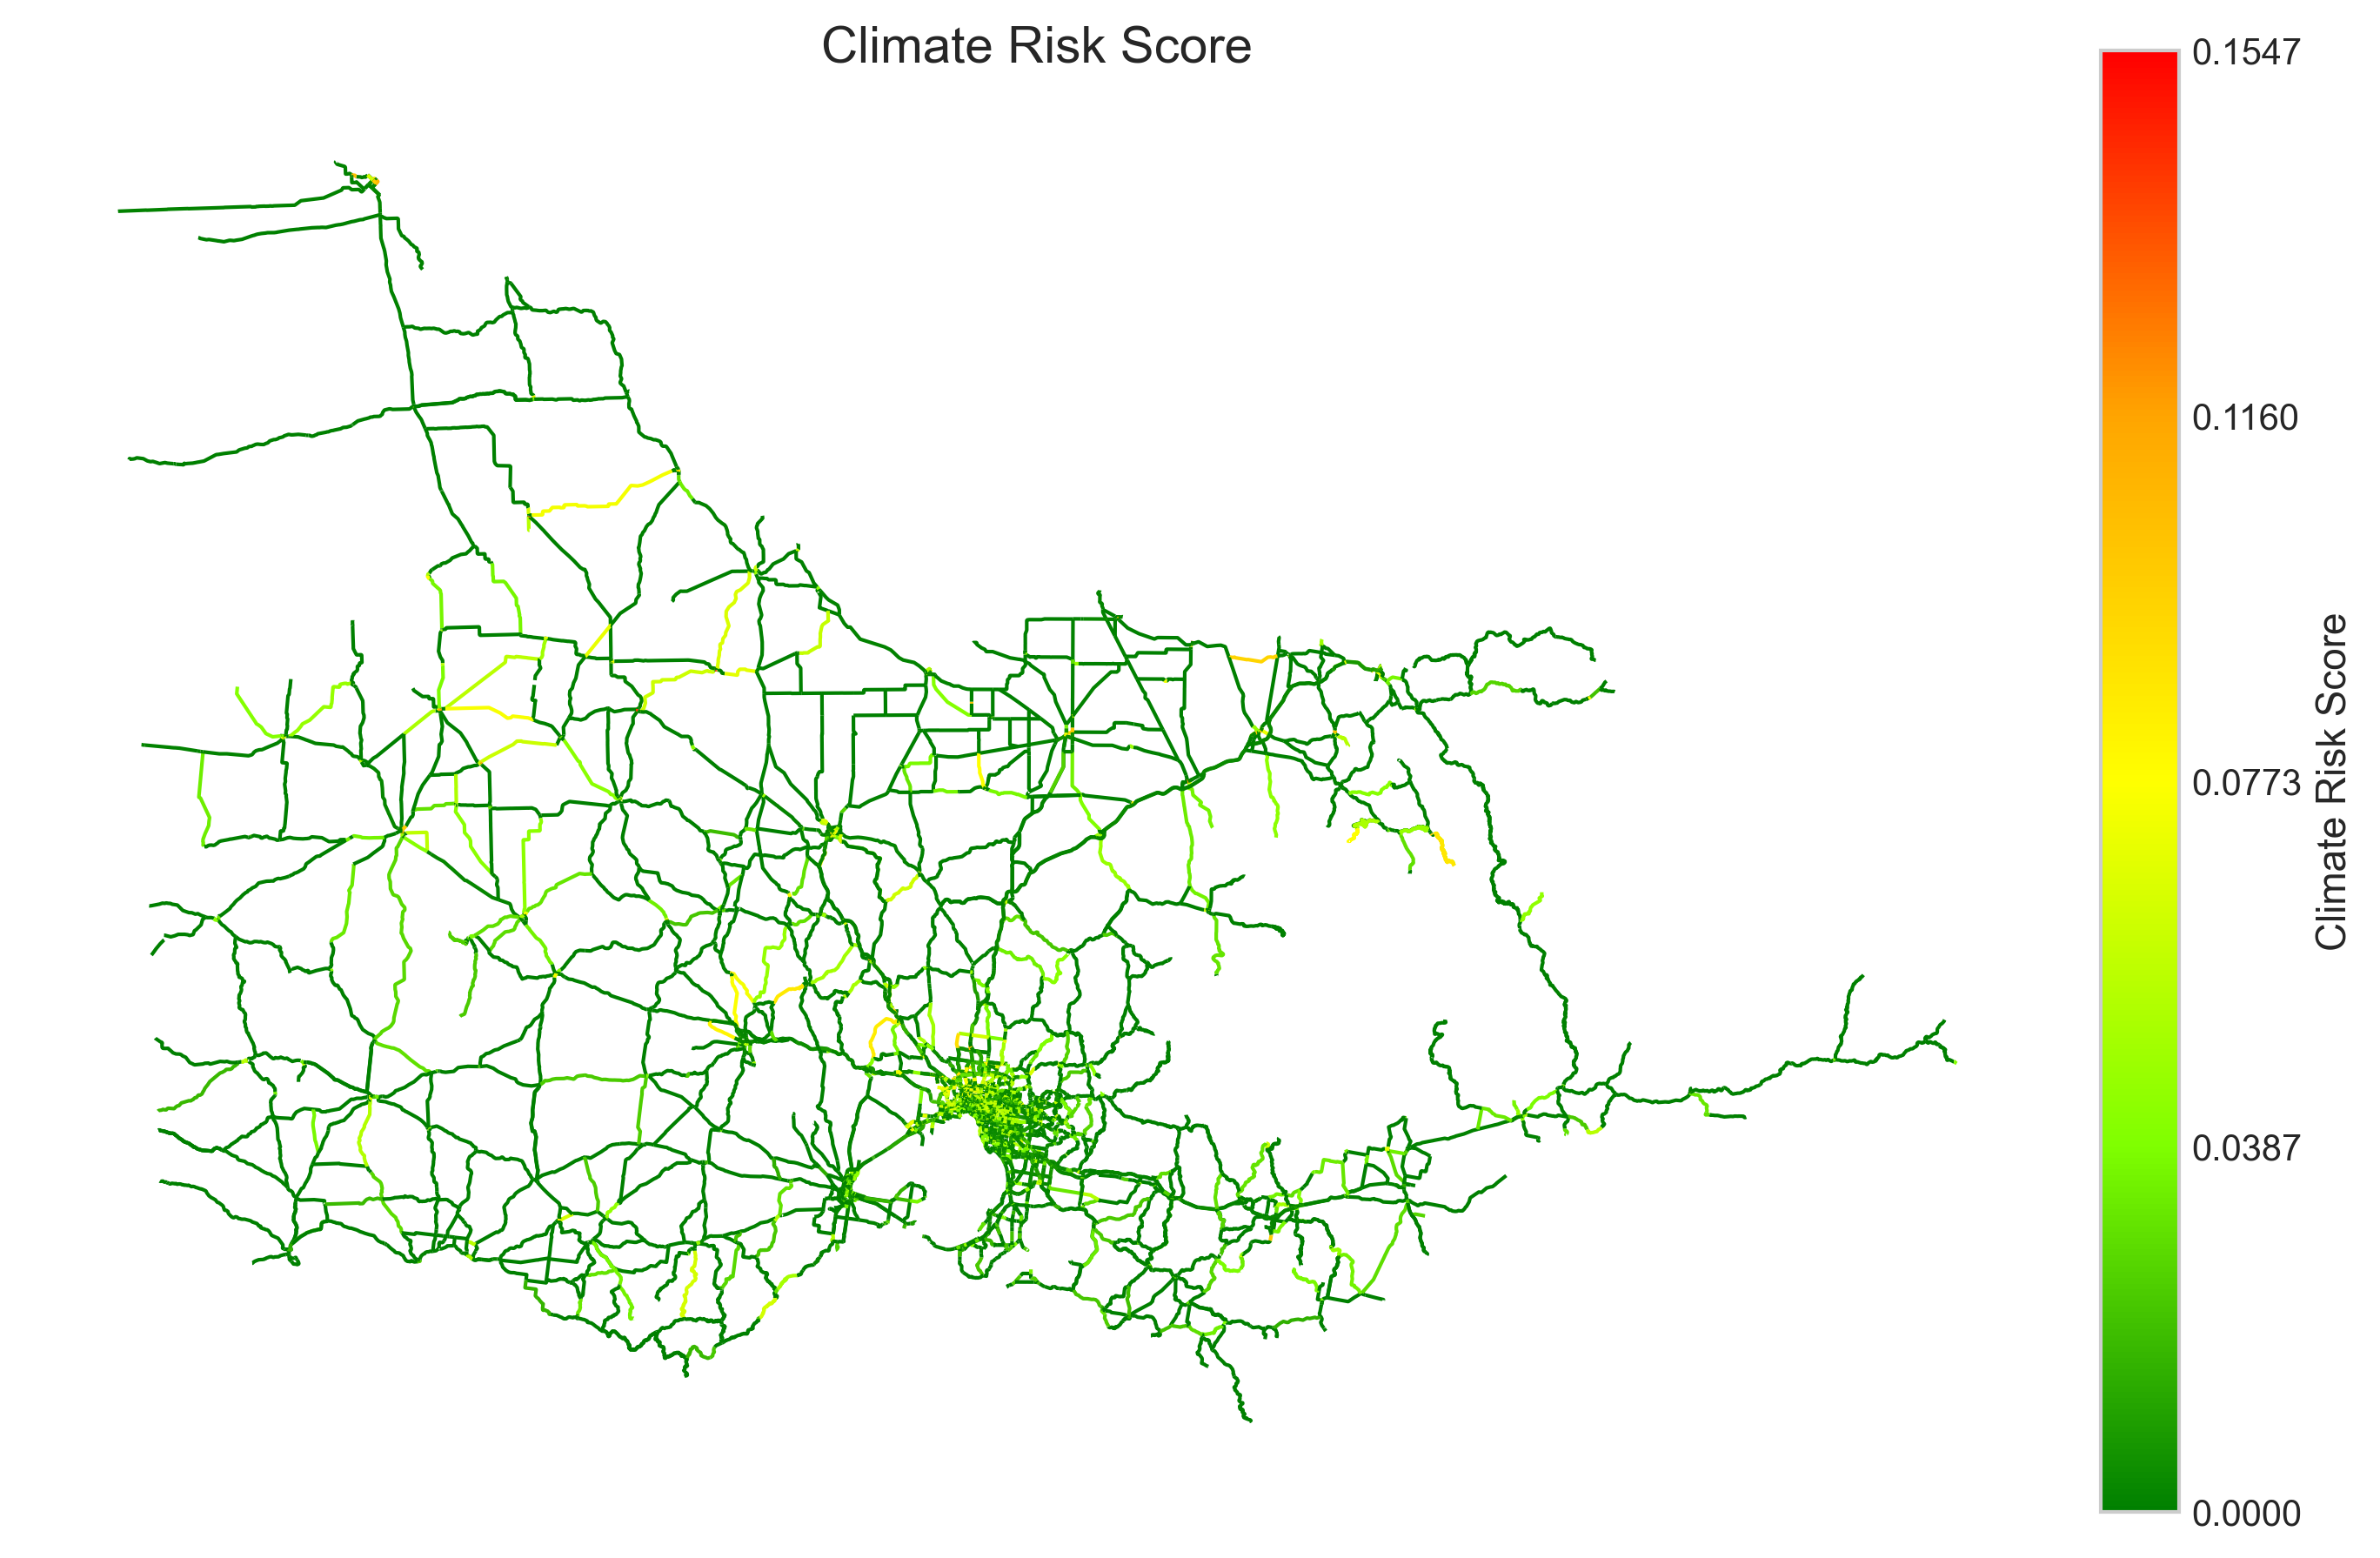

[2025-10-31 18:04:18.288170] Generating zoomed-in thematic maps...


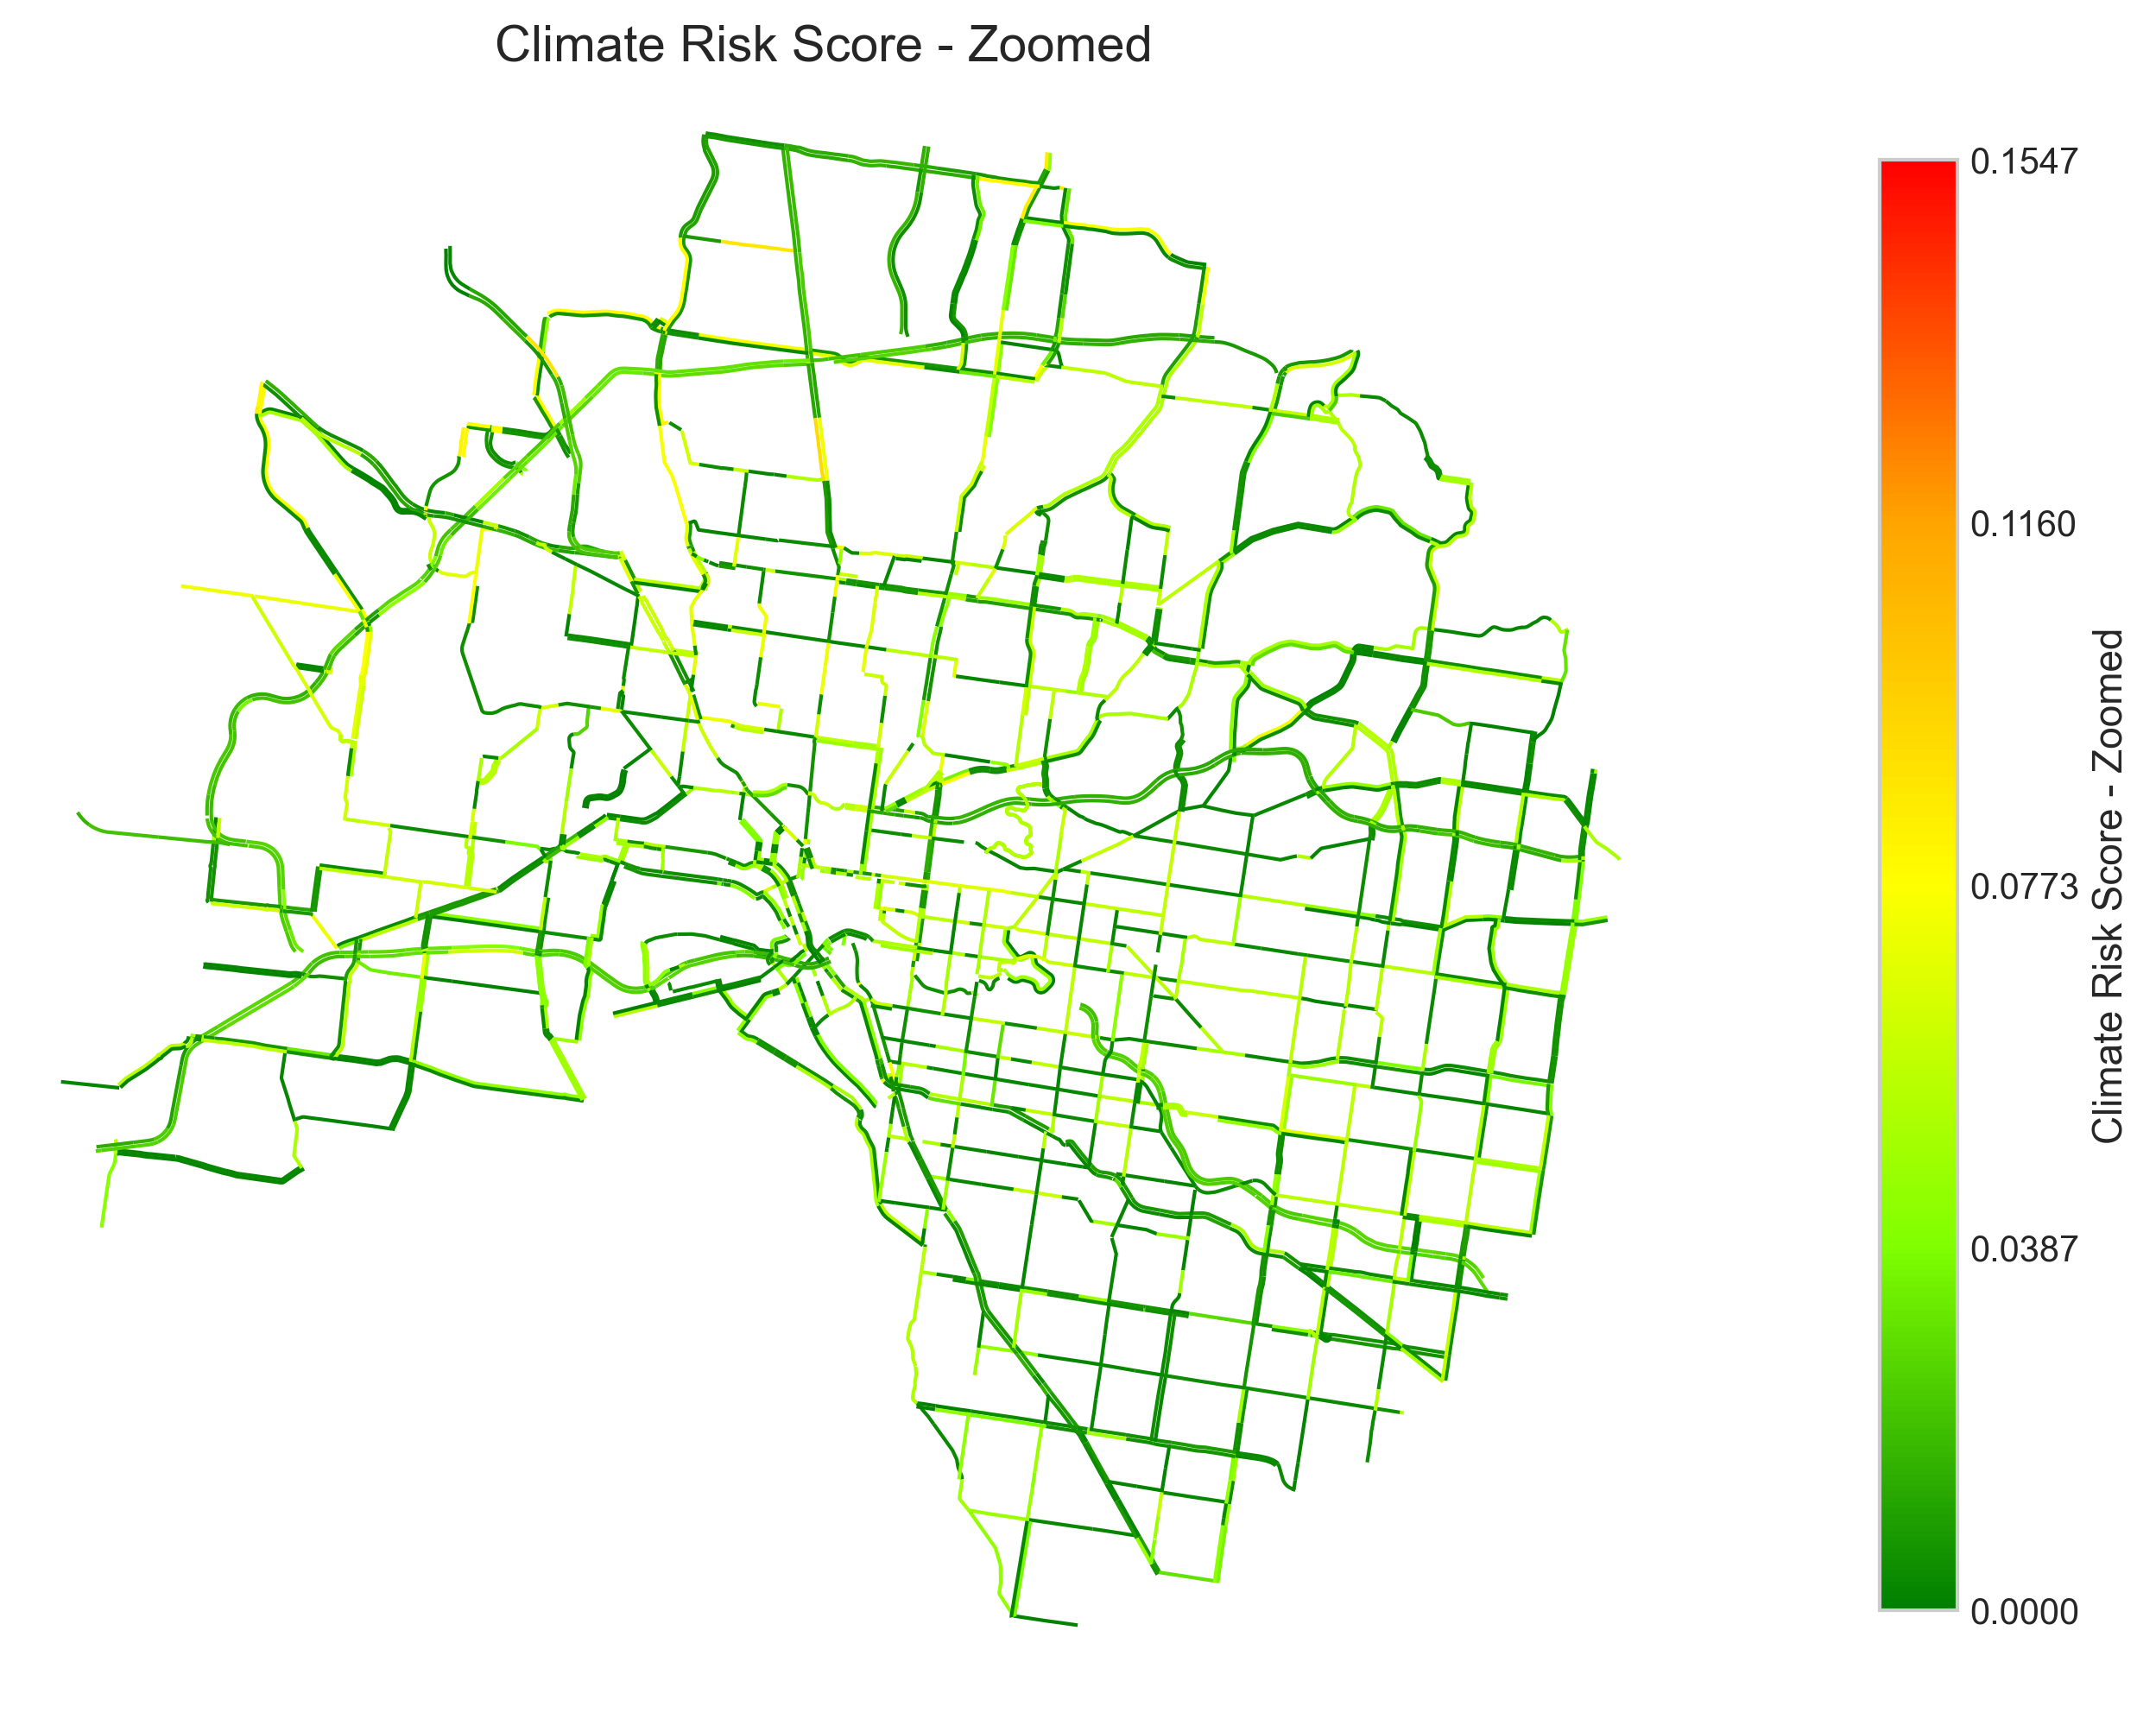

[2025-10-31 18:04:19.239339] Thematic maps saved to ../data/processed/model_dev/out_crisks


In [16]:
# Plot CRiskS on Network (Thematic Maps)
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from datetime import datetime
import numpy as np
from pyproj import Transformer
from shapely.geometry import Point

# Configuration
run_id = "model_dev"
outputs_id = "out_crisks"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
scenario_id = "current"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}_offset.geojson")
scenario_ids = ["current"]

# Load geospatial data
print(f"[{datetime.now()}] Loading geospatial data...")
gdf = gpd.read_file(data_path)

# Ensure GeoDataFrame is in EPSG:3111
if gdf.crs != "EPSG:3111":
    gdf = gdf.to_crs("EPSG:3111")

# Define required columns
required_cols = ["road_link_id", "geometry", "CRS-current"
                 # "Roughness_", "Rutting_Ca", "Cracking_C",
                 # "Norm_Roughness", "Norm_Rutting", "Norm_Cracking", "Distress_Score",
                 # "Distress_Score_Level",
                 ]
for scenario_id in scenario_ids:
    required_cols.extend([
    ])

# Validate required columns
missing_cols = [col for col in required_cols if col not in gdf.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Dynamically compute max for CRS-current
crs_max = gdf["CRS-current"].max()
if not gdf["CRS-current"].between(0, crs_max).all():
    raise ValueError("Values in CRS-current must be between 0 and computed max")

# Define Melbourne CBD coordinates and transform to EPSG:3111
melbourne_cbd_wgs84 = (-37.812400, 144.962300)  # (latitude, longitude)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3111", always_xy=True)
cbd_x, cbd_y = transformer.transform(melbourne_cbd_wgs84[1], melbourne_cbd_wgs84[0])

# Create a 20 km radius buffer (40 km diameter)
buffer_radius = 20000  # meters
cbd_point = Point(cbd_x, cbd_y)
buffer = cbd_point.buffer(buffer_radius)
gdf_zoomed = gdf[gdf.geometry.within(buffer)]

# Define bounds for zoomed plots (±20,000 meters from CBD point)
zoom_bounds = (cbd_x - buffer_radius, cbd_x + buffer_radius, cbd_y - buffer_radius, cbd_y + buffer_radius)

# Define continuous colormap (green to red with yellow in the middle)
continuous_cmap = mcolors.LinearSegmentedColormap.from_list(
    "green_to_red", ["#008000", "#80FF00", "#FFFF00", "#FFA500", "#FF0000"]
)

# Plotting function
def plot_thematic_map(gdf, vmax, column, title, cmap, norm=None, categories=None, filename=None, bounds=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    # Plot with appropriate parameters based on data type
    if norm is not None and categories is not None:
        # Categorical plot
        plot = gdf.plot(column=column, cmap=cmap, norm=norm, ax=ax, linewidth=1.0)
        cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
        cb = fig.colorbar(plot.get_children()[0], cax=cax, label="Category")
        cb.set_ticks(np.arange(len(categories)))
        cb.set_ticklabels(categories)
    else:
        # Continuous plot
        if column == "CRS-current":
            plot = gdf.plot(column=column, cmap=cmap, ax=ax, linewidth=1.0, vmin=0, vmax=vmax)
            cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
            cb = fig.colorbar(plot.get_children()[0], cax=cax, label=title)
            cb.set_ticks(np.linspace(0, vmax, 5))  # Evenly spaced ticks for CRS-current
        else:
            # vmax = gdf[column].max()
            plot = gdf.plot(column=column, cmap=cmap, ax=ax, linewidth=1.0, vmin=0, vmax=vmax)
            cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
            cb = fig.colorbar(plot.get_children()[0], cax=cax, label=title)
            cb.set_ticks(np.linspace(0, vmax, 5))  # Evenly spaced ticks for other continuous variables

    # Set plot bounds if provided (for zoomed plots)
    if bounds is not None:
        ax.set_xlim(bounds[0], bounds[1])
        ax.set_ylim(bounds[2], bounds[3])

    # Set title and remove axes
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_axis_off()

    # Save plot
    output_path = os.path.join(output_dir, "thematic_maps", filename)
    os.makedirs(os.path.join(output_dir, "thematic_maps"), exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


# Generate thematic maps
print(f"[{datetime.now()}] Generating thematic maps...")

vmax = gdf["CRS-current"].max()
# Continuous maps (original)
plot_thematic_map(
    gdf,
    vmax,
    "CRS-current",
    "Climate Risk Score",
    continuous_cmap,
    filename="crisks_map.png"
)

# Zoomed-in maps (20 km radius around Melbourne CBD)
print(f"[{datetime.now()}] Generating zoomed-in thematic maps...")
# Continuous maps (zoomed)
plot_thematic_map(
    gdf_zoomed,
    vmax,
    "CRS-current",
    "Climate Risk Score - Zoomed",
    continuous_cmap,
    filename="zoom_crisks_map.png",
    bounds=zoom_bounds
)

print(f"[{datetime.now()}] Thematic maps saved to {output_dir}")


In [17]:
# Calculate AR5 Component Contribution
import pandas as pd
import numpy as np

# Configuration
run_id = "model_dev"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
scenario_id = "current"  # Updated scenario ["current", "1.5", "2.0", "3.0"]
crs_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv")

# Load the CSV file
df = pd.read_csv(crs_path)

# Calculate contributions using logarithmic decomposition for multiplicative model
# Only for rows where CRS-current > 0 to avoid log(0)
mask = df['CRS-current'] > 0

# Hazard contribution
df['Hazard_contrib_pct'] = 0.0
df.loc[mask, 'Hazard_contrib_pct'] = (np.log(df.loc[mask, 'Hazard_sum-current']) / np.log(
    df.loc[mask, 'CRS-current'])) * 100

# Exposure contribution
df['Exposure_contrib_pct'] = 0.0
df.loc[mask, 'Exposure_contrib_pct'] = (np.log(df.loc[mask, 'Exposure_sum-current']) / np.log(
    df.loc[mask, 'CRS-current'])) * 100

# Vulnerability contribution
df['Vulnerability_contrib_pct'] = 0.0
df.loc[mask, 'Vulnerability_contrib_pct'] = (np.log(df.loc[mask, 'Vulnerability_sum-current']) / np.log(
    df.loc[mask, 'CRS-current'])) * 100

# Verify that contributions sum to approximately 100% where applicable
df['total_contrib_pct'] = df['Hazard_contrib_pct'] + df['Exposure_contrib_pct'] + df['Vulnerability_contrib_pct']
print("Verification: Mean total contribution percentage (should be ~100):", df.loc[mask, 'total_contrib_pct'].mean())

# Display summary statistics for contributions
print("\nSummary of Contributions (%):")
print(df[['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']].describe())

# Save updated DataFrame to a new CSV
df.to_csv(os.path.join(output_dir, f"climate_risk_scores_with_component_contributions_gwl-{scenario_id}_{run_id}.csv"),
          index=False)
print("\nUpdated CSV saved as 'climate_risk_scores_with_component_contributions.csv'")



Verification: Mean total contribution percentage (should be ~100): 99.99999999999953

Summary of Contributions (%):
       Hazard_contrib_pct  Exposure_contrib_pct  Vulnerability_contrib_pct
count         7419.000000           7419.000000                7419.000000
mean            34.156114             42.824217                  23.019669
std             15.066027             19.989674                   9.759221
min              6.111654             -2.765786                   5.334439
25%             22.302459             17.554363                  15.387669
50%             31.366466             49.240544                  21.576011
75%             44.176875             59.035256                  28.103892
max             70.226021             84.134500                  63.485184

Updated CSV saved as 'climate_risk_scores_with_component_contributions.csv'


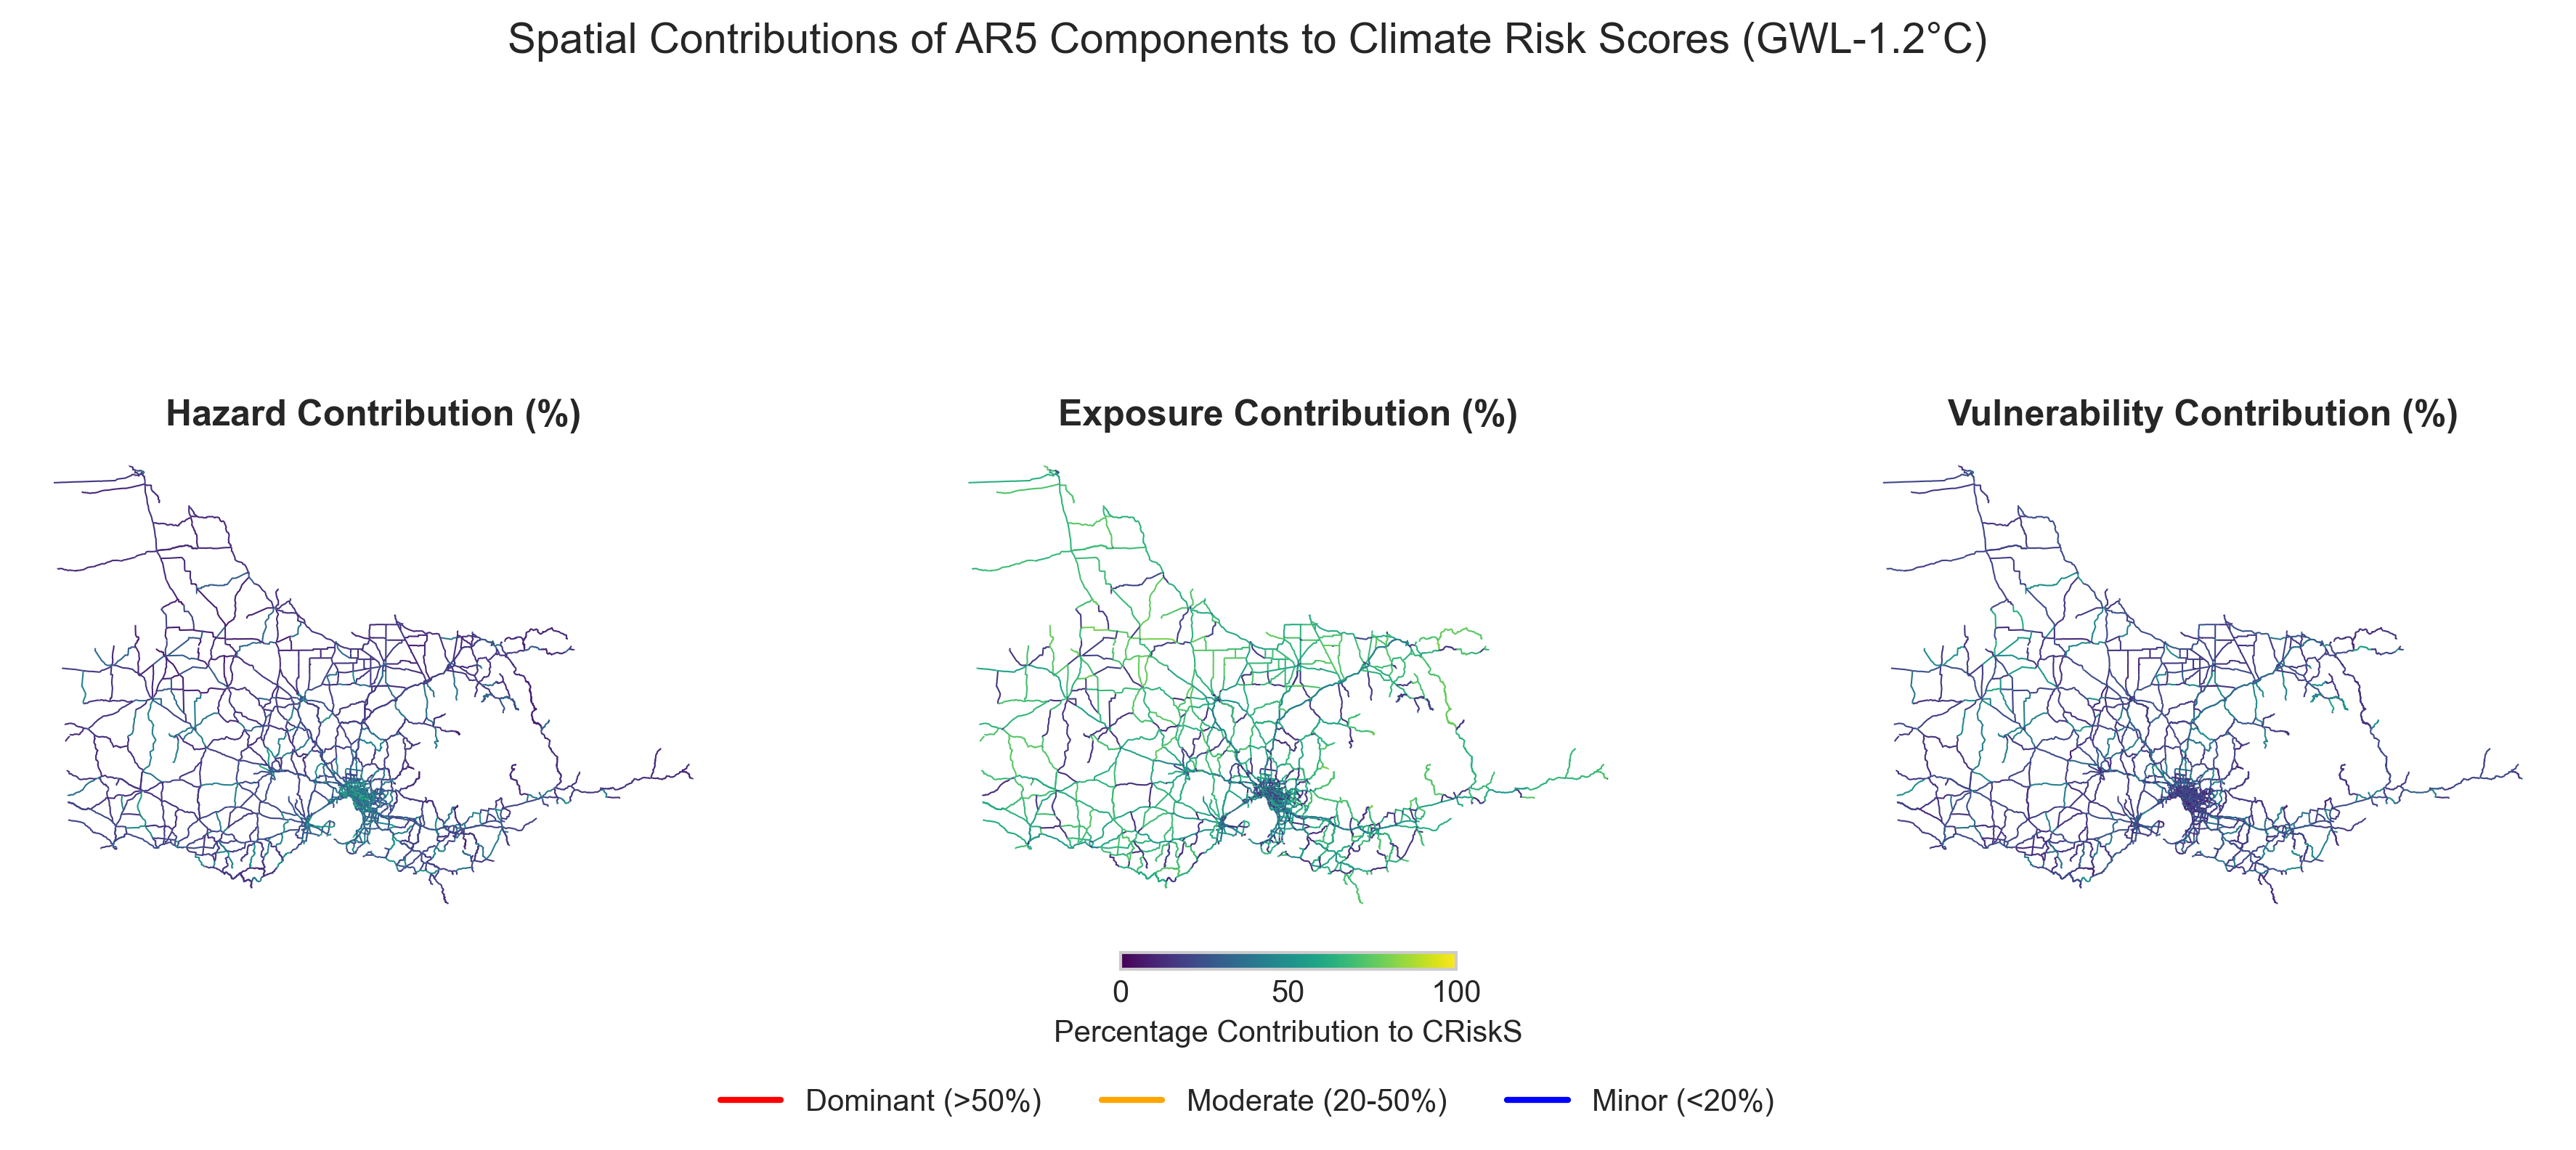

In [18]:
# Plot AR5 Component Contribution
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

# Configuration
run_id = "model_dev"
outputs_id = "out_crisks"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
scenario_id = "current"
crs_path = os.path.join(output_dir, f"climate_risk_scores_with_component_contributions_gwl-{scenario_id}_{run_id}.csv")
geojson_path = os.path.join(output_dir, f"../gdf_road_clim_cln_final_cra_calc.geojson")

# Load data
df_contrib = pd.read_csv(crs_path)
gdf_roads = gpd.read_file(geojson_path)  # Load all, filter columns post-load

# Merge contributions with geometries on road_link_id
gdf = gdf_roads[['road_link_id', 'geometry']].merge(
    df_contrib[['road_link_id', 'CRS-current', 'Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']],
    on='road_link_id', how='left'
)

# Filter for valid CRS > 0 and set CRS to EPSG:3111 (Victorian GDA2020)
gdf = gdf[gdf['CRS-current'] > 0].to_crs('EPSG:3111')

# Create faceted subplot figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'aspect': 'auto'})
components = ['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']
titles = ['Hazard Contribution (%)', 'Exposure Contribution (%)', 'Vulnerability Contribution (%)']

# Plot each component with uniform scale
vmin, vmax = 0, 100  # Fixed scale for percentage contributions
for idx, (col, title) in enumerate(zip(components, titles)):
    ax = axes[idx]
    gdf.plot(column=col, ax=ax, linewidth=0.5, cmap='viridis', vmin=vmin, vmax=vmax, legend=False,
             missing_kwds={'color': 'lightgrey', 'label': 'No Data'})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_axis_off()

# Add shared colourbar with uniform scale
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.05)
cbar.set_label('Percentage Contribution to CRiskS', fontsize=10)

# Add legend for dominant component example
legend_elements = [Line2D([0], [0], color='red', lw=2, label='Dominant (>50%)'),
                   Line2D([0], [0], color='orange', lw=2, label='Moderate (20-50%)'),
                   Line2D([0], [0], color='blue', lw=2, label='Minor (<20%)')]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Title and layout adjustment
plt.suptitle('Spatial Contributions of AR5 Components to Climate Risk Scores (GWL-1.2°C)', fontsize=14, y=0.98)
fig.subplots_adjust(bottom=0.15, top=0.85, wspace=0.3)  # Manual spacing to avoid tight_layout issues
# plt.savefig('component_contributions_map.png', dpi=300, bbox_inches='tight')
plt.show()

Checking unique road_link_id counts:
CSV: 7419 links
GeoJSON: 7419 links
CRS-current NaN count: 0
Hazard_contrib_pct NaN count: 0
Exposure_contrib_pct NaN count: 0
Vulnerability_contrib_pct NaN count: 0

=== Contribution Statistics ===
Means (across all links, including zeros):
Hazard: 34.16%
Exposure: 42.82%
Vulnerability: 23.02%

Means (for CRiskS > 0 only):
Hazard: 34.16%
Exposure: 42.82%
Vulnerability: 23.02%

Medians (across all links):
Hazard: 31.37%
Exposure: 49.24%
Vulnerability: 21.58%

Medians (for CRiskS > 0 only):
Hazard: 31.37%
Exposure: 49.24%
Vulnerability: 21.58%


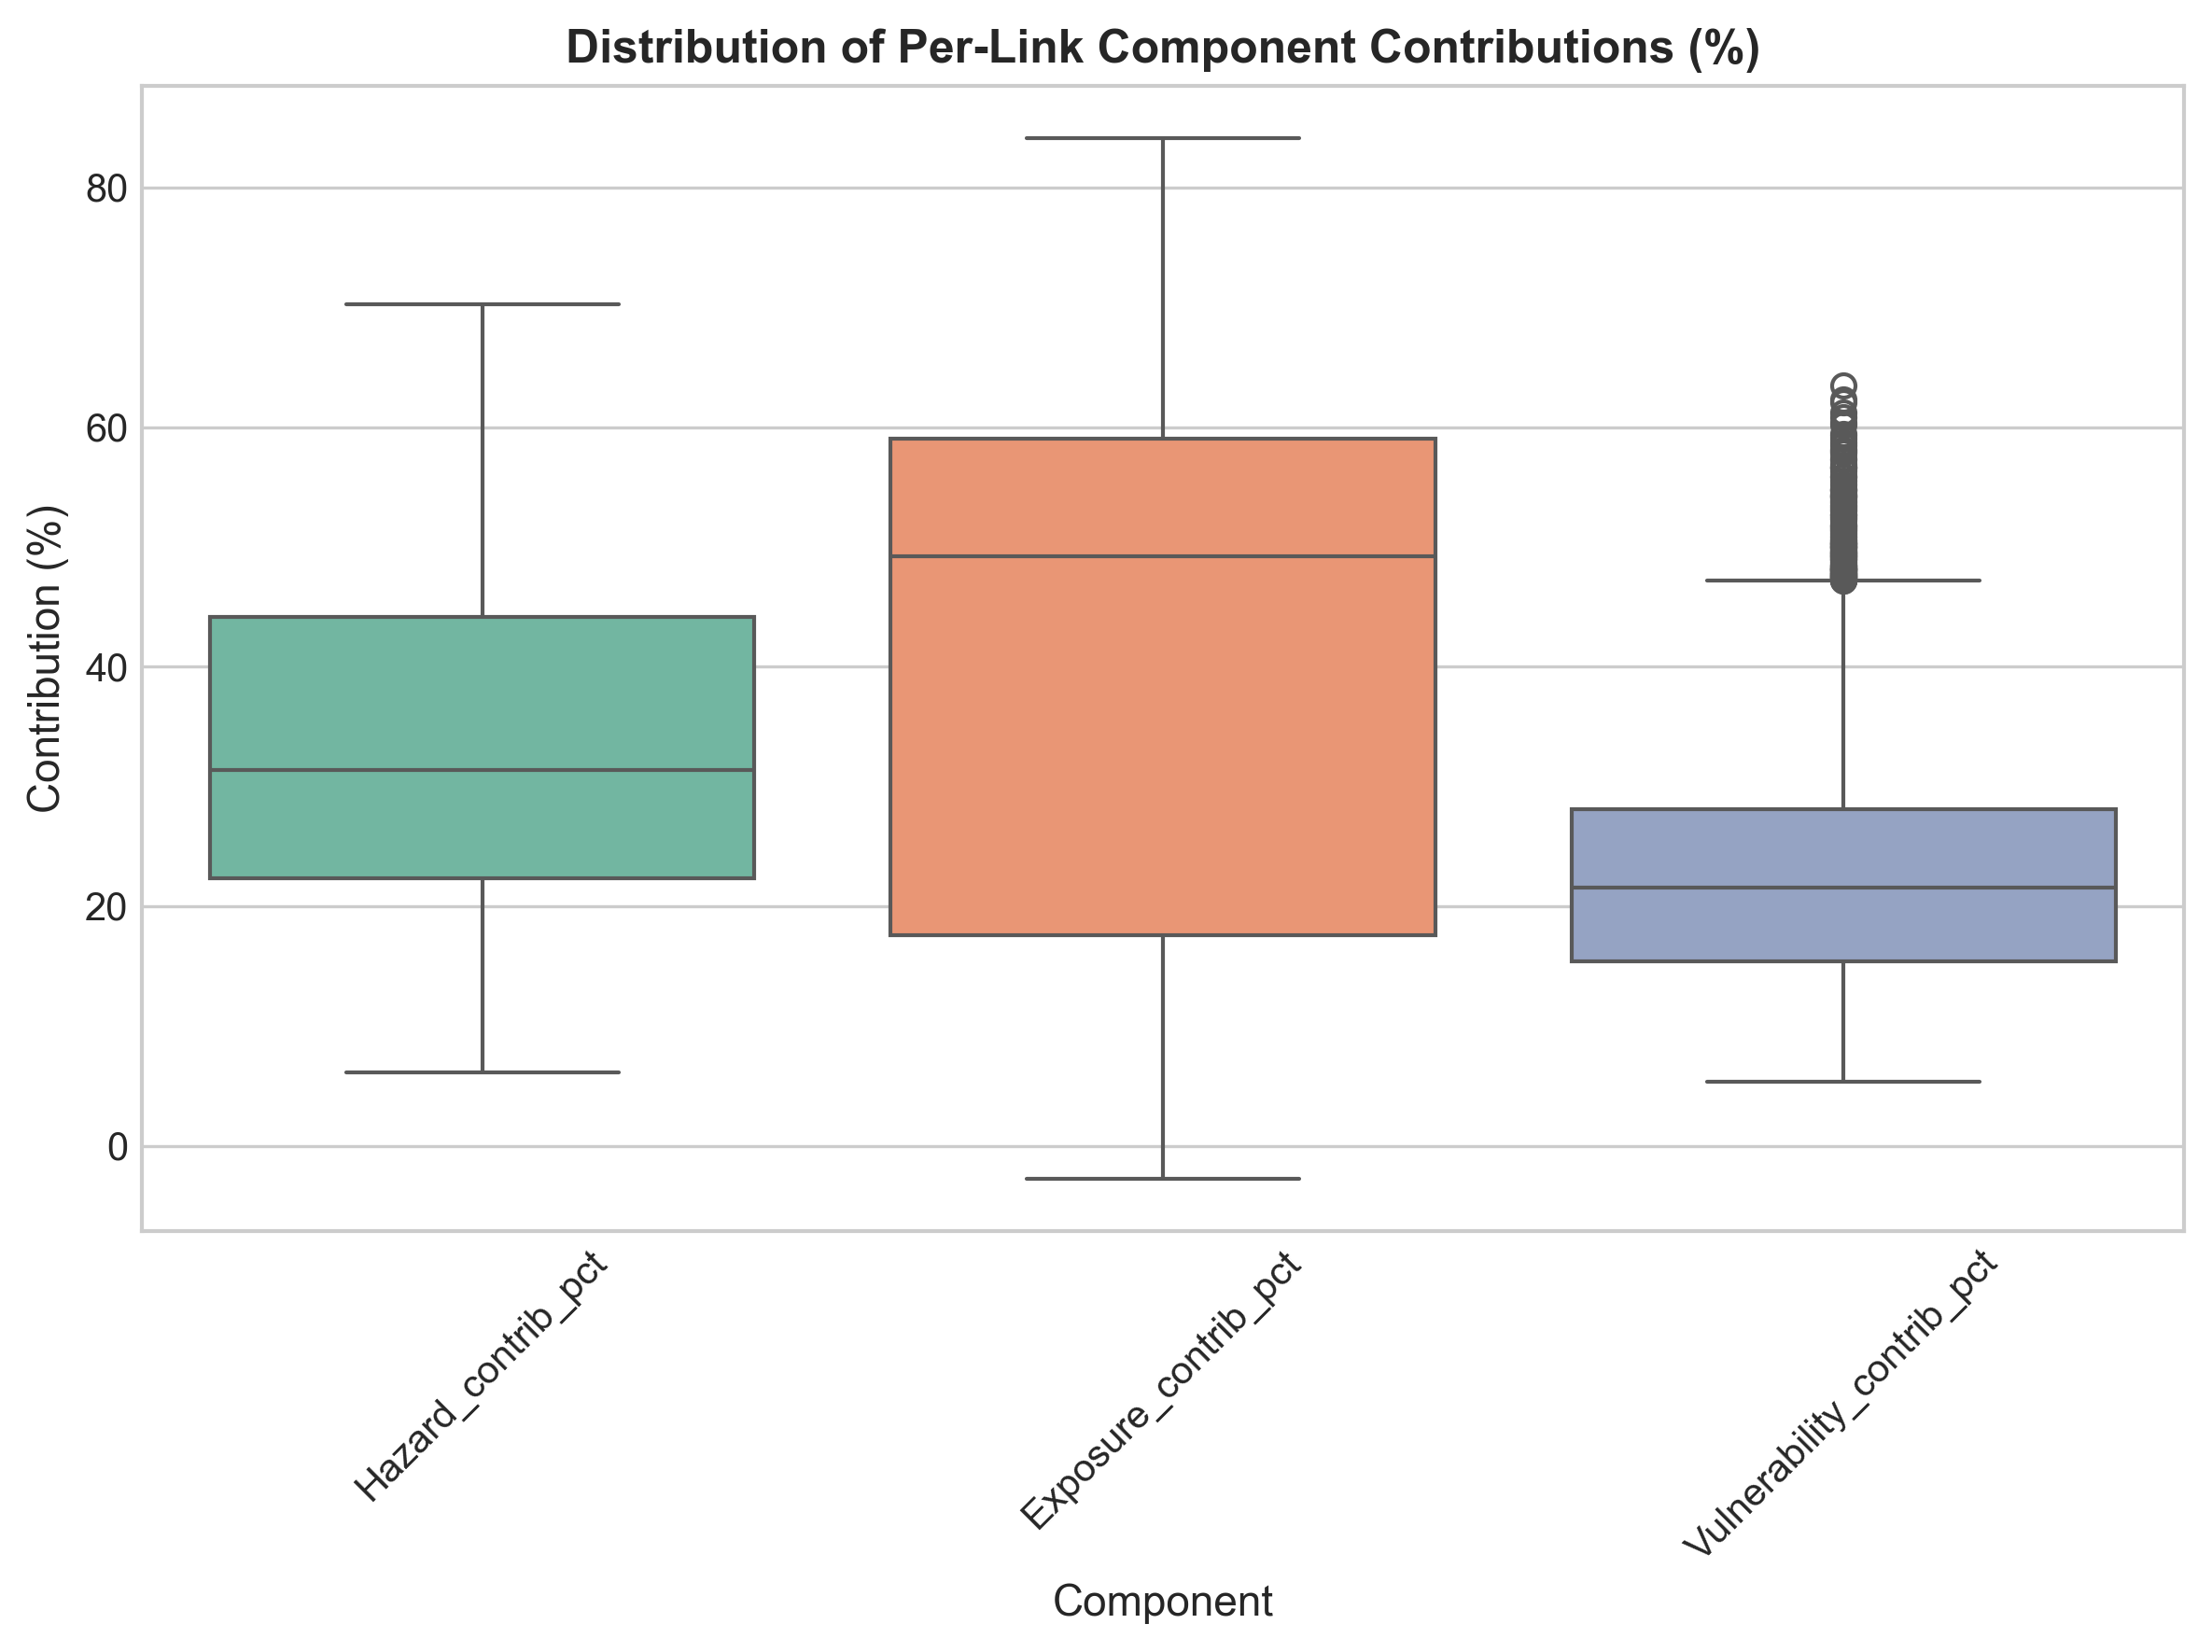

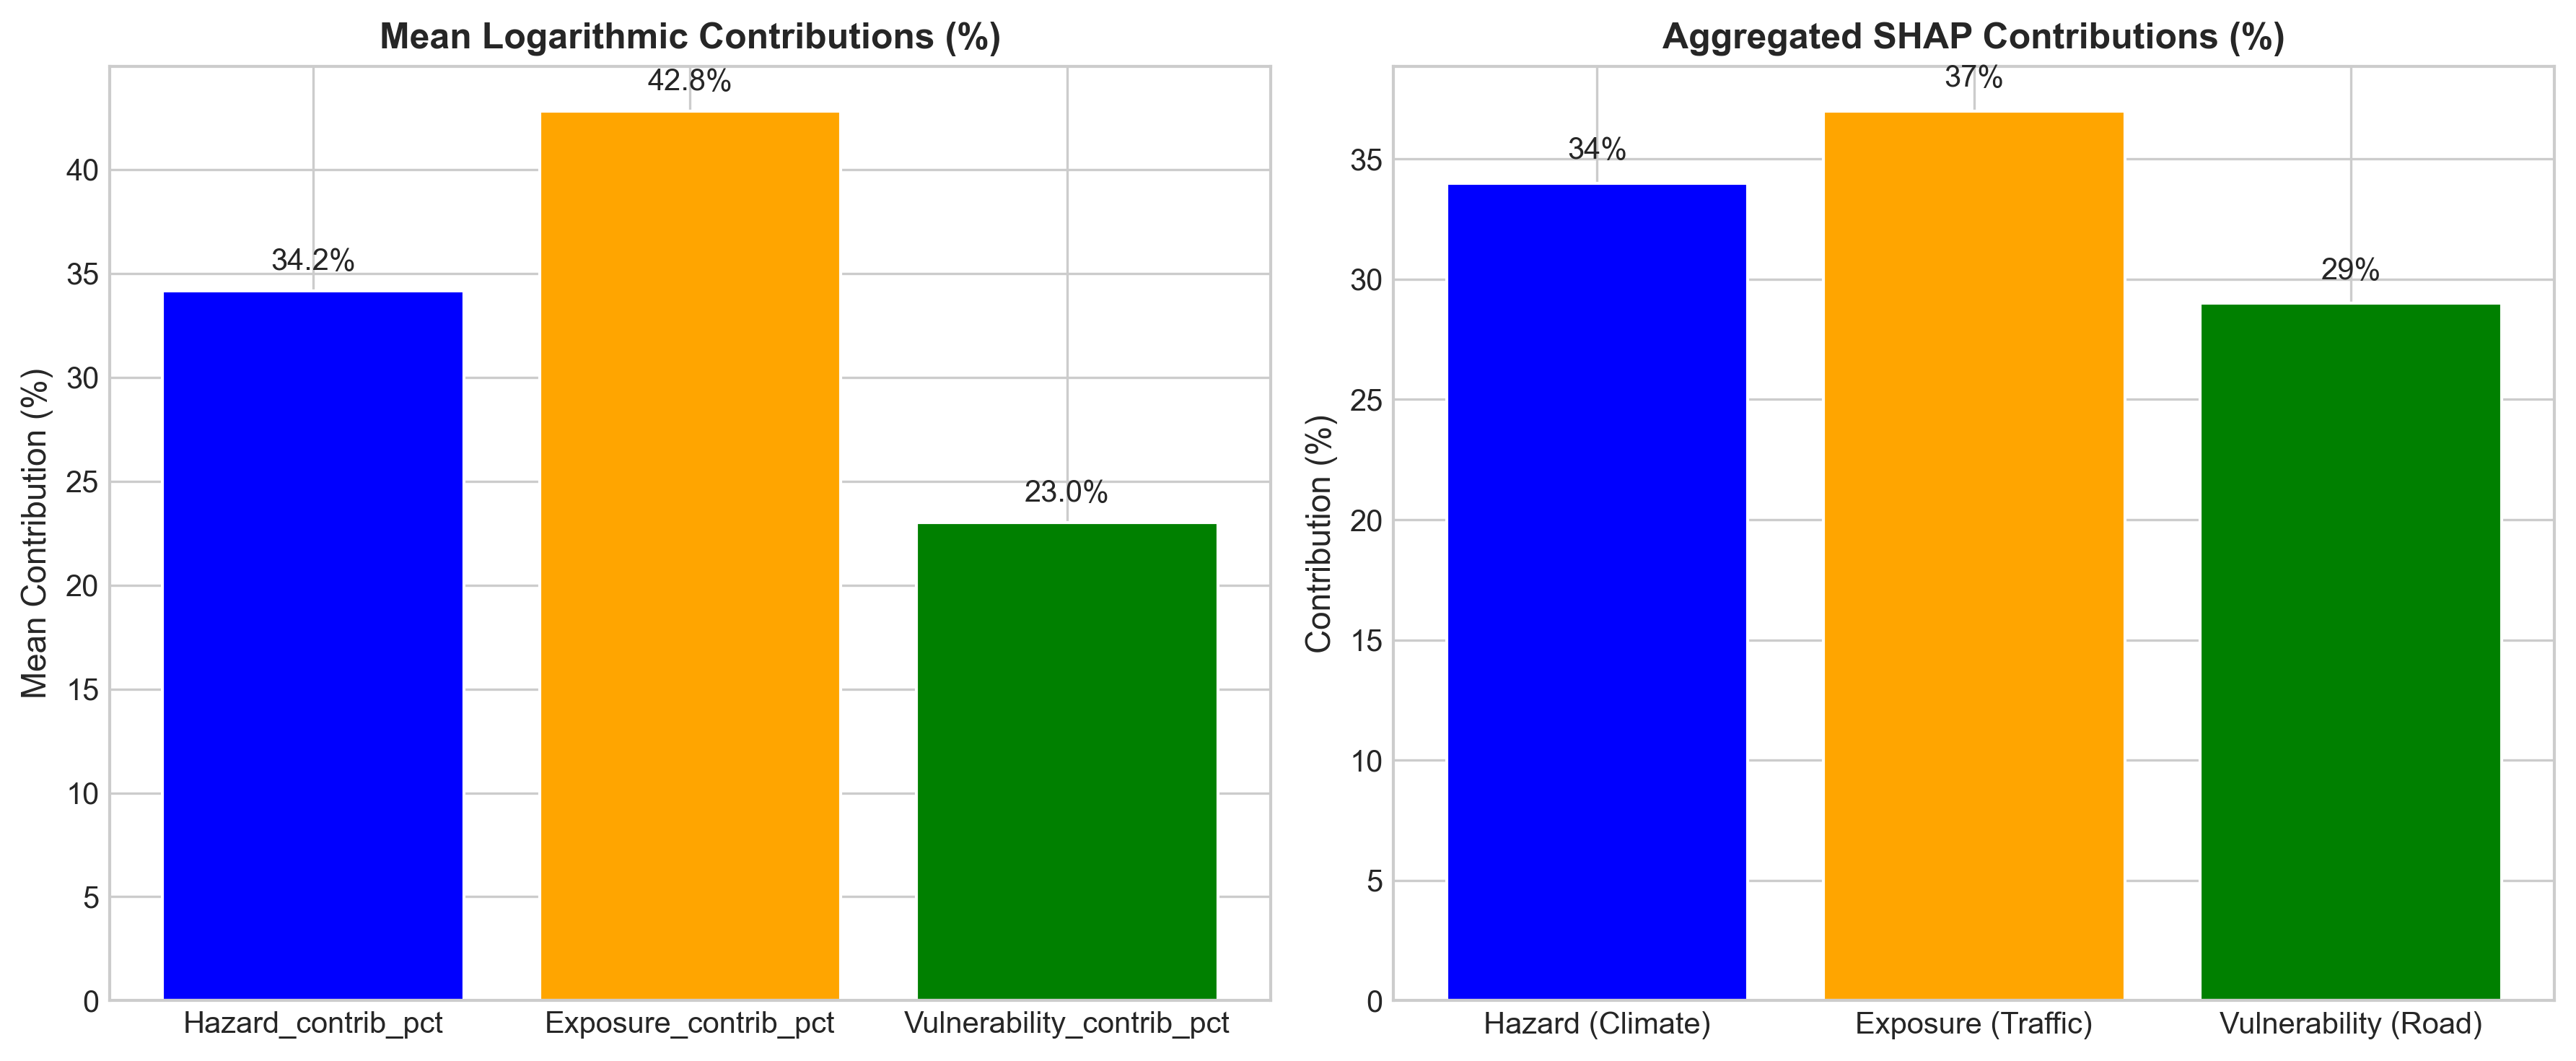

Visualisations saved to ../data/processed/model_dev/out_crisks\figures


In [19]:
# Visualise Different Type of Contributions
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import numpy as np

# Configuration
run_id = "model_dev"
outputs_id = "out_crisks"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
scenario_id = "current"
crs_path = os.path.join(output_dir, f"climate_risk_scores_with_component_contributions_gwl-{scenario_id}_{run_id}.csv")
geojson_path = os.path.join(output_dir, f"../gdf_road_clim_cln_final_cra_calc.geojson")

# Load data
df_crs = pd.read_csv(crs_path)
gdf_roads = gpd.read_file(geojson_path)

# Merge on road_link_id
print("Checking unique road_link_id counts:")
print(f"CSV: {len(df_crs['road_link_id'].unique())} links")
print(f"GeoJSON: {len(gdf_roads['road_link_id'].unique())} links")
gdf = gdf_roads.merge(df_crs, on='road_link_id', how='left', suffixes=('_geo', '_csv'))

# Diagnostic: Ensure numeric data
for col in ['CRS-current', 'Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']:
    print(f"{col} NaN count: {gdf[col].isna().sum()}")
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce').fillna(0)

# Compute and print mean and median contributions (for non-zero CRiskS where applicable)
mask = gdf['CRS-current'] > 0
print("\n=== Contribution Statistics ===")
print("Means (across all links, including zeros):")
print(f"Hazard: {gdf['Hazard_contrib_pct'].mean():.2f}%")
print(f"Exposure: {gdf['Exposure_contrib_pct'].mean():.2f}%")
print(f"Vulnerability: {gdf['Vulnerability_contrib_pct'].mean():.2f}%")

print("\nMeans (for CRiskS > 0 only):")
print(f"Hazard: {gdf.loc[mask, 'Hazard_contrib_pct'].mean():.2f}%")
print(f"Exposure: {gdf.loc[mask, 'Exposure_contrib_pct'].mean():.2f}%")
print(f"Vulnerability: {gdf.loc[mask, 'Vulnerability_contrib_pct'].mean():.2f}%")

print("\nMedians (across all links):")
print(f"Hazard: {gdf['Hazard_contrib_pct'].median():.2f}%")
print(f"Exposure: {gdf['Exposure_contrib_pct'].median():.2f}%")
print(f"Vulnerability: {gdf['Vulnerability_contrib_pct'].median():.2f}%")

print("\nMedians (for CRiskS > 0 only):")
print(f"Hazard: {gdf.loc[mask, 'Hazard_contrib_pct'].median():.2f}%")
print(f"Exposure: {gdf.loc[mask, 'Exposure_contrib_pct'].median():.2f}%")
print(f"Vulnerability: {gdf.loc[mask, 'Vulnerability_contrib_pct'].median():.2f}%")

# Set up figure style
sns.set_style("whitegrid")
fig_dir = os.path.join(output_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

# 2. Box Plots for Distributions (Updated for FutureWarning)
plt.figure(figsize=(8, 6))
melted = pd.melt(gdf[['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']],
                 var_name='Component', value_name='Contribution (%)')
sns.boxplot(data=melted, x='Component', y='Contribution (%)', hue='Component', palette='Set2', legend=False)
plt.title('Distribution of Per-Link Component Contributions (%)', fontweight='bold')
plt.ylabel('Contribution (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"{scenario_id}_contribution_boxplots.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, f"{scenario_id}_contribution_boxplots.pdf"), bbox_inches='tight')
plt.show()

# 3. Stacked Bar Chart for Aggregated Contributions
agg_contribs = gdf[['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']].mean()
shap_contribs = pd.Series({'Hazard (Climate)': 34, 'Exposure (Traffic)': 37, 'Vulnerability (Road)': 29})

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(agg_contribs.index, agg_contribs.values, color=['blue', 'orange', 'green'])
ax[0].set_title('Mean Logarithmic Contributions (%)', fontweight='bold')
ax[0].set_ylabel('Mean Contribution (%)')
for i, v in enumerate(agg_contribs.values):
    ax[0].text(i, v + 1, f'{v:.1f}%', ha='center')

ax[1].bar(shap_contribs.index, shap_contribs.values, color=['blue', 'orange', 'green'])
ax[1].set_title('Aggregated SHAP Contributions (%)', fontweight='bold')
ax[1].set_ylabel('Contribution (%)')
for i, v in enumerate(shap_contribs.values):
    ax[1].text(i, v + 1, f'{v}%', ha='center')

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"{scenario_id}_aggregated_contributions.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, f"{scenario_id}_aggregated_contributions.pdf"), bbox_inches='tight')
plt.show()

print(f"Visualisations saved to {fig_dir}")


# Generate Kepler Map for Interactive Visualisation

In [20]:
# Generate Kepler Map for All Scenarios
import os
import geopandas as gpd
from keplergl import KeplerGl

# Configuration
run_id = "model_dev"
outputs_id = "out_crisks"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
scenario_id = "current"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}_offset.geojson")
scenario_ids = [
    "current",
]

# Load geospatial data
gdf = gpd.read_file(data_path)

# Ensure GeoDataFrame is in EPSG:3111
if gdf.crs != "EPSG:3111":
    gdf = gdf.to_crs("EPSG:3111")

# Generate Kepler map
map_1 = KeplerGl(height=800)
# config_fp = os.path.join(output_dir, f"keplergl_config_{run_id}.py")
# %run {config_fp}    # load config using variable path
# # %run keplergl_config_craf250812.py    # load config

for scenario_id in scenario_ids:
    # Filter Datasets
    gdf_crs = gdf[[f'CRS-{scenario_id}', 'geometry']]

    # Add data to map with scenario-specific names
    map_1.add_data(gdf_crs, f'Climate Risk Score (gwl-{scenario_id})')

# map_1.config = config    # apply config
map_1    # Show map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Climate Risk Score (gwl-current)': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

In [ ]:
# map_1.config    # extract config data
# Save map_1 config to a file
with open(f"../data/processed/{run_id}/{outputs_id}/keplergl_config_{run_id}.py", 'w') as f:
    f.write('config = {}'.format(map_1.config))

# Save map to html
map_1.save_to_html(file_name=f"../data/processed/{run_id}/{outputs_id}/climate_risk_output_gwl-all_{run_id}_offset.html")
